## Advanced Lane Finding Project (with writeup as markdown cells)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.   


Note: I have given code cell number at the beginning of each code cell. I'll be referring it in the markdown cells while explaining. Refer to code comments too.
---
## First, I'll compute the camera calibration using chessboard images

In [2]:
### CODE CELL 1 ###

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

nx = 9    #number of inner corners the chessboard contains column wise
ny = 6    #number of inner corners the chessboard contains row wise

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Make a list of calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')


### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained the reslts.  Check output of CODE CELL 2 for the detected chessboard corners.
The output of CODE CELL 3 shows displays the undistorted chessboard image after applying the cv2.undistort function.
Distortion is visible at the edge of the chessboard. The edge appears to be curved rather than straight. Undistortion clears up this unwanted effect radial and tangential distortion.


[11 10  1 14]


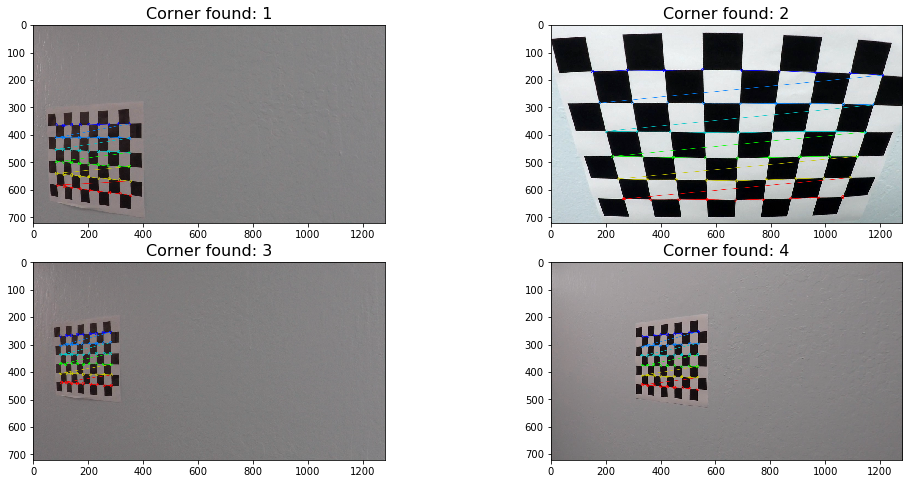

In [3]:
### CODE CELL 2 ###

## Function to find chessboard corners and draw the corners

def chessboard_finddraw(img_path,obp):
    chess_out = []   #array for chessboard images with corners drawn
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx,fname in enumerate(img_path):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(obp)
            imgpoints.append(corners)
 
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #write_name = './chessboard_corners/corners_found'+str(idx)+'.jpg'
            #plt.imsave(write_name, img)
            chess_out.append(img)
    
    return chess_out, objpoints, imgpoints    ## function returns images with corners drawn and image points and object points
            
corner_find, objpoints, imgpoints = chessboard_finddraw(cal_images, objp)   

## Plotting 4 random images for the found chessboard corners
fig = plt.figure(figsize=(17,8))
rand = np.random.randint(0,len(corner_find),size = 4)
print(rand)
pos = 1
for i in rand:
    im = fig.add_subplot(2,2,pos)
    im.set_title('Corner found: '+str(pos), fontsize=16)
    im.imshow(corner_find[i])
    pos+=1 

### CODE CELL 3

The `cv2.calibrateCamera()` function returns camera matrix `mtx` and distortion coefficients `dst` to be used with `cv2.undistort()` to undistort the images.

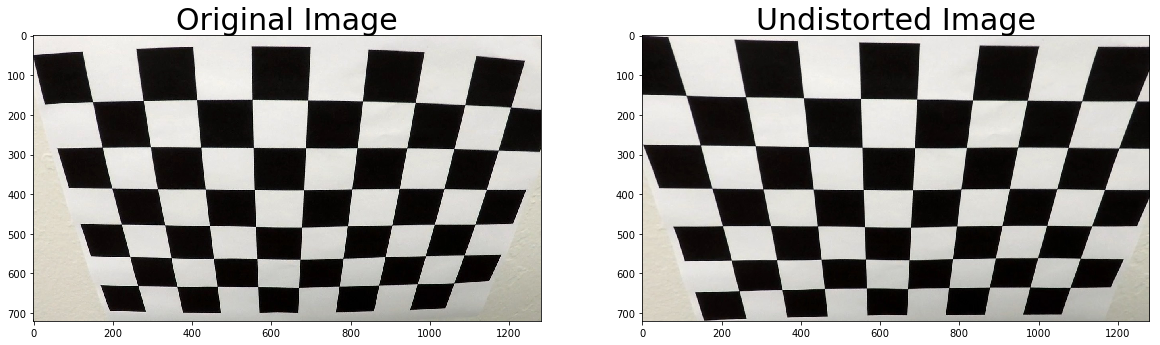

In [4]:
### CODE CELL 3 ###

import pickle

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "./camera_cal/calibrated.p", "wb" ) )

# Test undistortion on an image
dist_img = mpimg.imread('./camera_cal/calibration2.jpg')
img_size = (dist_img.shape[1], dist_img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

## Undistort the image by using cv2 function undistort
dst = cv2.undistort(dist_img, mtx, dist, None, mtx)
#cv2.imwrite("./camera_cal/calibration2_undist.jpg",dst)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dist_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Code cell 4 output shows the undistorted test images captured from the car

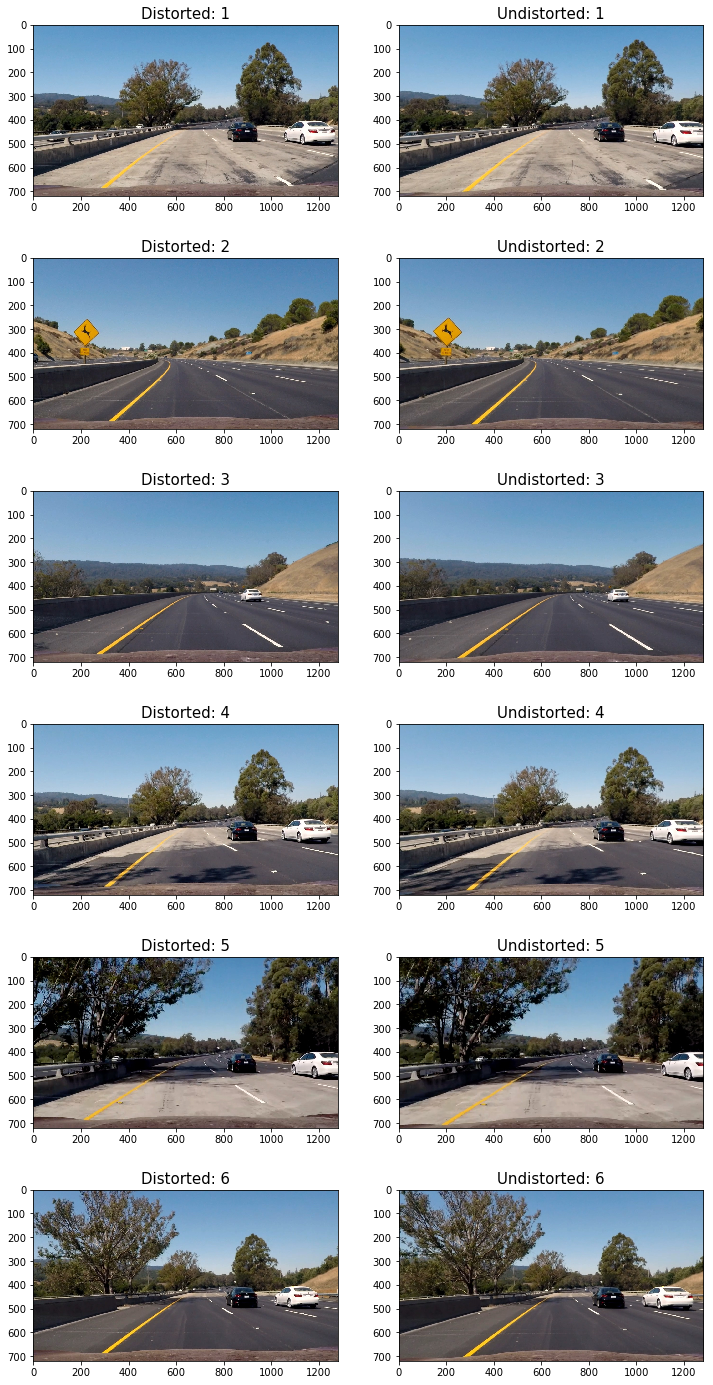

In [22]:
### CODE CELL 4 ###

test_images = glob.glob('./test_images/test*.jpg')    ## Gather image paths for the test images

# Visualising the distorted and undistorted test images (Distortion visible near the corner of the images and car bumper area)
fig1 = plt.figure(figsize = (12,25)) 
pos_im = 1
lab = 1
for idx,t_img in enumerate(test_images):
    tmp = mpimg.imread(t_img)
    undist = cv2.undistort(tmp, mtx, dist, None, mtx)
    ax = fig1.add_subplot(6,2,pos_im)
    ax.imshow(tmp)
    ax.set_title('Distorted: '+str(lab), fontsize=15)
    ax = fig1.add_subplot(6,2,pos_im+1)
    ax.imshow(undist)
    ax.set_title('Undistorted: '+str(lab), fontsize=15)
    lab +=1
    pos_im+=2 


### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image. I used yellow color thresholding and white color thresholdig to extract the lanes from the image. CODE CELL 5 output shows the yellow color thresholding of the left lane line. Similarly, CODE CELL 6 shows color thresholding of the right lane line. The thresholding values were found empirically by testing on the test images. `cv2.inRange()` function was used to threshold the HSV image between the lower and upper threshold values. This can be found in the `color_mask()` and `apply_color_mask()` function definitions. `cv2.bitwise_and()` was used to give a binary output but with color information of the yellow and white line by providing a mask. This is just for analysis purpose. In the actual pipeline pure binary image is used.

(-0.5, 1279.5, 719.5, -0.5)

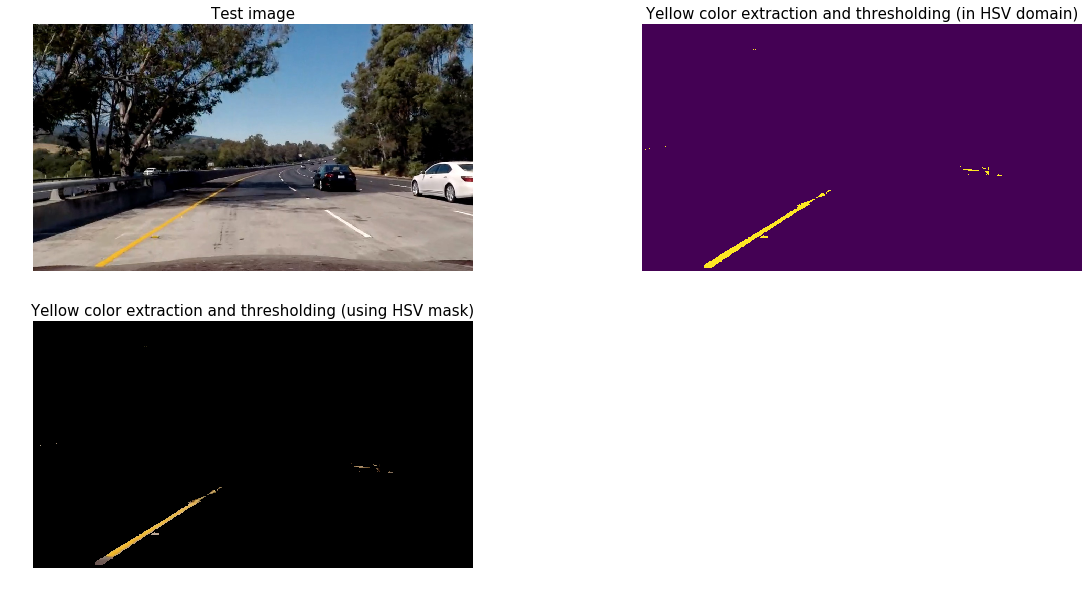

In [6]:
### CODE CELL 5 ###

def color_mask(hsv,low,high):     ## function to extract yellow color information
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img,mask= mask)
    return res

im_path = './test_images/test5.jpg'
image = mpimg.imread(im_path)
undist = cv2.undistort(image, mtx, dist, None, mtx)       # Undistorting the image
image_HSV = cv2.cvtColor(undist,cv2.COLOR_RGB2HSV)        # Converting to HSV domain, since it is useful for color selection

yellow_hsv_low  = np.array([ 0,  100,  110])         # yellow color lower thresholding values
yellow_hsv_high = np.array([ 80, 255, 255])          # yellow color upper thresholding values


res = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)

res_b = apply_color_mask(image_HSV,image,yellow_hsv_low,yellow_hsv_high)

## Visualising yellow color thresholded image
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(undist)
plt.title('Test image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(res)
plt.title('Yellow color extraction and thresholding (in HSV domain)',fontsize=15)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(res_b)
plt.title('Yellow color extraction and thresholding (using HSV mask)',fontsize=15)
plt.axis('off')


### CODE CELL 6 outputs white color thresholded images

I converted the images to HLS colorspace since I read it off the internet its easier to detect white in HLS. But in the actual pipeline I used HSV colorspace only. After playing with the lower and upper threshold I found it does a pretty good job.

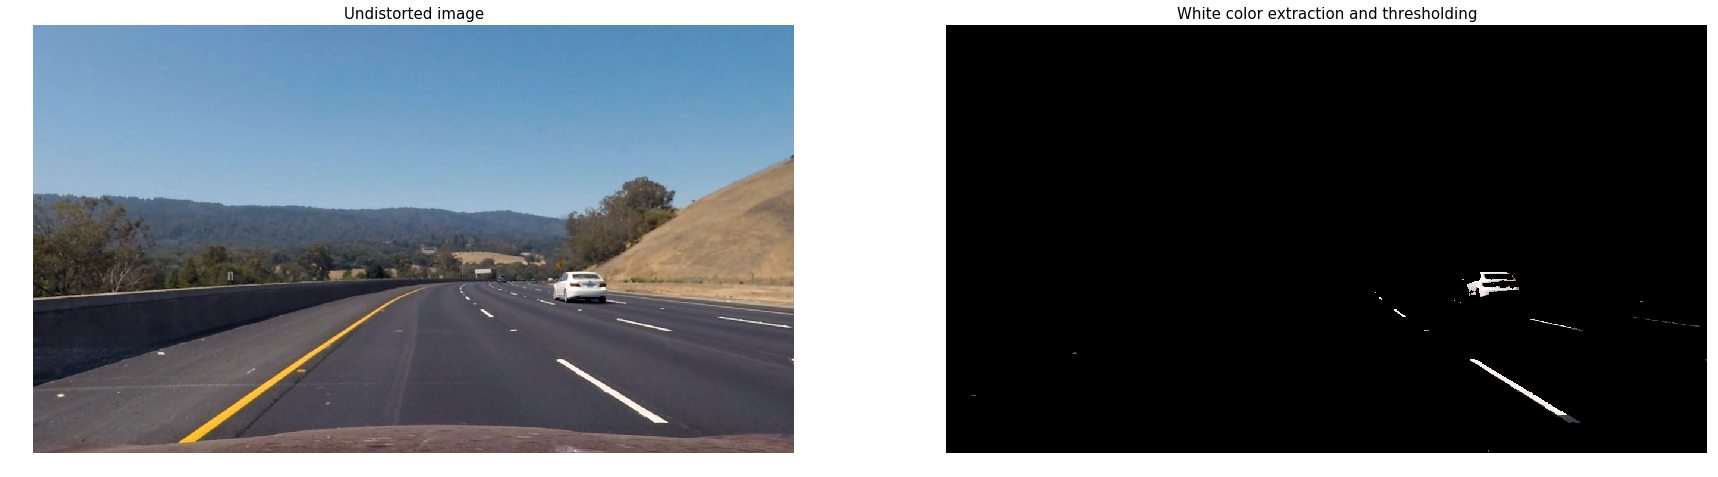

In [7]:
### CODE CELL 6 ###

im_path = './test_images/test3.jpg'
image = mpimg.imread(im_path)
undist = cv2.undistort(image, mtx, dist, None, mtx)
image_HLS = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)

white_hls_low  = np.array([0,200,0])               # white color lower thresholding values
white_hls_high = np.array([179,255,255])           # white color upper thresholding values

res1 = apply_color_mask(image_HLS,image,white_hls_low,white_hls_high)

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(undist)
plt.title('Undistorted image', fontsize=15)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('White color extraction and thresholding',fontsize=15)
plt.axis('off');


## CODE CELL 7 outputs combined thresholded images i.e. yellow and white color threshold

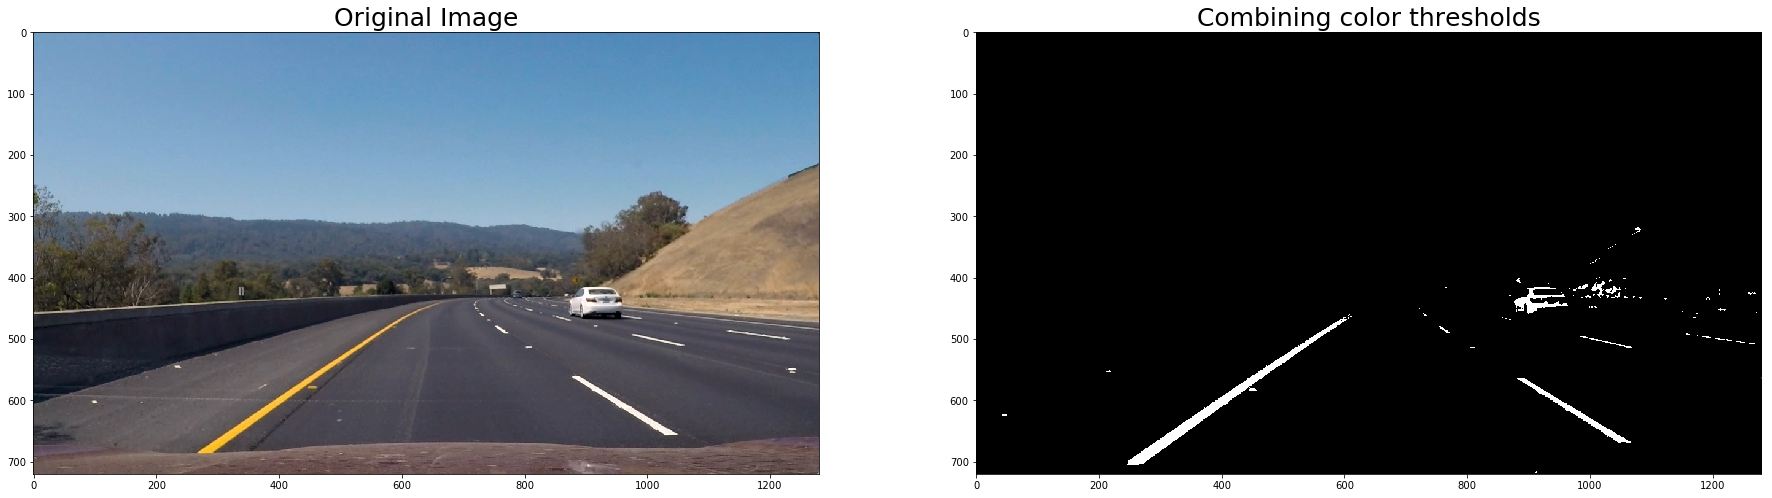

In [23]:
### CODE CELL 7 ###

im_path = './test_images/test3.jpg'
image = mpimg.imread(im_path)
undist = cv2.undistort(image, mtx, dist, None, mtx)
image_HSV = cv2.cvtColor(undist,cv2.COLOR_RGB2HSV)
image_HLS = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)

yellow_hsv_low  = np.array([ 0, 110, 110])
yellow_hsv_high = np.array([ 80, 255, 255])
white_hls_low  = np.array([ 0,  200, 0])
white_hls_high = np.array([ 179, 255, 255])
    
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HLS,white_hls_low,white_hls_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.set_tight_layout(True)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(mask_lane, cmap='gray')
ax2.set_title('Combining color thresholds', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### CODE CELL 8 contains a bunch of functions to perform various tasks as follows (in sequence) :

* `warp_image()` - applies perspective transform to the image to give a top-down view of thr road
* `color_mask()` and `apply_color_mask()` -  these are fuctions for color thresholding
* `sobelXYmagdir()` -  chooses the type of `cv2.Sobel()` to use on the image based on the input argument 'orient'. Additionally it also calculates the magnitude of gradient and direction of gradient for orient='mag' and orient='dir' respectively. This function is called from `abs_sobel_thresh()`, `mag_thresh()` and `dir_thresh()`.
* `abs_sobel_thresh()` - applies thresholding after applying required sobel functions
* `mag_thresh()` -  applies required thresholding after getting the gradient magnitude from `sobelXYmagdir()`. Outputs a binary image.
* `dir_thresh()` -  applies required thresholding after getting the gradient direction from `sobelXYmagdir()`. Outputs a binary image.
* `binary_warp_pipeline()` - this pipeline accepts a warped image and combines the sobel, gradient and color thresholding operations and outputs a binary image with lane lines detected.
* `window_mask()` -  this is a function to draw the window areas
* `find_window_centroids()` - this function takes in the binary warped image, slices the image in different sections and detects lane line pixels in each section using a sliding window search approach like the one in shown in the classroom lesson. After each window detects the line the x-values of the centroid of the window is returned by this function. It also returns the center point of the road by finding the midpoint of the centroids of the bottom-most right and left lane window which will be used further to find the deviation of the from the center of the road.

In [9]:
### CODE CELL 8 ###

# HELPER FUNCTIONS

def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv

def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img,mask= mask)
    return res

def sobelXYMagDir(img, orient, sobel_kernel):
    # Grayscale conversion for sobel input
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply sobel kernel based on x or y orientation
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
        result = np.uint8(255*abs_sobel/np.max(abs_sobel))

    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
        result = np.uint8(255*abs_sobel/np.max(abs_sobel))

    if orient == 'mag':
        # Scaling in the range 0-255
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        mag_sobelxy = np.sqrt(sobelx**2 + sobely**2)
        result = np.uint8(255*mag_sobelxy/np.max(mag_sobelxy))

    if orient == 'dir':
        abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
        abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
        # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        result = np.arctan2(abs_sobely, abs_sobelx)

    return result

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply Sobel and scale in the range 0-255
    scaled_sobel = sobelXYMagDir(img, orient, sobel_kernel)
    # Apply thresholding
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image, orient = 'mag', sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude and scale
    gradmag  = sobelXYMagDir(image, orient, sobel_kernel)
    # Apply threshold
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return mag_binary

def dir_thresh(image, orient = 'dir', sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    absgraddir = sobelXYMagDir(image, orient, sobel_kernel)
    # Apply threshold
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    return dir_binary

def binary_warp_pipeline(getimg, s_thresh=(170, 255), sx_thresh=(20, 50)):
    img = np.copy(getimg)
    # Apply each of the thresholding functions
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements 
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(160, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(25, 250))
    dir_binary = dir_thresh(img, dir_thresh=(0.9, np.pi/2))
    
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    yellow_hsv_low  = np.array([ 0, 60, 130])
    yellow_hsv_high = np.array([ 100, 255, 255])
    sensitivity = 50
    white_hsv_low  = np.array([ 0, 0, 255-sensitivity])
    white_hsv_high = np.array([ 255, 30, 255])

    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
    #color_binary = np.dstack((gradx,mag_binary, mask_lane))
    sobel_comb = np.zeros_like(gradx)
    sobel_comb[((gradx == 1) | (grady == 1)) | (mag_binary == 1) & (dir_binary == 1)] = 1
    
    return cv2.bitwise_or(mask_lane,sobel_comb)


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(binary_warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:int(binary_warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,int(binary_warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2)
    lr_center = (l_center+r_center)/2
    # Add what we found for the first layer
    window_centroids.append([l_center,r_center])
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(binary_warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(binary_warped[int(binary_warped.shape[0]-(level+1)*window_height):int(binary_warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width*0.65        #### offset was 0.5 ####
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append([l_center,r_center])

    return np.asarray(window_centroids), lr_center


## CODE CELL 9 

 This is where we read the image, undistort it, perform perspective transform and apply binary thresholding.
 `src` and `dst` are the source and destination points to apply the perspective transform. We choose the source points based on our region of interest to be warped. The destination points can be chosen to cover the entire image or parts outside the reigion of interest of the source. The 1st output image of CODE CELL 9 shows the region of interest drawn on the road. The second shows the perspective transformed or warped image with the destination points drawn. The third image shows the sobel and color thresholded binary image. The `warp_image()` function returns a warped image , a perspective transform matrix `M_per` and inverse perspective transform matrix `Minv_per` which is used lateron to unwarp the image.

(720, 1280, 3)


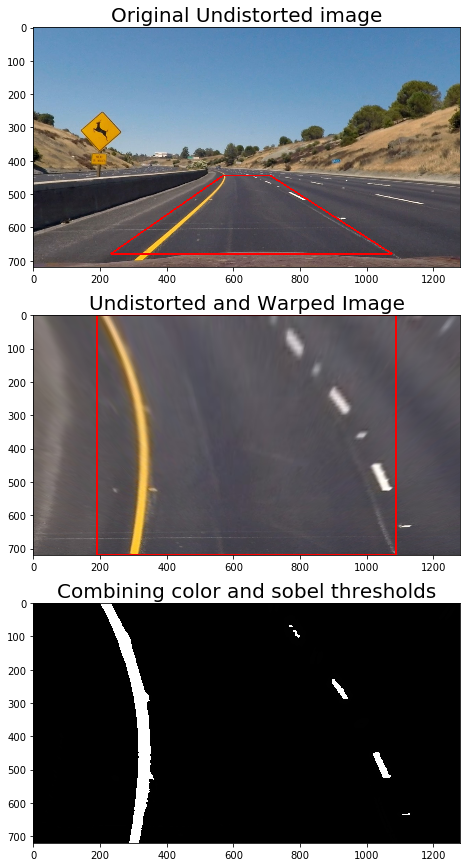

In [18]:
### CODE CELL 9 ###

im_path = './test_images/test2.jpg'
image = mpimg.imread(im_path)
print(image.shape)
undist = cv2.undistort(image, mtx, dist, None, mtx)

img_size = (image.shape[1], image.shape[0])
'''
src = np.float32([[img_size[0] / 2 - 65, img_size[1] / 2 + 100],
                  [img_size[0] / 2 + 70, img_size[1] / 2 + 100],
                  [img_size[0] * (5 / 6) - 10 + 10,680],
                  [img_size[0] / 6 + 40, 680]])

dst = np.float32([[img_size[0] * 0.25, 0],
                  [img_size[0] * 0.75, 0],
                  [img_size[0] * 0.75, img_size[1]],
                  [img_size[0] * 0.25, img_size[1]]])
'''
src = np.float32([[img_size[0] / 2 - 70, img_size[1] / 2 + 85],
                  [img_size[0] / 2 + 70, img_size[1] / 2 + 85],
                  [img_size[0] * (5 / 6) - 10 + 20, 680],
                  [img_size[0] / 6 + 20, 680]])

dst = np.float32([[img_size[0] * 0.15, 0],
                  [img_size[0] * 0.85, 0],
                  [img_size[0] * 0.85, img_size[1]],
                  [img_size[0] * 0.15, img_size[1]]])
    

warped, M_per, Minv_per = warp_image(undist, src, dst, img_size)

binary_warp = binary_warp_pipeline(warped)

# Add polylines to image to see where they are
roi = np.copy(undist)
cv2.polylines(roi,[np.int32(src)],True,(255,0,0), thickness=3);
cv2.polylines(warped,[np.int32(dst)],True,(255,0,0), thickness=3);
# Plot undistorted image and undistorted+warped image
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 15))
ax1.imshow(roi)
ax1.set_title('Original Undistorted image', fontsize=20);
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=20);
ax3.imshow(binary_warp, cmap='gray')
ax3.set_title('Combining color and sobel thresholds', fontsize=20);
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## CODE CELL 10

### `detect_lane_image()` function is like a blackbox function which takes a camera image and returns the same image with output detected lane and output drawn on the road.

* During the sliding window search I used centroid points of each of the window of the left lane and right lane to fit the lines using a quadratic function. An example can be seen below in the output of CODE CELL 10(1st image).   
   
* The radius of curvature of the road is found out using the same method and formula as described in the classroom lessons. I have commented below "#### CALCULATE THE NEW RADII OF CURVATURE ####" where this is done. I calculated the average radius of curvature to display it in the video stream.     

* The `find_window_centroids()` function also returns the center of the lane (`road_center` is the variable) which is approximately the true center. Assuming the camera is mounted in the center of the car, I considered the center of the camera image as the center of the car (`car_center`). Subtracting them i.e. (`offset = road-center - car_center`) I determined the deviation of the car from the center. Since the deviation is very small I displayed it in centimeters. Positive offset means the deviation is towards the right and negative offset means deviation is towards the left

* Finally the area between the fitted area is given a green color and unwarped (using Minv_per i.e. inverse perspective transform matrix) and added with the original undistorted image. Result is the second output image of CODE CELL 10.

Left lane radius of curvature: 345.76 meters
Right lane radius of curvature: 492.85 meters


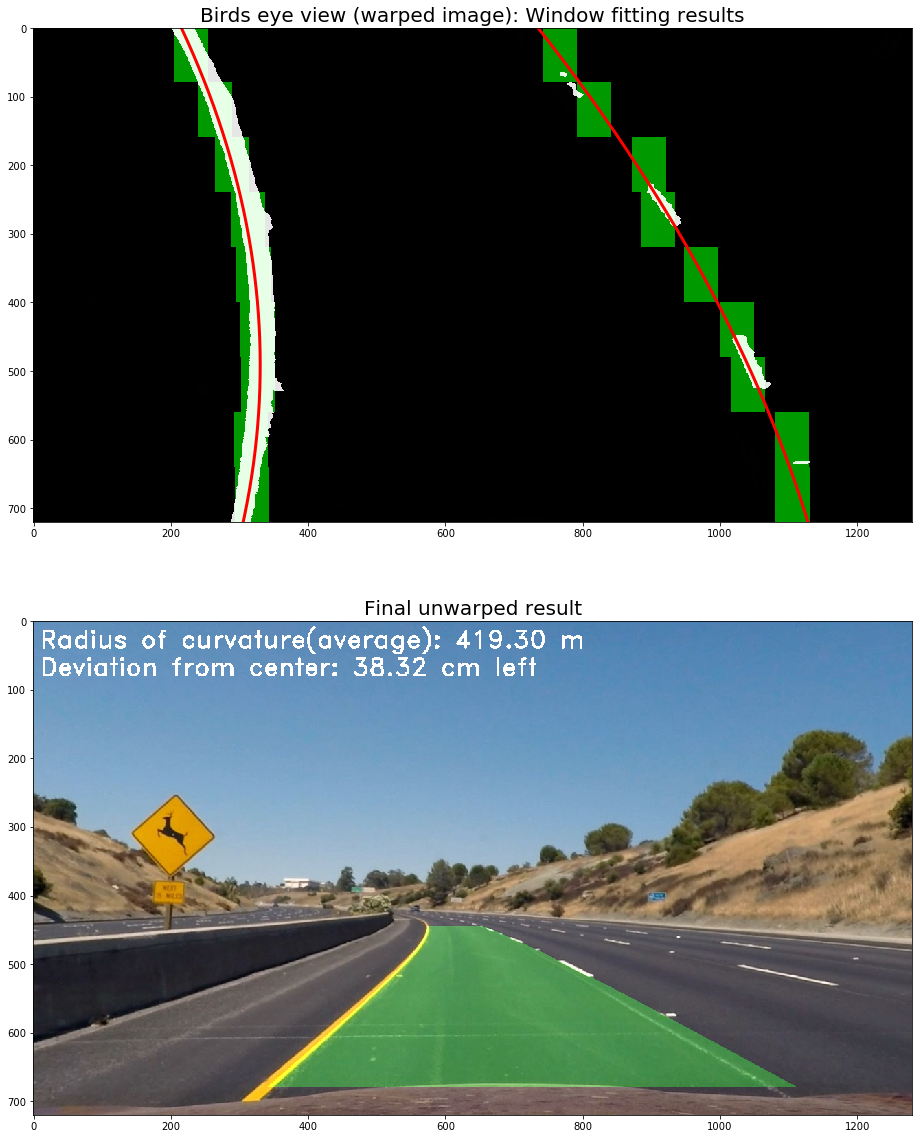

In [20]:
### CODE CELL 10 ###

def detect_lane_image(frame):
    image = mpimg.imread(frame)
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    img_size = (image.shape[1], image.shape[0])
    '''
    src = np.float32([[img_size[0]*0.43, img_size[1]*0.63],
                      [img_size[0]*0.58, img_size[1]*0.63],
                      [1200, 680],
                      [150, 680]])

    dst = np.float32([[0,0],
                      [img_size[0],0],
                      [img_size[0],img_size[1]],
                      [0,img_size[1]]])
    '''
    src = np.float32([[img_size[0] / 2 - 70, img_size[1] / 2 + 85],
                      [img_size[0] / 2 + 70, img_size[1] / 2 + 85],
                      [img_size[0] * (5 / 6) - 10 + 20, 680],
                      [img_size[0] / 6 + 20, 680]])

    dst = np.float32([[img_size[0] * 0.15, 0],
                      [img_size[0] * 0.85, 0],
                      [img_size[0] * 0.85, img_size[1]],
                      [img_size[0] * 0.15, img_size[1]]])
    
    warped, M_per, Minv_per = warp_image(undist, src, dst, img_size)

    binary_warp = binary_warp_pipeline(warped)

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 80 # How much to slide left and right for searching

    #### Detect lane lines by sliding window search and find centroids of each window for polynomial curve fitting
    
    # GET THE X CO-ORDINATES OF THE WINDOW
    window_centroids_x, road_center = find_window_centroids(binary_warp, window_width, window_height, margin)
    
    # GET THE Y CO-ORDINATES OF THE WINDOW (THESE ARE CONSTANT BECAUSE THE WINDOW MOVES UP AS MUCH AS THE WINDOW HEIGHT)
    window_centroids_y = np.asarray([[x,x] for x in reversed(range(40,binary_warp.shape[0],window_height))])
    
    ### I use these x and y co ordinates of the windows to fit a quadratic function. 
    ### We get 9 points each for the left and right lane lines for fitting the lines.
    
    # If we found any window centers
    if len(window_centroids_x) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warp)
        r_points = np.zeros_like(binary_warp)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids_x)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warp,window_centroids_x[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warp,window_centroids_x[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((binary_warp,binary_warp,binary_warp)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0.9, template, 0.6, 0.0) # overlay the orignal road image with window results

        left_fit = np.polyfit(window_centroids_y[:,0], window_centroids_x[:,0], 2)  # Get polynomial coefficients for left lane
        right_fit = np.polyfit(window_centroids_y[:,1], window_centroids_x[:,1], 2)  # Get polynomial coefficients for right lane
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warp.shape[0]-1, binary_warp.shape[0])   # Generate y co-ordinates top to down
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]     # Get x co-ordinates of points to be plotted for left lane
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] # Get x co-ordinates of points to be plotted for right lane
        
        img1.plot(left_fitx, ploty, color='red', linewidth=3)
        img1.plot(right_fitx, ploty, color='red', linewidth=3)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        y_eval = np.max(ploty)
        
        #### CALCULATE THE NEW RADII OF CURVATURE ####
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Now our radius of curvature is in meters
        print('Left lane radius of curvature: {:.2f} meters'.format(left_curverad))
        print('Right lane radius of curvature: {:.2f} meters'.format(right_curverad))
        
        curve_rad = (left_curverad + right_curverad)/2    #finding the average radius of curvature
        
        car_center = image.shape[1]/2
        offset = car_center - road_center
        
        if offset > 0:
            side = 'right'
        else:
            side = 'left'
        
        offset_ws = offset*xm_per_pix*100

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((binary_warp,binary_warp,binary_warp)),np.uint8)
    

    warp_zero = np.zeros_like(binary_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_per, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    final_unwarp = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    font = cv2.FONT_HERSHEY_DUPLEX
    rad_curve_text = "Radius of curvature(average): %.2f m" %curve_rad
    center_text = "Deviation from center: %.2f cm %s" % (abs(offset_ws), side)
    cv2.putText(final_unwarp, rad_curve_text,(10,40), font, 1.2,(255,255,255),2);
    cv2.putText(final_unwarp, center_text,(10,80), font, 1.2,(255,255,255),2);
    
    return final_unwarp, output


f2, (img1,img2) = plt.subplots(2, 1, figsize=(50,20))

im_path = './test_images/test2.jpg'
lane, fitline = detect_lane_image(im_path)     #, fitline 

img1.imshow(fitline)
img1.set_title('Birds eye view (warped image): Window fitting results', fontsize=20);

img2.imshow(lane)
img2.set_title('Final unwarped result', fontsize=20);


# This is the same pipeline as used in CODE CELL 10, but just for processing the video. 

Here's a [link to my video result](./project_video_output_final.mp4)

I just removed the printing and plotting part from the pipeline.    
CODE CELL 12 contains standard code for processing the video and saving it.   
CODE CELL 13 contains small piece of code for displaying the generated video in the jupyter notebook

NOTE: Check the last code cell for discussion.

In [ ]:
### CODE CELL 11 ###

def detect_lane_pipeline(frame):        ### VIDEO  ###
    undist = cv2.undistort(frame, mtx, dist, None, mtx)

    img_size = (image.shape[1], image.shape[0])
    '''
    src = np.float32([[img_size[0]*0.43, img_size[1]*0.63],
                      [img_size[0]*0.58, img_size[1]*0.63],
                      [1200, 680],
                      [150, 680]])

    dst = np.float32([[0,0],
                      [img_size[0],0],
                      [img_size[0],img_size[1]],
                      [0,img_size[1]]])
    '''
    src = np.float32([[img_size[0] / 2 - 70, img_size[1] / 2 + 85],
                      [img_size[0] / 2 + 70, img_size[1] / 2 + 85],
                      [img_size[0] * (5 / 6) - 10 + 20, 680],
                      [img_size[0] / 6 + 20, 680]])

    dst = np.float32([[img_size[0] * 0.15, 0],
                      [img_size[0] * 0.85, 0],
                      [img_size[0] * 0.85, img_size[1]],
                      [img_size[0] * 0.15, img_size[1]]])
    
    warped, M_per, Minv_per = warp_image(undist, src, dst, img_size)

    binary_warp = binary_warp_pipeline(warped)

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 80 # How much to slide left and right for searching

    #### Detect lane lines by sliding window search and find centroids of each window for polynomial curve fitting

    window_centroids_x, road_center = find_window_centroids(binary_warp, window_width, window_height, margin)
    window_centroids_y = np.asarray([[x,x] for x in reversed(range(40,binary_warp.shape[0],window_height))])

    # If we found any window centers
    if len(window_centroids_x) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warp)
        r_points = np.zeros_like(binary_warp)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids_x)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warp,window_centroids_x[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warp,window_centroids_x[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((binary_warp,binary_warp,binary_warp)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0.9, template, 0.6, 0.0) # overlay the orignal road image with window results

        left_fit = np.polyfit(window_centroids_y[:,0], window_centroids_x[:,0], 2)
        right_fit = np.polyfit(window_centroids_y[:,1], window_centroids_x[:,1], 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warp.shape[0]-1, binary_warp.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #img1.plot(left_fitx, ploty, color='red', linewidth=3)
        #img1.plot(right_fitx, ploty, color='red', linewidth=3)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        y_eval = np.max(ploty)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Now our radius of curvature is in meters
        print('Left lane radius of curvature: {:.2f} meters'.format(left_curverad))
        print('Right lane radius of curvature: {:.2f} meters'.format(right_curverad))
        
        curve_rad = (left_curverad + right_curverad)/2
        
        car_center = image.shape[1]/2
        offset = car_center - road_center
        
        if offset > 0:
            side = 'right'
        else:
            side = 'left'
        
        offset_ws = offset*xm_per_pix*100

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((binary_warp,binary_warp,binary_warp)),np.uint8)
    

    warp_zero = np.zeros_like(binary_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_per, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    final_unwarp = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    font = cv2.FONT_HERSHEY_DUPLEX
    rad_curve_text = "Radius of curvature(average): %.2f m" %curve_rad
    center_text = "Deviation from center: %.2f cm %s" % (abs(offset_ws), side)
    cv2.putText(final_unwarp, rad_curve_text,(10,40), font, 1.2,(255,255,255),2);
    cv2.putText(final_unwarp, center_text,(10,80), font, 1.2,(255,255,255),2);
    
    return final_unwarp


In [10]:
### CODE CELL 12 ###

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
road_clip = clip1.fl_image(detect_lane_pipeline)
%time road_clip.write_videofile(video_output, audio=False)

Left lane radius of curvature: 368.85 meters
Right lane radius of curvature: 275.68 meters
[MoviePy] >>>> Building video project_video_output_final.mp4
[MoviePy] Writing video project_video_output_final.mp4


  0%|          | 1/1261 [00:00<07:42,  2.72it/s]

Left lane radius of curvature: 368.85 meters
Right lane radius of curvature: 275.68 meters


  0%|          | 2/1261 [00:00<07:38,  2.75it/s]

Left lane radius of curvature: 359.21 meters
Right lane radius of curvature: 415.46 meters


  0%|          | 3/1261 [00:01<07:34,  2.77it/s]

Left lane radius of curvature: 336.65 meters
Right lane radius of curvature: 930.51 meters


  0%|          | 4/1261 [00:01<07:35,  2.76it/s]

Left lane radius of curvature: 349.78 meters
Right lane radius of curvature: 431.66 meters


  0%|          | 5/1261 [00:01<07:29,  2.79it/s]

Left lane radius of curvature: 350.02 meters
Right lane radius of curvature: 456.00 meters


  0%|          | 6/1261 [00:02<07:50,  2.67it/s]

Left lane radius of curvature: 357.96 meters
Right lane radius of curvature: 418.65 meters


  1%|          | 7/1261 [00:02<07:44,  2.70it/s]

Left lane radius of curvature: 368.76 meters
Right lane radius of curvature: 1304.09 meters


  1%|          | 8/1261 [00:02<07:31,  2.78it/s]

Left lane radius of curvature: 370.99 meters
Right lane radius of curvature: 596.45 meters


  1%|          | 9/1261 [00:03<07:22,  2.83it/s]

Left lane radius of curvature: 387.67 meters
Right lane radius of curvature: 427.51 meters


  1%|          | 10/1261 [00:03<07:17,  2.86it/s]

Left lane radius of curvature: 390.78 meters
Right lane radius of curvature: 217.27 meters


  1%|          | 11/1261 [00:03<07:14,  2.88it/s]

Left lane radius of curvature: 409.66 meters
Right lane radius of curvature: 353.46 meters


  1%|          | 12/1261 [00:04<07:13,  2.88it/s]

Left lane radius of curvature: 453.36 meters
Right lane radius of curvature: 321.22 meters


  1%|          | 13/1261 [00:04<07:16,  2.86it/s]

Left lane radius of curvature: 456.75 meters
Right lane radius of curvature: 323.35 meters


  1%|          | 14/1261 [00:04<07:15,  2.86it/s]

Left lane radius of curvature: 441.02 meters
Right lane radius of curvature: 309.07 meters


  1%|          | 15/1261 [00:05<07:14,  2.87it/s]

Left lane radius of curvature: 385.18 meters
Right lane radius of curvature: 328.29 meters


  1%|▏         | 16/1261 [00:05<07:10,  2.89it/s]

Left lane radius of curvature: 356.69 meters
Right lane radius of curvature: 460.40 meters


  1%|▏         | 17/1261 [00:06<07:12,  2.88it/s]

Left lane radius of curvature: 357.08 meters
Right lane radius of curvature: 558.74 meters


  1%|▏         | 18/1261 [00:06<07:20,  2.82it/s]

Left lane radius of curvature: 335.80 meters
Right lane radius of curvature: 508.18 meters


  2%|▏         | 19/1261 [00:06<07:18,  2.83it/s]

Left lane radius of curvature: 335.33 meters
Right lane radius of curvature: 2877.71 meters


  2%|▏         | 20/1261 [00:07<07:16,  2.84it/s]

Left lane radius of curvature: 359.71 meters
Right lane radius of curvature: 1554.00 meters


  2%|▏         | 21/1261 [00:07<07:15,  2.85it/s]

Left lane radius of curvature: 377.43 meters
Right lane radius of curvature: 472.49 meters


  2%|▏         | 22/1261 [00:07<07:15,  2.84it/s]

Left lane radius of curvature: 384.90 meters
Right lane radius of curvature: 498.74 meters


  2%|▏         | 23/1261 [00:08<07:13,  2.85it/s]

Left lane radius of curvature: 454.82 meters
Right lane radius of curvature: 265.67 meters


  2%|▏         | 24/1261 [00:08<07:12,  2.86it/s]

Left lane radius of curvature: 402.03 meters
Right lane radius of curvature: 282.70 meters


  2%|▏         | 25/1261 [00:08<07:11,  2.87it/s]

Left lane radius of curvature: 370.69 meters
Right lane radius of curvature: 271.76 meters


  2%|▏         | 26/1261 [00:09<07:09,  2.88it/s]

Left lane radius of curvature: 387.52 meters
Right lane radius of curvature: 266.00 meters


  2%|▏         | 27/1261 [00:09<07:11,  2.86it/s]

Left lane radius of curvature: 370.44 meters
Right lane radius of curvature: 294.83 meters


  2%|▏         | 28/1261 [00:09<07:11,  2.86it/s]

Left lane radius of curvature: 391.59 meters
Right lane radius of curvature: 341.28 meters


  2%|▏         | 29/1261 [00:10<07:15,  2.83it/s]

Left lane radius of curvature: 339.98 meters
Right lane radius of curvature: 751.14 meters


  2%|▏         | 30/1261 [00:10<07:11,  2.85it/s]

Left lane radius of curvature: 307.92 meters
Right lane radius of curvature: 309.20 meters


  2%|▏         | 31/1261 [00:10<07:09,  2.87it/s]

Left lane radius of curvature: 292.95 meters
Right lane radius of curvature: 273.92 meters


  3%|▎         | 32/1261 [00:11<07:10,  2.86it/s]

Left lane radius of curvature: 260.42 meters
Right lane radius of curvature: 1036.91 meters


  3%|▎         | 33/1261 [00:11<07:10,  2.85it/s]

Left lane radius of curvature: 275.37 meters
Right lane radius of curvature: 443.87 meters


  3%|▎         | 34/1261 [00:11<07:08,  2.86it/s]

Left lane radius of curvature: 270.85 meters
Right lane radius of curvature: 440.64 meters


  3%|▎         | 35/1261 [00:12<07:05,  2.88it/s]

Left lane radius of curvature: 265.47 meters
Right lane radius of curvature: 225.45 meters


  3%|▎         | 36/1261 [00:12<07:34,  2.70it/s]

Left lane radius of curvature: 266.66 meters
Right lane radius of curvature: 286.21 meters


  3%|▎         | 37/1261 [00:13<07:35,  2.69it/s]

Left lane radius of curvature: 266.87 meters
Right lane radius of curvature: 257.52 meters


  3%|▎         | 38/1261 [00:13<07:31,  2.71it/s]

Left lane radius of curvature: 264.33 meters
Right lane radius of curvature: 260.85 meters


  3%|▎         | 39/1261 [00:13<07:31,  2.71it/s]

Left lane radius of curvature: 254.29 meters
Right lane radius of curvature: 233.06 meters


  3%|▎         | 40/1261 [00:14<07:32,  2.70it/s]

Left lane radius of curvature: 248.61 meters
Right lane radius of curvature: 254.13 meters


  3%|▎         | 41/1261 [00:14<07:49,  2.60it/s]

Left lane radius of curvature: 257.48 meters
Right lane radius of curvature: 343.96 meters


  3%|▎         | 42/1261 [00:15<08:09,  2.49it/s]

Left lane radius of curvature: 266.30 meters
Right lane radius of curvature: 350.79 meters


  3%|▎         | 43/1261 [00:15<08:27,  2.40it/s]

Left lane radius of curvature: 277.80 meters
Right lane radius of curvature: 298.31 meters


  3%|▎         | 44/1261 [00:15<08:22,  2.42it/s]

Left lane radius of curvature: 284.43 meters
Right lane radius of curvature: 365.85 meters


  4%|▎         | 45/1261 [00:16<08:27,  2.39it/s]

Left lane radius of curvature: 307.74 meters
Right lane radius of curvature: 878.90 meters


  4%|▎         | 46/1261 [00:16<08:27,  2.39it/s]

Left lane radius of curvature: 314.80 meters
Right lane radius of curvature: 430.73 meters


  4%|▎         | 47/1261 [00:17<08:28,  2.39it/s]

Left lane radius of curvature: 323.14 meters
Right lane radius of curvature: 356.91 meters


  4%|▍         | 48/1261 [00:17<08:33,  2.36it/s]

Left lane radius of curvature: 333.75 meters
Right lane radius of curvature: 169.49 meters


  4%|▍         | 49/1261 [00:18<08:35,  2.35it/s]

Left lane radius of curvature: 379.98 meters
Right lane radius of curvature: 293.87 meters


  4%|▍         | 50/1261 [00:18<08:41,  2.32it/s]

Left lane radius of curvature: 375.58 meters
Right lane radius of curvature: 257.88 meters


  4%|▍         | 51/1261 [00:18<08:42,  2.31it/s]

Left lane radius of curvature: 400.29 meters
Right lane radius of curvature: 252.63 meters


  4%|▍         | 52/1261 [00:19<08:42,  2.31it/s]

Left lane radius of curvature: 381.34 meters
Right lane radius of curvature: 282.15 meters


  4%|▍         | 53/1261 [00:19<08:41,  2.32it/s]

Left lane radius of curvature: 370.75 meters
Right lane radius of curvature: 617.17 meters


  4%|▍         | 54/1261 [00:20<08:40,  2.32it/s]

Left lane radius of curvature: 392.26 meters
Right lane radius of curvature: 447.06 meters


  4%|▍         | 55/1261 [00:20<08:34,  2.35it/s]

Left lane radius of curvature: 389.45 meters
Right lane radius of curvature: 419.19 meters


  4%|▍         | 56/1261 [00:21<08:41,  2.31it/s]

Left lane radius of curvature: 410.31 meters
Right lane radius of curvature: 339.15 meters


  5%|▍         | 57/1261 [00:21<08:38,  2.32it/s]

Left lane radius of curvature: 389.62 meters
Right lane radius of curvature: 3886.22 meters


  5%|▍         | 58/1261 [00:21<08:36,  2.33it/s]

Left lane radius of curvature: 402.85 meters
Right lane radius of curvature: 568.85 meters


  5%|▍         | 59/1261 [00:22<08:34,  2.34it/s]

Left lane radius of curvature: 369.97 meters
Right lane radius of curvature: 299.07 meters


  5%|▍         | 60/1261 [00:22<08:39,  2.31it/s]

Left lane radius of curvature: 396.94 meters
Right lane radius of curvature: 183.57 meters


  5%|▍         | 61/1261 [00:23<08:35,  2.33it/s]

Left lane radius of curvature: 391.99 meters
Right lane radius of curvature: 347.02 meters


  5%|▍         | 62/1261 [00:23<08:33,  2.34it/s]

Left lane radius of curvature: 366.49 meters
Right lane radius of curvature: 245.77 meters


  5%|▍         | 63/1261 [00:24<08:26,  2.36it/s]

Left lane radius of curvature: 387.21 meters
Right lane radius of curvature: 264.41 meters


  5%|▌         | 64/1261 [00:24<08:25,  2.37it/s]

Left lane radius of curvature: 383.72 meters
Right lane radius of curvature: 317.95 meters


  5%|▌         | 65/1261 [00:24<08:26,  2.36it/s]

Left lane radius of curvature: 371.49 meters
Right lane radius of curvature: 568.76 meters


  5%|▌         | 66/1261 [00:25<08:29,  2.34it/s]

Left lane radius of curvature: 374.36 meters
Right lane radius of curvature: 434.48 meters


  5%|▌         | 67/1261 [00:25<08:36,  2.31it/s]

Left lane radius of curvature: 378.88 meters
Right lane radius of curvature: 547.11 meters


  5%|▌         | 68/1261 [00:26<08:36,  2.31it/s]

Left lane radius of curvature: 376.54 meters
Right lane radius of curvature: 367.58 meters


  5%|▌         | 69/1261 [00:26<08:37,  2.30it/s]

Left lane radius of curvature: 369.56 meters
Right lane radius of curvature: 1027.30 meters


  6%|▌         | 70/1261 [00:27<08:38,  2.30it/s]

Left lane radius of curvature: 399.23 meters
Right lane radius of curvature: 595.96 meters


  6%|▌         | 71/1261 [00:27<08:36,  2.30it/s]

Left lane radius of curvature: 392.63 meters
Right lane radius of curvature: 313.39 meters


  6%|▌         | 72/1261 [00:27<08:38,  2.29it/s]

Left lane radius of curvature: 401.69 meters
Right lane radius of curvature: 307.33 meters


  6%|▌         | 73/1261 [00:28<08:43,  2.27it/s]

Left lane radius of curvature: 389.19 meters
Right lane radius of curvature: 193.01 meters


  6%|▌         | 74/1261 [00:28<08:47,  2.25it/s]

Left lane radius of curvature: 435.84 meters
Right lane radius of curvature: 311.71 meters


  6%|▌         | 75/1261 [00:29<08:44,  2.26it/s]

Left lane radius of curvature: 468.34 meters
Right lane radius of curvature: 300.75 meters


  6%|▌         | 76/1261 [00:29<08:40,  2.28it/s]

Left lane radius of curvature: 441.58 meters
Right lane radius of curvature: 244.31 meters


  6%|▌         | 77/1261 [00:30<08:48,  2.24it/s]

Left lane radius of curvature: 480.87 meters
Right lane radius of curvature: 295.51 meters


  6%|▌         | 78/1261 [00:30<08:45,  2.25it/s]

Left lane radius of curvature: 490.57 meters
Right lane radius of curvature: 508.05 meters


  6%|▋         | 79/1261 [00:31<08:48,  2.24it/s]

Left lane radius of curvature: 492.83 meters
Right lane radius of curvature: 402.15 meters


  6%|▋         | 80/1261 [00:31<08:46,  2.24it/s]

Left lane radius of curvature: 504.34 meters
Right lane radius of curvature: 388.75 meters


  6%|▋         | 81/1261 [00:32<08:45,  2.25it/s]

Left lane radius of curvature: 450.06 meters
Right lane radius of curvature: 382.03 meters


  7%|▋         | 82/1261 [00:32<08:35,  2.29it/s]

Left lane radius of curvature: 431.35 meters
Right lane radius of curvature: 514.69 meters


  7%|▋         | 83/1261 [00:32<08:33,  2.29it/s]

Left lane radius of curvature: 413.26 meters
Right lane radius of curvature: 569.35 meters


  7%|▋         | 84/1261 [00:33<08:24,  2.33it/s]

Left lane radius of curvature: 470.28 meters
Right lane radius of curvature: 505.50 meters


  7%|▋         | 85/1261 [00:33<08:24,  2.33it/s]

Left lane radius of curvature: 466.24 meters
Right lane radius of curvature: 531.53 meters


  7%|▋         | 86/1261 [00:34<08:22,  2.34it/s]

Left lane radius of curvature: 427.98 meters
Right lane radius of curvature: 297.47 meters


  7%|▋         | 87/1261 [00:34<08:25,  2.32it/s]

Left lane radius of curvature: 373.73 meters
Right lane radius of curvature: 310.58 meters


  7%|▋         | 88/1261 [00:34<08:19,  2.35it/s]

Left lane radius of curvature: 345.21 meters
Right lane radius of curvature: 303.76 meters


  7%|▋         | 89/1261 [00:35<08:21,  2.33it/s]

Left lane radius of curvature: 315.98 meters
Right lane radius of curvature: 288.81 meters


  7%|▋         | 90/1261 [00:35<08:20,  2.34it/s]

Left lane radius of curvature: 277.65 meters
Right lane radius of curvature: 324.40 meters


  7%|▋         | 91/1261 [00:36<08:21,  2.33it/s]

Left lane radius of curvature: 287.48 meters
Right lane radius of curvature: 438.81 meters


  7%|▋         | 92/1261 [00:36<08:17,  2.35it/s]

Left lane radius of curvature: 296.88 meters
Right lane radius of curvature: 431.95 meters


  7%|▋         | 93/1261 [00:37<08:22,  2.32it/s]

Left lane radius of curvature: 288.64 meters
Right lane radius of curvature: 415.12 meters


  7%|▋         | 94/1261 [00:37<08:18,  2.34it/s]

Left lane radius of curvature: 283.78 meters
Right lane radius of curvature: 456.21 meters


  8%|▊         | 95/1261 [00:37<08:12,  2.37it/s]

Left lane radius of curvature: 298.03 meters
Right lane radius of curvature: 476.33 meters


  8%|▊         | 96/1261 [00:38<08:10,  2.37it/s]

Left lane radius of curvature: 299.11 meters
Right lane radius of curvature: 289.43 meters


  8%|▊         | 97/1261 [00:38<08:20,  2.33it/s]

Left lane radius of curvature: 296.83 meters
Right lane radius of curvature: 292.58 meters


  8%|▊         | 98/1261 [00:39<08:18,  2.33it/s]

Left lane radius of curvature: 300.56 meters
Right lane radius of curvature: 193.75 meters


  8%|▊         | 99/1261 [00:39<08:15,  2.35it/s]

Left lane radius of curvature: 297.87 meters
Right lane radius of curvature: 292.83 meters


  8%|▊         | 100/1261 [00:40<08:18,  2.33it/s]

Left lane radius of curvature: 305.22 meters
Right lane radius of curvature: 294.33 meters


  8%|▊         | 101/1261 [00:40<08:16,  2.34it/s]

Left lane radius of curvature: 305.28 meters
Right lane radius of curvature: 284.56 meters


  8%|▊         | 102/1261 [00:40<08:13,  2.35it/s]

Left lane radius of curvature: 292.35 meters
Right lane radius of curvature: 255.50 meters


  8%|▊         | 103/1261 [00:41<08:12,  2.35it/s]

Left lane radius of curvature: 286.02 meters
Right lane radius of curvature: 272.30 meters


  8%|▊         | 104/1261 [00:41<08:15,  2.34it/s]

Left lane radius of curvature: 289.99 meters
Right lane radius of curvature: 363.28 meters


  8%|▊         | 105/1261 [00:42<08:12,  2.35it/s]

Left lane radius of curvature: 308.85 meters
Right lane radius of curvature: 342.19 meters


  8%|▊         | 106/1261 [00:42<08:09,  2.36it/s]

Left lane radius of curvature: 319.44 meters
Right lane radius of curvature: 284.83 meters


  8%|▊         | 107/1261 [00:43<08:15,  2.33it/s]

Left lane radius of curvature: 333.95 meters
Right lane radius of curvature: 314.13 meters


  9%|▊         | 108/1261 [00:43<08:07,  2.37it/s]

Left lane radius of curvature: 314.68 meters
Right lane radius of curvature: 583.81 meters


  9%|▊         | 109/1261 [00:43<08:07,  2.36it/s]

Left lane radius of curvature: 314.17 meters
Right lane radius of curvature: 471.15 meters


  9%|▊         | 110/1261 [00:44<08:04,  2.38it/s]

Left lane radius of curvature: 312.77 meters
Right lane radius of curvature: 274.75 meters


  9%|▉         | 111/1261 [00:44<07:52,  2.43it/s]

Left lane radius of curvature: 302.41 meters
Right lane radius of curvature: 199.30 meters


  9%|▉         | 112/1261 [00:45<07:39,  2.50it/s]

Left lane radius of curvature: 322.48 meters
Right lane radius of curvature: 232.62 meters


  9%|▉         | 113/1261 [00:45<07:31,  2.54it/s]

Left lane radius of curvature: 311.56 meters
Right lane radius of curvature: 254.48 meters


  9%|▉         | 114/1261 [00:45<07:24,  2.58it/s]

Left lane radius of curvature: 305.90 meters
Right lane radius of curvature: 261.19 meters


  9%|▉         | 115/1261 [00:46<07:23,  2.58it/s]

Left lane radius of curvature: 283.05 meters
Right lane radius of curvature: 223.56 meters


  9%|▉         | 116/1261 [00:46<07:16,  2.63it/s]

Left lane radius of curvature: 269.11 meters
Right lane radius of curvature: 333.16 meters


  9%|▉         | 117/1261 [00:46<07:14,  2.63it/s]

Left lane radius of curvature: 282.94 meters
Right lane radius of curvature: 334.30 meters


  9%|▉         | 118/1261 [00:47<07:10,  2.65it/s]

Left lane radius of curvature: 281.37 meters
Right lane radius of curvature: 365.05 meters


  9%|▉         | 119/1261 [00:47<07:10,  2.65it/s]

Left lane radius of curvature: 282.18 meters
Right lane radius of curvature: 328.49 meters


 10%|▉         | 120/1261 [00:48<07:12,  2.64it/s]

Left lane radius of curvature: 275.72 meters
Right lane radius of curvature: 525.83 meters


 10%|▉         | 121/1261 [00:48<07:13,  2.63it/s]

Left lane radius of curvature: 287.72 meters
Right lane radius of curvature: 287.48 meters


 10%|▉         | 122/1261 [00:48<07:11,  2.64it/s]

Left lane radius of curvature: 287.28 meters
Right lane radius of curvature: 266.32 meters


 10%|▉         | 123/1261 [00:49<07:10,  2.64it/s]

Left lane radius of curvature: 281.07 meters
Right lane radius of curvature: 292.23 meters


 10%|▉         | 124/1261 [00:49<07:09,  2.65it/s]

Left lane radius of curvature: 289.11 meters
Right lane radius of curvature: 293.30 meters


 10%|▉         | 125/1261 [00:50<07:09,  2.65it/s]

Left lane radius of curvature: 285.89 meters
Right lane radius of curvature: 286.68 meters


 10%|▉         | 126/1261 [00:50<07:11,  2.63it/s]

Left lane radius of curvature: 308.08 meters
Right lane radius of curvature: 271.72 meters


 10%|█         | 127/1261 [00:50<07:10,  2.63it/s]

Left lane radius of curvature: 285.57 meters
Right lane radius of curvature: 265.61 meters


 10%|█         | 128/1261 [00:51<07:07,  2.65it/s]

Left lane radius of curvature: 297.39 meters
Right lane radius of curvature: 299.08 meters


 10%|█         | 129/1261 [00:51<07:07,  2.65it/s]

Left lane radius of curvature: 299.73 meters
Right lane radius of curvature: 412.61 meters


 10%|█         | 130/1261 [00:51<07:08,  2.64it/s]

Left lane radius of curvature: 302.81 meters
Right lane radius of curvature: 484.09 meters


 10%|█         | 131/1261 [00:52<07:05,  2.66it/s]

Left lane radius of curvature: 302.71 meters
Right lane radius of curvature: 358.32 meters


 10%|█         | 132/1261 [00:52<07:05,  2.65it/s]

Left lane radius of curvature: 314.40 meters
Right lane radius of curvature: 693.35 meters


 11%|█         | 133/1261 [00:53<07:06,  2.64it/s]

Left lane radius of curvature: 321.98 meters
Right lane radius of curvature: 434.71 meters


 11%|█         | 134/1261 [00:53<07:07,  2.63it/s]

Left lane radius of curvature: 323.04 meters
Right lane radius of curvature: 278.95 meters


 11%|█         | 135/1261 [00:53<07:08,  2.63it/s]

Left lane radius of curvature: 342.18 meters
Right lane radius of curvature: 273.65 meters


 11%|█         | 136/1261 [00:54<07:08,  2.63it/s]

Left lane radius of curvature: 362.54 meters
Right lane radius of curvature: 251.17 meters


 11%|█         | 137/1261 [00:54<07:08,  2.62it/s]

Left lane radius of curvature: 368.31 meters
Right lane radius of curvature: 335.78 meters


 11%|█         | 138/1261 [00:54<07:03,  2.65it/s]

Left lane radius of curvature: 391.72 meters
Right lane radius of curvature: 309.26 meters


 11%|█         | 139/1261 [00:55<07:05,  2.64it/s]

Left lane radius of curvature: 400.44 meters
Right lane radius of curvature: 310.24 meters


 11%|█         | 140/1261 [00:55<07:01,  2.66it/s]

Left lane radius of curvature: 429.04 meters
Right lane radius of curvature: 321.86 meters


 11%|█         | 141/1261 [00:56<07:03,  2.65it/s]

Left lane radius of curvature: 424.93 meters
Right lane radius of curvature: 336.48 meters


 11%|█▏        | 142/1261 [00:56<06:59,  2.67it/s]

Left lane radius of curvature: 415.16 meters
Right lane radius of curvature: 490.15 meters


 11%|█▏        | 143/1261 [00:56<07:02,  2.65it/s]

Left lane radius of curvature: 399.00 meters
Right lane radius of curvature: 582.22 meters


 11%|█▏        | 144/1261 [00:57<07:02,  2.64it/s]

Left lane radius of curvature: 392.26 meters
Right lane radius of curvature: 470.37 meters


 11%|█▏        | 145/1261 [00:57<07:02,  2.64it/s]

Left lane radius of curvature: 418.38 meters
Right lane radius of curvature: 720.40 meters


 12%|█▏        | 146/1261 [00:57<07:02,  2.64it/s]

Left lane radius of curvature: 392.45 meters
Right lane radius of curvature: 298.22 meters


 12%|█▏        | 147/1261 [00:58<07:00,  2.65it/s]

Left lane radius of curvature: 400.03 meters
Right lane radius of curvature: 292.97 meters


 12%|█▏        | 148/1261 [00:58<07:01,  2.64it/s]

Left lane radius of curvature: 358.52 meters
Right lane radius of curvature: 225.02 meters


 12%|█▏        | 149/1261 [00:59<07:00,  2.64it/s]

Left lane radius of curvature: 355.27 meters
Right lane radius of curvature: 344.51 meters


 12%|█▏        | 150/1261 [00:59<06:59,  2.65it/s]

Left lane radius of curvature: 369.67 meters
Right lane radius of curvature: 318.98 meters


 12%|█▏        | 151/1261 [00:59<06:57,  2.66it/s]

Left lane radius of curvature: 361.33 meters
Right lane radius of curvature: 232.87 meters


 12%|█▏        | 152/1261 [01:00<06:57,  2.65it/s]

Left lane radius of curvature: 350.58 meters
Right lane radius of curvature: 272.30 meters


 12%|█▏        | 153/1261 [01:00<06:54,  2.67it/s]

Left lane radius of curvature: 341.38 meters
Right lane radius of curvature: 335.30 meters


 12%|█▏        | 154/1261 [01:00<06:57,  2.65it/s]

Left lane radius of curvature: 359.62 meters
Right lane radius of curvature: 430.27 meters


 12%|█▏        | 155/1261 [01:01<06:55,  2.66it/s]

Left lane radius of curvature: 361.09 meters
Right lane radius of curvature: 421.66 meters


 12%|█▏        | 156/1261 [01:01<06:57,  2.65it/s]

Left lane radius of curvature: 369.55 meters
Right lane radius of curvature: 420.89 meters


 12%|█▏        | 157/1261 [01:02<06:57,  2.64it/s]

Left lane radius of curvature: 356.71 meters
Right lane radius of curvature: 686.26 meters


 13%|█▎        | 158/1261 [01:02<06:59,  2.63it/s]

Left lane radius of curvature: 355.28 meters
Right lane radius of curvature: 424.21 meters


 13%|█▎        | 159/1261 [01:02<06:55,  2.65it/s]

Left lane radius of curvature: 340.98 meters
Right lane radius of curvature: 270.53 meters


 13%|█▎        | 160/1261 [01:03<06:55,  2.65it/s]

Left lane radius of curvature: 329.70 meters
Right lane radius of curvature: 288.36 meters


 13%|█▎        | 161/1261 [01:03<06:55,  2.65it/s]

Left lane radius of curvature: 361.83 meters
Right lane radius of curvature: 205.10 meters


 13%|█▎        | 162/1261 [01:03<06:51,  2.67it/s]

Left lane radius of curvature: 367.42 meters
Right lane radius of curvature: 320.51 meters


 13%|█▎        | 163/1261 [01:04<06:51,  2.67it/s]

Left lane radius of curvature: 364.26 meters
Right lane radius of curvature: 310.62 meters


 13%|█▎        | 164/1261 [01:04<06:51,  2.66it/s]

Left lane radius of curvature: 344.57 meters
Right lane radius of curvature: 316.71 meters


 13%|█▎        | 165/1261 [01:05<06:46,  2.70it/s]

Left lane radius of curvature: 274.53 meters
Right lane radius of curvature: 298.89 meters


 13%|█▎        | 166/1261 [01:05<06:46,  2.69it/s]

Left lane radius of curvature: 286.59 meters
Right lane radius of curvature: 395.05 meters


 13%|█▎        | 167/1261 [01:05<06:48,  2.67it/s]

Left lane radius of curvature: 264.77 meters
Right lane radius of curvature: 392.68 meters


 13%|█▎        | 168/1261 [01:06<06:50,  2.67it/s]

Left lane radius of curvature: 291.18 meters
Right lane radius of curvature: 392.88 meters


 13%|█▎        | 169/1261 [01:06<06:57,  2.62it/s]

Left lane radius of curvature: 304.71 meters
Right lane radius of curvature: 328.26 meters


 13%|█▎        | 170/1261 [01:07<06:56,  2.62it/s]

Left lane radius of curvature: 330.50 meters
Right lane radius of curvature: 773.75 meters


 14%|█▎        | 171/1261 [01:07<06:53,  2.64it/s]

Left lane radius of curvature: 316.56 meters
Right lane radius of curvature: 326.30 meters


 14%|█▎        | 172/1261 [01:07<06:50,  2.65it/s]

Left lane radius of curvature: 313.00 meters
Right lane radius of curvature: 254.50 meters


 14%|█▎        | 173/1261 [01:08<06:51,  2.65it/s]

Left lane radius of curvature: 302.14 meters
Right lane radius of curvature: 162.43 meters


 14%|█▍        | 174/1261 [01:08<06:47,  2.67it/s]

Left lane radius of curvature: 289.86 meters
Right lane radius of curvature: 251.30 meters


 14%|█▍        | 175/1261 [01:08<06:51,  2.64it/s]

Left lane radius of curvature: 271.27 meters
Right lane radius of curvature: 208.33 meters


 14%|█▍        | 176/1261 [01:09<06:47,  2.66it/s]

Left lane radius of curvature: 278.47 meters
Right lane radius of curvature: 207.93 meters


 14%|█▍        | 177/1261 [01:09<06:47,  2.66it/s]

Left lane radius of curvature: 289.03 meters
Right lane radius of curvature: 217.15 meters


 14%|█▍        | 178/1261 [01:10<06:49,  2.64it/s]

Left lane radius of curvature: 267.45 meters
Right lane radius of curvature: 231.73 meters


 14%|█▍        | 179/1261 [01:10<06:52,  2.62it/s]

Left lane radius of curvature: 277.07 meters
Right lane radius of curvature: 293.13 meters


 14%|█▍        | 180/1261 [01:10<06:47,  2.65it/s]

Left lane radius of curvature: 293.20 meters
Right lane radius of curvature: 286.44 meters


 14%|█▍        | 181/1261 [01:11<06:48,  2.64it/s]

Left lane radius of curvature: 265.30 meters
Right lane radius of curvature: 250.81 meters


 14%|█▍        | 182/1261 [01:11<06:47,  2.65it/s]

Left lane radius of curvature: 266.20 meters
Right lane radius of curvature: 428.57 meters


 15%|█▍        | 183/1261 [01:11<06:46,  2.65it/s]

Left lane radius of curvature: 260.61 meters
Right lane radius of curvature: 336.80 meters


 15%|█▍        | 184/1261 [01:12<06:49,  2.63it/s]

Left lane radius of curvature: 250.93 meters
Right lane radius of curvature: 247.52 meters


 15%|█▍        | 185/1261 [01:12<06:45,  2.65it/s]

Left lane radius of curvature: 246.01 meters
Right lane radius of curvature: 218.13 meters


 15%|█▍        | 186/1261 [01:13<06:46,  2.64it/s]

Left lane radius of curvature: 227.48 meters
Right lane radius of curvature: 240.81 meters


 15%|█▍        | 187/1261 [01:13<06:43,  2.66it/s]

Left lane radius of curvature: 228.84 meters
Right lane radius of curvature: 230.18 meters


 15%|█▍        | 188/1261 [01:13<06:46,  2.64it/s]

Left lane radius of curvature: 219.02 meters
Right lane radius of curvature: 229.02 meters


 15%|█▍        | 189/1261 [01:14<06:49,  2.62it/s]

Left lane radius of curvature: 233.36 meters
Right lane radius of curvature: 246.53 meters


 15%|█▌        | 190/1261 [01:14<06:53,  2.59it/s]

Left lane radius of curvature: 239.82 meters
Right lane radius of curvature: 329.77 meters


 15%|█▌        | 191/1261 [01:14<06:51,  2.60it/s]

Left lane radius of curvature: 238.70 meters
Right lane radius of curvature: 376.43 meters


 15%|█▌        | 192/1261 [01:15<06:53,  2.59it/s]

Left lane radius of curvature: 247.13 meters
Right lane radius of curvature: 395.12 meters


 15%|█▌        | 193/1261 [01:15<06:50,  2.60it/s]

Left lane radius of curvature: 238.49 meters
Right lane radius of curvature: 469.13 meters


 15%|█▌        | 194/1261 [01:16<06:45,  2.63it/s]

Left lane radius of curvature: 255.81 meters
Right lane radius of curvature: 495.87 meters


 15%|█▌        | 195/1261 [01:16<06:44,  2.64it/s]

Left lane radius of curvature: 261.76 meters
Right lane radius of curvature: 446.14 meters


 16%|█▌        | 196/1261 [01:16<06:42,  2.65it/s]

Left lane radius of curvature: 263.75 meters
Right lane radius of curvature: 260.20 meters


 16%|█▌        | 197/1261 [01:17<06:44,  2.63it/s]

Left lane radius of curvature: 306.35 meters
Right lane radius of curvature: 247.47 meters


 16%|█▌        | 198/1261 [01:17<06:42,  2.64it/s]

Left lane radius of curvature: 361.98 meters
Right lane radius of curvature: 206.81 meters


 16%|█▌        | 199/1261 [01:18<06:46,  2.61it/s]

Left lane radius of curvature: 405.55 meters
Right lane radius of curvature: 377.18 meters


 16%|█▌        | 200/1261 [01:18<06:41,  2.64it/s]

Left lane radius of curvature: 395.17 meters
Right lane radius of curvature: 261.96 meters


 16%|█▌        | 201/1261 [01:18<06:42,  2.63it/s]

Left lane radius of curvature: 403.88 meters
Right lane radius of curvature: 252.20 meters


 16%|█▌        | 202/1261 [01:19<06:39,  2.65it/s]

Left lane radius of curvature: 368.73 meters
Right lane radius of curvature: 246.38 meters


 16%|█▌        | 203/1261 [01:19<06:39,  2.65it/s]

Left lane radius of curvature: 343.53 meters
Right lane radius of curvature: 497.09 meters


 16%|█▌        | 204/1261 [01:19<06:36,  2.67it/s]

Left lane radius of curvature: 336.09 meters
Right lane radius of curvature: 361.65 meters


 16%|█▋        | 205/1261 [01:20<06:37,  2.66it/s]

Left lane radius of curvature: 321.78 meters
Right lane radius of curvature: 336.43 meters


 16%|█▋        | 206/1261 [01:20<06:34,  2.68it/s]

Left lane radius of curvature: 300.19 meters
Right lane radius of curvature: 355.60 meters


 16%|█▋        | 207/1261 [01:20<06:32,  2.68it/s]

Left lane radius of curvature: 282.48 meters
Right lane radius of curvature: 718.26 meters


 16%|█▋        | 208/1261 [01:21<06:32,  2.69it/s]

Left lane radius of curvature: 270.00 meters
Right lane radius of curvature: 274.34 meters


 17%|█▋        | 209/1261 [01:21<06:35,  2.66it/s]

Left lane radius of curvature: 283.38 meters
Right lane radius of curvature: 282.53 meters


 17%|█▋        | 210/1261 [01:22<06:31,  2.68it/s]

Left lane radius of curvature: 301.93 meters
Right lane radius of curvature: 191.74 meters


 17%|█▋        | 211/1261 [01:22<06:34,  2.66it/s]

Left lane radius of curvature: 331.70 meters
Right lane radius of curvature: 220.50 meters


 17%|█▋        | 212/1261 [01:22<06:31,  2.68it/s]

Left lane radius of curvature: 323.23 meters
Right lane radius of curvature: 280.99 meters


 17%|█▋        | 213/1261 [01:23<06:33,  2.66it/s]

Left lane radius of curvature: 320.49 meters
Right lane radius of curvature: 285.80 meters


 17%|█▋        | 214/1261 [01:23<06:34,  2.65it/s]

Left lane radius of curvature: 295.47 meters
Right lane radius of curvature: 299.78 meters


 17%|█▋        | 215/1261 [01:24<06:37,  2.63it/s]

Left lane radius of curvature: 305.92 meters
Right lane radius of curvature: 323.33 meters


 17%|█▋        | 216/1261 [01:24<06:32,  2.66it/s]

Left lane radius of curvature: 312.77 meters
Right lane radius of curvature: 459.87 meters


 17%|█▋        | 217/1261 [01:24<06:40,  2.60it/s]

Left lane radius of curvature: 307.06 meters
Right lane radius of curvature: 451.77 meters


 17%|█▋        | 218/1261 [01:25<06:43,  2.58it/s]

Left lane radius of curvature: 320.14 meters
Right lane radius of curvature: 403.83 meters


 17%|█▋        | 219/1261 [01:25<06:47,  2.56it/s]

Left lane radius of curvature: 316.60 meters
Right lane radius of curvature: 1263.48 meters


 17%|█▋        | 220/1261 [01:25<06:43,  2.58it/s]

Left lane radius of curvature: 338.00 meters
Right lane radius of curvature: 471.64 meters


 18%|█▊        | 221/1261 [01:26<06:51,  2.53it/s]

Left lane radius of curvature: 355.11 meters
Right lane radius of curvature: 321.42 meters


 18%|█▊        | 222/1261 [01:26<06:50,  2.53it/s]

Left lane radius of curvature: 368.68 meters
Right lane radius of curvature: 276.76 meters


 18%|█▊        | 223/1261 [01:27<06:58,  2.48it/s]

Left lane radius of curvature: 371.78 meters
Right lane radius of curvature: 241.34 meters


 18%|█▊        | 224/1261 [01:27<07:07,  2.43it/s]

Left lane radius of curvature: 348.38 meters
Right lane radius of curvature: 310.01 meters


 18%|█▊        | 225/1261 [01:28<07:29,  2.30it/s]

Left lane radius of curvature: 361.17 meters
Right lane radius of curvature: 307.52 meters


 18%|█▊        | 226/1261 [01:28<07:41,  2.24it/s]

Left lane radius of curvature: 314.88 meters
Right lane radius of curvature: 275.85 meters


 18%|█▊        | 227/1261 [01:29<07:48,  2.20it/s]

Left lane radius of curvature: 332.28 meters
Right lane radius of curvature: 298.66 meters


 18%|█▊        | 228/1261 [01:29<07:44,  2.23it/s]

Left lane radius of curvature: 346.94 meters
Right lane radius of curvature: 409.76 meters


 18%|█▊        | 229/1261 [01:29<07:40,  2.24it/s]

Left lane radius of curvature: 352.08 meters
Right lane radius of curvature: 390.90 meters


 18%|█▊        | 230/1261 [01:30<07:33,  2.27it/s]

Left lane radius of curvature: 370.85 meters
Right lane radius of curvature: 366.74 meters


 18%|█▊        | 231/1261 [01:30<07:28,  2.30it/s]

Left lane radius of curvature: 371.55 meters
Right lane radius of curvature: 1286.82 meters


 18%|█▊        | 232/1261 [01:31<07:21,  2.33it/s]

Left lane radius of curvature: 393.62 meters
Right lane radius of curvature: 730.96 meters


 18%|█▊        | 233/1261 [01:31<07:16,  2.35it/s]

Left lane radius of curvature: 387.83 meters
Right lane radius of curvature: 314.98 meters


 19%|█▊        | 234/1261 [01:32<07:17,  2.35it/s]

Left lane radius of curvature: 387.82 meters
Right lane radius of curvature: 238.27 meters


 19%|█▊        | 235/1261 [01:32<07:15,  2.36it/s]

Left lane radius of curvature: 392.05 meters
Right lane radius of curvature: 179.20 meters


 19%|█▊        | 236/1261 [01:32<07:18,  2.34it/s]

Left lane radius of curvature: 343.78 meters
Right lane radius of curvature: 261.61 meters


 19%|█▉        | 237/1261 [01:33<07:09,  2.39it/s]

Left lane radius of curvature: 347.35 meters
Right lane radius of curvature: 264.67 meters


 19%|█▉        | 238/1261 [01:33<07:12,  2.36it/s]

Left lane radius of curvature: 308.81 meters
Right lane radius of curvature: 243.96 meters


 19%|█▉        | 239/1261 [01:34<07:14,  2.35it/s]

Left lane radius of curvature: 319.53 meters
Right lane radius of curvature: 222.82 meters


 19%|█▉        | 240/1261 [01:34<07:09,  2.38it/s]

Left lane radius of curvature: 328.13 meters
Right lane radius of curvature: 271.28 meters


 19%|█▉        | 241/1261 [01:34<07:09,  2.37it/s]

Left lane radius of curvature: 309.32 meters
Right lane radius of curvature: 275.27 meters


 19%|█▉        | 242/1261 [01:35<07:08,  2.38it/s]

Left lane radius of curvature: 329.25 meters
Right lane radius of curvature: 290.20 meters


 19%|█▉        | 243/1261 [01:35<07:07,  2.38it/s]

Left lane radius of curvature: 309.13 meters
Right lane radius of curvature: 434.55 meters


 19%|█▉        | 244/1261 [01:36<07:08,  2.37it/s]

Left lane radius of curvature: 320.30 meters
Right lane radius of curvature: 402.82 meters


 19%|█▉        | 245/1261 [01:36<07:05,  2.39it/s]

Left lane radius of curvature: 290.34 meters
Right lane radius of curvature: 277.38 meters


 20%|█▉        | 246/1261 [01:37<07:04,  2.39it/s]

Left lane radius of curvature: 290.85 meters
Right lane radius of curvature: 297.13 meters


 20%|█▉        | 247/1261 [01:37<07:03,  2.39it/s]

Left lane radius of curvature: 299.51 meters
Right lane radius of curvature: 306.54 meters


 20%|█▉        | 248/1261 [01:37<06:57,  2.43it/s]

Left lane radius of curvature: 283.93 meters
Right lane radius of curvature: 220.42 meters


 20%|█▉        | 249/1261 [01:38<06:59,  2.41it/s]

Left lane radius of curvature: 298.41 meters
Right lane radius of curvature: 243.73 meters


 20%|█▉        | 250/1261 [01:38<06:58,  2.42it/s]

Left lane radius of curvature: 288.06 meters
Right lane radius of curvature: 254.39 meters


 20%|█▉        | 251/1261 [01:39<06:55,  2.43it/s]

Left lane radius of curvature: 311.17 meters
Right lane radius of curvature: 286.73 meters


 20%|█▉        | 252/1261 [01:39<06:55,  2.43it/s]

Left lane radius of curvature: 324.84 meters
Right lane radius of curvature: 302.00 meters


 20%|██        | 253/1261 [01:39<07:02,  2.39it/s]

Left lane radius of curvature: 329.90 meters
Right lane radius of curvature: 351.82 meters


 20%|██        | 254/1261 [01:40<07:03,  2.38it/s]

Left lane radius of curvature: 358.24 meters
Right lane radius of curvature: 306.55 meters


 20%|██        | 255/1261 [01:40<07:00,  2.39it/s]

Left lane radius of curvature: 352.05 meters
Right lane radius of curvature: 400.36 meters


 20%|██        | 256/1261 [01:41<06:57,  2.41it/s]

Left lane radius of curvature: 352.84 meters
Right lane radius of curvature: 369.54 meters


 20%|██        | 257/1261 [01:41<07:00,  2.39it/s]

Left lane radius of curvature: 338.77 meters
Right lane radius of curvature: 276.79 meters


 20%|██        | 258/1261 [01:42<07:00,  2.38it/s]

Left lane radius of curvature: 347.21 meters
Right lane radius of curvature: 296.54 meters


 21%|██        | 259/1261 [01:42<07:02,  2.37it/s]

Left lane radius of curvature: 359.36 meters
Right lane radius of curvature: 256.70 meters


 21%|██        | 260/1261 [01:42<07:06,  2.35it/s]

Left lane radius of curvature: 354.29 meters
Right lane radius of curvature: 248.83 meters


 21%|██        | 261/1261 [01:43<07:04,  2.35it/s]

Left lane radius of curvature: 393.12 meters
Right lane radius of curvature: 256.43 meters


 21%|██        | 262/1261 [01:43<07:07,  2.34it/s]

Left lane radius of curvature: 368.25 meters
Right lane radius of curvature: 258.41 meters


 21%|██        | 263/1261 [01:44<07:01,  2.37it/s]

Left lane radius of curvature: 400.43 meters
Right lane radius of curvature: 293.57 meters


 21%|██        | 264/1261 [01:44<06:57,  2.39it/s]

Left lane radius of curvature: 407.67 meters
Right lane radius of curvature: 348.80 meters


 21%|██        | 265/1261 [01:45<06:58,  2.38it/s]

Left lane radius of curvature: 417.10 meters
Right lane radius of curvature: 360.21 meters


 21%|██        | 266/1261 [01:45<06:46,  2.45it/s]

Left lane radius of curvature: 434.97 meters
Right lane radius of curvature: 468.61 meters


 21%|██        | 267/1261 [01:45<06:33,  2.53it/s]

Left lane radius of curvature: 427.17 meters
Right lane radius of curvature: 298.51 meters


 21%|██▏       | 268/1261 [01:46<06:28,  2.56it/s]

Left lane radius of curvature: 459.81 meters
Right lane radius of curvature: 422.10 meters


 21%|██▏       | 269/1261 [01:46<06:24,  2.58it/s]

Left lane radius of curvature: 484.75 meters
Right lane radius of curvature: 364.31 meters


 21%|██▏       | 270/1261 [01:46<06:25,  2.57it/s]

Left lane radius of curvature: 470.96 meters
Right lane radius of curvature: 282.98 meters


 21%|██▏       | 271/1261 [01:47<06:21,  2.60it/s]

Left lane radius of curvature: 480.96 meters
Right lane radius of curvature: 227.28 meters


 22%|██▏       | 272/1261 [01:47<06:18,  2.61it/s]

Left lane radius of curvature: 463.60 meters
Right lane radius of curvature: 301.95 meters


 22%|██▏       | 273/1261 [01:48<06:17,  2.62it/s]

Left lane radius of curvature: 472.83 meters
Right lane radius of curvature: 294.71 meters


 22%|██▏       | 274/1261 [01:48<06:17,  2.61it/s]

Left lane radius of curvature: 453.09 meters
Right lane radius of curvature: 238.18 meters


 22%|██▏       | 275/1261 [01:48<06:15,  2.62it/s]

Left lane radius of curvature: 493.19 meters
Right lane radius of curvature: 259.45 meters


 22%|██▏       | 276/1261 [01:49<06:12,  2.65it/s]

Left lane radius of curvature: 518.92 meters
Right lane radius of curvature: 295.73 meters


 22%|██▏       | 277/1261 [01:49<06:12,  2.64it/s]

Left lane radius of curvature: 550.91 meters
Right lane radius of curvature: 323.69 meters


 22%|██▏       | 278/1261 [01:49<06:12,  2.64it/s]

Left lane radius of curvature: 610.27 meters
Right lane radius of curvature: 328.48 meters


 22%|██▏       | 279/1261 [01:50<06:13,  2.63it/s]

Left lane radius of curvature: 609.53 meters
Right lane radius of curvature: 418.50 meters


 22%|██▏       | 280/1261 [01:50<06:09,  2.66it/s]

Left lane radius of curvature: 608.04 meters
Right lane radius of curvature: 393.18 meters


 22%|██▏       | 281/1261 [01:51<06:08,  2.66it/s]

Left lane radius of curvature: 636.68 meters
Right lane radius of curvature: 321.48 meters


 22%|██▏       | 282/1261 [01:51<06:07,  2.66it/s]

Left lane radius of curvature: 600.59 meters
Right lane radius of curvature: 341.92 meters


 22%|██▏       | 283/1261 [01:51<06:08,  2.65it/s]

Left lane radius of curvature: 689.45 meters
Right lane radius of curvature: 292.32 meters


 23%|██▎       | 284/1261 [01:52<06:10,  2.64it/s]

Left lane radius of curvature: 667.73 meters
Right lane radius of curvature: 335.26 meters


 23%|██▎       | 285/1261 [01:52<06:09,  2.64it/s]

Left lane radius of curvature: 738.65 meters
Right lane radius of curvature: 343.20 meters


 23%|██▎       | 286/1261 [01:53<06:23,  2.54it/s]

Left lane radius of curvature: 802.65 meters
Right lane radius of curvature: 375.79 meters


 23%|██▎       | 287/1261 [01:53<06:34,  2.47it/s]

Left lane radius of curvature: 808.69 meters
Right lane radius of curvature: 432.68 meters


 23%|██▎       | 288/1261 [01:53<06:34,  2.47it/s]

Left lane radius of curvature: 980.70 meters
Right lane radius of curvature: 723.67 meters


 23%|██▎       | 289/1261 [01:54<06:27,  2.51it/s]

Left lane radius of curvature: 808.80 meters
Right lane radius of curvature: 676.05 meters


 23%|██▎       | 290/1261 [01:54<06:22,  2.54it/s]

Left lane radius of curvature: 861.05 meters
Right lane radius of curvature: 703.93 meters


 23%|██▎       | 291/1261 [01:54<06:12,  2.61it/s]

Left lane radius of curvature: 913.64 meters
Right lane radius of curvature: 405.87 meters


 23%|██▎       | 292/1261 [01:55<06:27,  2.50it/s]

Left lane radius of curvature: 1113.35 meters
Right lane radius of curvature: 515.32 meters


 23%|██▎       | 293/1261 [01:55<06:20,  2.54it/s]

Left lane radius of curvature: 1252.42 meters
Right lane radius of curvature: 407.57 meters


 23%|██▎       | 294/1261 [01:56<06:13,  2.59it/s]

Left lane radius of curvature: 1287.28 meters
Right lane radius of curvature: 444.25 meters


 23%|██▎       | 295/1261 [01:56<06:11,  2.60it/s]

Left lane radius of curvature: 1359.22 meters
Right lane radius of curvature: 382.09 meters


 23%|██▎       | 296/1261 [01:56<06:08,  2.62it/s]

Left lane radius of curvature: 1675.47 meters
Right lane radius of curvature: 460.95 meters


 24%|██▎       | 297/1261 [01:57<06:02,  2.66it/s]

Left lane radius of curvature: 1894.17 meters
Right lane radius of curvature: 451.29 meters


 24%|██▎       | 298/1261 [01:57<06:08,  2.61it/s]

Left lane radius of curvature: 1983.09 meters
Right lane radius of curvature: 492.62 meters


 24%|██▎       | 299/1261 [01:58<06:03,  2.65it/s]

Left lane radius of curvature: 2208.35 meters
Right lane radius of curvature: 716.59 meters


 24%|██▍       | 300/1261 [01:58<06:03,  2.64it/s]

Left lane radius of curvature: 2135.54 meters
Right lane radius of curvature: 1534.84 meters


 24%|██▍       | 301/1261 [01:58<06:03,  2.64it/s]

Left lane radius of curvature: 2007.65 meters
Right lane radius of curvature: 680.76 meters


 24%|██▍       | 302/1261 [01:59<06:06,  2.62it/s]

Left lane radius of curvature: 2640.19 meters
Right lane radius of curvature: 1260.25 meters


 24%|██▍       | 303/1261 [01:59<06:00,  2.66it/s]

Left lane radius of curvature: 2478.62 meters
Right lane radius of curvature: 469.99 meters


 24%|██▍       | 304/1261 [01:59<06:02,  2.64it/s]

Left lane radius of curvature: 4518.65 meters
Right lane radius of curvature: 880.46 meters


 24%|██▍       | 305/1261 [02:00<05:57,  2.67it/s]

Left lane radius of curvature: 6608.62 meters
Right lane radius of curvature: 518.27 meters


 24%|██▍       | 306/1261 [02:00<06:01,  2.64it/s]

Left lane radius of curvature: 44156.79 meters
Right lane radius of curvature: 681.00 meters


 24%|██▍       | 307/1261 [02:01<05:58,  2.66it/s]

Left lane radius of curvature: 29436.47 meters
Right lane radius of curvature: 358.65 meters


 24%|██▍       | 308/1261 [02:01<05:59,  2.65it/s]

Left lane radius of curvature: 6071.39 meters
Right lane radius of curvature: 740.24 meters


 25%|██▍       | 309/1261 [02:01<05:55,  2.68it/s]

Left lane radius of curvature: 4518.22 meters
Right lane radius of curvature: 825.84 meters


 25%|██▍       | 310/1261 [02:02<05:54,  2.68it/s]

Left lane radius of curvature: 3707.87 meters
Right lane radius of curvature: 406.15 meters


 25%|██▍       | 311/1261 [02:02<05:51,  2.70it/s]

Left lane radius of curvature: 2130.29 meters
Right lane radius of curvature: 590.16 meters


 25%|██▍       | 312/1261 [02:02<05:53,  2.68it/s]

Left lane radius of curvature: 2259.19 meters
Right lane radius of curvature: 1018.46 meters


 25%|██▍       | 313/1261 [02:03<05:52,  2.69it/s]

Left lane radius of curvature: 2193.10 meters
Right lane radius of curvature: 1250.69 meters


 25%|██▍       | 314/1261 [02:03<05:54,  2.67it/s]

Left lane radius of curvature: 2183.26 meters
Right lane radius of curvature: 1124.17 meters


 25%|██▍       | 315/1261 [02:04<05:59,  2.63it/s]

Left lane radius of curvature: 1789.14 meters
Right lane radius of curvature: 1558.72 meters


 25%|██▌       | 316/1261 [02:04<05:59,  2.63it/s]

Left lane radius of curvature: 1756.78 meters
Right lane radius of curvature: 2302.84 meters


 25%|██▌       | 317/1261 [02:04<05:54,  2.66it/s]

Left lane radius of curvature: 1731.67 meters
Right lane radius of curvature: 674.58 meters


 25%|██▌       | 318/1261 [02:05<05:56,  2.65it/s]

Left lane radius of curvature: 1660.76 meters
Right lane radius of curvature: 733.50 meters


 25%|██▌       | 319/1261 [02:05<05:56,  2.64it/s]

Left lane radius of curvature: 1513.25 meters
Right lane radius of curvature: 717.92 meters


 25%|██▌       | 320/1261 [02:05<05:54,  2.65it/s]

Left lane radius of curvature: 1309.31 meters
Right lane radius of curvature: 469.84 meters


 25%|██▌       | 321/1261 [02:06<05:54,  2.65it/s]

Left lane radius of curvature: 1323.56 meters
Right lane radius of curvature: 464.89 meters


 26%|██▌       | 322/1261 [02:06<05:52,  2.66it/s]

Left lane radius of curvature: 1290.17 meters
Right lane radius of curvature: 468.94 meters


 26%|██▌       | 323/1261 [02:07<05:52,  2.66it/s]

Left lane radius of curvature: 1212.85 meters
Right lane radius of curvature: 641.63 meters


 26%|██▌       | 324/1261 [02:07<05:46,  2.70it/s]

Left lane radius of curvature: 1370.23 meters
Right lane radius of curvature: 850.80 meters


 26%|██▌       | 325/1261 [02:07<05:45,  2.71it/s]

Left lane radius of curvature: 1376.13 meters
Right lane radius of curvature: 895.62 meters


 26%|██▌       | 326/1261 [02:08<05:43,  2.72it/s]

Left lane radius of curvature: 1445.84 meters
Right lane radius of curvature: 1026.28 meters


 26%|██▌       | 327/1261 [02:08<05:45,  2.71it/s]

Left lane radius of curvature: 1520.53 meters
Right lane radius of curvature: 982.37 meters


 26%|██▌       | 328/1261 [02:08<05:42,  2.73it/s]

Left lane radius of curvature: 1520.54 meters
Right lane radius of curvature: 2242.63 meters


 26%|██▌       | 329/1261 [02:09<05:40,  2.74it/s]

Left lane radius of curvature: 1506.29 meters
Right lane radius of curvature: 848.97 meters


 26%|██▌       | 330/1261 [02:09<05:39,  2.75it/s]

Left lane radius of curvature: 1338.23 meters
Right lane radius of curvature: 949.63 meters


 26%|██▌       | 331/1261 [02:10<05:43,  2.71it/s]

Left lane radius of curvature: 1518.21 meters
Right lane radius of curvature: 534.27 meters


 26%|██▋       | 332/1261 [02:10<05:42,  2.72it/s]

Left lane radius of curvature: 1380.27 meters
Right lane radius of curvature: 1124.49 meters


 26%|██▋       | 333/1261 [02:10<05:44,  2.69it/s]

Left lane radius of curvature: 1511.37 meters
Right lane radius of curvature: 599.57 meters


 26%|██▋       | 334/1261 [02:11<05:43,  2.70it/s]

Left lane radius of curvature: 1474.62 meters
Right lane radius of curvature: 580.55 meters


 27%|██▋       | 335/1261 [02:11<05:45,  2.68it/s]

Left lane radius of curvature: 1476.86 meters
Right lane radius of curvature: 809.59 meters


 27%|██▋       | 336/1261 [02:11<05:45,  2.68it/s]

Left lane radius of curvature: 1574.84 meters
Right lane radius of curvature: 8393.59 meters


 27%|██▋       | 337/1261 [02:12<05:47,  2.66it/s]

Left lane radius of curvature: 1735.23 meters
Right lane radius of curvature: 1233.04 meters


 27%|██▋       | 338/1261 [02:12<05:45,  2.67it/s]

Left lane radius of curvature: 1747.74 meters
Right lane radius of curvature: 1450.06 meters


 27%|██▋       | 339/1261 [02:13<05:45,  2.67it/s]

Left lane radius of curvature: 1995.53 meters
Right lane radius of curvature: 1832.56 meters


 27%|██▋       | 340/1261 [02:13<05:42,  2.69it/s]

Left lane radius of curvature: 2842.05 meters
Right lane radius of curvature: 3848.13 meters


 27%|██▋       | 341/1261 [02:13<05:42,  2.68it/s]

Left lane radius of curvature: 2605.76 meters
Right lane radius of curvature: 1332.52 meters


 27%|██▋       | 342/1261 [02:14<05:43,  2.68it/s]

Left lane radius of curvature: 2557.98 meters
Right lane radius of curvature: 964.15 meters


 27%|██▋       | 343/1261 [02:14<05:46,  2.65it/s]

Left lane radius of curvature: 2382.23 meters
Right lane radius of curvature: 806.98 meters


 27%|██▋       | 344/1261 [02:14<05:43,  2.67it/s]

Left lane radius of curvature: 1735.29 meters
Right lane radius of curvature: 1050.92 meters


 27%|██▋       | 345/1261 [02:15<05:44,  2.66it/s]

Left lane radius of curvature: 1535.02 meters
Right lane radius of curvature: 938.18 meters


 27%|██▋       | 346/1261 [02:15<05:42,  2.67it/s]

Left lane radius of curvature: 1622.14 meters
Right lane radius of curvature: 957.59 meters


 28%|██▊       | 347/1261 [02:16<05:42,  2.67it/s]

Left lane radius of curvature: 1492.52 meters
Right lane radius of curvature: 619.75 meters


 28%|██▊       | 348/1261 [02:16<05:43,  2.66it/s]

Left lane radius of curvature: 1836.79 meters
Right lane radius of curvature: 5863.06 meters


 28%|██▊       | 349/1261 [02:16<05:45,  2.64it/s]

Left lane radius of curvature: 1779.64 meters
Right lane radius of curvature: 1297.02 meters


 28%|██▊       | 350/1261 [02:17<05:41,  2.67it/s]

Left lane radius of curvature: 1698.67 meters
Right lane radius of curvature: 1208.21 meters


 28%|██▊       | 351/1261 [02:17<05:42,  2.65it/s]

Left lane radius of curvature: 1144.30 meters
Right lane radius of curvature: 1000.22 meters


 28%|██▊       | 352/1261 [02:17<05:44,  2.64it/s]

Left lane radius of curvature: 1163.50 meters
Right lane radius of curvature: 6712.99 meters


 28%|██▊       | 353/1261 [02:18<06:00,  2.52it/s]

Left lane radius of curvature: 1619.38 meters
Right lane radius of curvature: 940.85 meters


 28%|██▊       | 354/1261 [02:18<06:02,  2.50it/s]

Left lane radius of curvature: 1071.10 meters
Right lane radius of curvature: 1062.44 meters


 28%|██▊       | 355/1261 [02:19<06:05,  2.48it/s]

Left lane radius of curvature: 1062.88 meters
Right lane radius of curvature: 632.85 meters


 28%|██▊       | 356/1261 [02:19<05:53,  2.56it/s]

Left lane radius of curvature: 933.15 meters
Right lane radius of curvature: 1073.90 meters


 28%|██▊       | 357/1261 [02:19<05:46,  2.61it/s]

Left lane radius of curvature: 1008.84 meters
Right lane radius of curvature: 1178.32 meters


 28%|██▊       | 358/1261 [02:20<05:44,  2.62it/s]

Left lane radius of curvature: 980.28 meters
Right lane radius of curvature: 992.81 meters


 28%|██▊       | 359/1261 [02:20<05:42,  2.64it/s]

Left lane radius of curvature: 870.46 meters
Right lane radius of curvature: 680.56 meters


 29%|██▊       | 360/1261 [02:20<05:34,  2.69it/s]

Left lane radius of curvature: 788.44 meters
Right lane radius of curvature: 1381.50 meters


 29%|██▊       | 361/1261 [02:21<05:34,  2.69it/s]

Left lane radius of curvature: 739.21 meters
Right lane radius of curvature: 1566.46 meters


 29%|██▊       | 362/1261 [02:21<05:31,  2.71it/s]

Left lane radius of curvature: 717.39 meters
Right lane radius of curvature: 2232.03 meters


 29%|██▉       | 363/1261 [02:22<05:33,  2.69it/s]

Left lane radius of curvature: 708.48 meters
Right lane radius of curvature: 2520.48 meters


 29%|██▉       | 364/1261 [02:22<05:32,  2.70it/s]

Left lane radius of curvature: 721.67 meters
Right lane radius of curvature: 4408.19 meters


 29%|██▉       | 365/1261 [02:22<05:38,  2.65it/s]

Left lane radius of curvature: 664.36 meters
Right lane radius of curvature: 1407.38 meters


 29%|██▉       | 366/1261 [02:23<05:34,  2.68it/s]

Left lane radius of curvature: 713.71 meters
Right lane radius of curvature: 1881.85 meters


 29%|██▉       | 367/1261 [02:23<05:37,  2.65it/s]

Left lane radius of curvature: 684.03 meters
Right lane radius of curvature: 756.61 meters


 29%|██▉       | 368/1261 [02:23<05:32,  2.69it/s]

Left lane radius of curvature: 729.25 meters
Right lane radius of curvature: 1899.13 meters


 29%|██▉       | 369/1261 [02:24<05:33,  2.67it/s]

Left lane radius of curvature: 760.12 meters
Right lane radius of curvature: 1538.63 meters


 29%|██▉       | 370/1261 [02:24<05:30,  2.69it/s]

Left lane radius of curvature: 818.43 meters
Right lane radius of curvature: 1440.51 meters


 29%|██▉       | 371/1261 [02:25<05:34,  2.66it/s]

Left lane radius of curvature: 909.73 meters
Right lane radius of curvature: 1700.31 meters


 30%|██▉       | 372/1261 [02:25<05:30,  2.69it/s]

Left lane radius of curvature: 1011.08 meters
Right lane radius of curvature: 10035.67 meters


 30%|██▉       | 373/1261 [02:25<05:33,  2.66it/s]

Left lane radius of curvature: 1228.57 meters
Right lane radius of curvature: 5320.83 meters


 30%|██▉       | 374/1261 [02:26<05:29,  2.69it/s]

Left lane radius of curvature: 1630.96 meters
Right lane radius of curvature: 5935.27 meters


 30%|██▉       | 375/1261 [02:26<05:30,  2.68it/s]

Left lane radius of curvature: 1764.31 meters
Right lane radius of curvature: 6008.12 meters


 30%|██▉       | 376/1261 [02:26<05:28,  2.69it/s]

Left lane radius of curvature: 2955.76 meters
Right lane radius of curvature: 4128.07 meters


 30%|██▉       | 377/1261 [02:27<05:33,  2.65it/s]

Left lane radius of curvature: 3937.38 meters
Right lane radius of curvature: 2748.19 meters


 30%|██▉       | 378/1261 [02:27<05:29,  2.68it/s]

Left lane radius of curvature: 3711.82 meters
Right lane radius of curvature: 3426.71 meters


 30%|███       | 379/1261 [02:28<05:29,  2.68it/s]

Left lane radius of curvature: 5621.62 meters
Right lane radius of curvature: 1067.67 meters


 30%|███       | 380/1261 [02:28<05:26,  2.70it/s]

Left lane radius of curvature: 27789.52 meters
Right lane radius of curvature: 1793.80 meters


 30%|███       | 381/1261 [02:28<05:28,  2.68it/s]

Left lane radius of curvature: 10805.12 meters
Right lane radius of curvature: 1948.46 meters


 30%|███       | 382/1261 [02:29<05:24,  2.71it/s]

Left lane radius of curvature: 16207.50 meters
Right lane radius of curvature: 1837.86 meters


 30%|███       | 383/1261 [02:29<05:27,  2.68it/s]

Left lane radius of curvature: 6614.52 meters
Right lane radius of curvature: 2017.59 meters


 30%|███       | 384/1261 [02:29<05:27,  2.68it/s]

Left lane radius of curvature: 8240.53 meters
Right lane radius of curvature: 4288.91 meters


 31%|███       | 385/1261 [02:30<05:27,  2.67it/s]

Left lane radius of curvature: 14959.40 meters
Right lane radius of curvature: 3091.57 meters


 31%|███       | 386/1261 [02:30<05:27,  2.67it/s]

Left lane radius of curvature: 7904.13 meters
Right lane radius of curvature: 3346.32 meters


 31%|███       | 387/1261 [02:31<05:26,  2.68it/s]

Left lane radius of curvature: 5523.01 meters
Right lane radius of curvature: 5898.31 meters


 31%|███       | 388/1261 [02:31<05:24,  2.69it/s]

Left lane radius of curvature: 5254.24 meters
Right lane radius of curvature: 1313.20 meters


 31%|███       | 389/1261 [02:31<05:27,  2.66it/s]

Left lane radius of curvature: 4397.85 meters
Right lane radius of curvature: 3743.94 meters


 31%|███       | 390/1261 [02:32<05:26,  2.67it/s]

Left lane radius of curvature: 3144.91 meters
Right lane radius of curvature: 13705.94 meters


 31%|███       | 391/1261 [02:32<05:28,  2.65it/s]

Left lane radius of curvature: 2706.71 meters
Right lane radius of curvature: 875.05 meters


 31%|███       | 392/1261 [02:32<05:24,  2.68it/s]

Left lane radius of curvature: 2504.18 meters
Right lane radius of curvature: 1783.54 meters


 31%|███       | 393/1261 [02:33<05:24,  2.68it/s]

Left lane radius of curvature: 1978.79 meters
Right lane radius of curvature: 1650.46 meters


 31%|███       | 394/1261 [02:33<05:23,  2.68it/s]

Left lane radius of curvature: 2019.86 meters
Right lane radius of curvature: 1404.56 meters


 31%|███▏      | 395/1261 [02:34<05:25,  2.66it/s]

Left lane radius of curvature: 2045.42 meters
Right lane radius of curvature: 2146.69 meters


 31%|███▏      | 396/1261 [02:34<05:23,  2.68it/s]

Left lane radius of curvature: 2054.04 meters
Right lane radius of curvature: 3380.35 meters


 31%|███▏      | 397/1261 [02:34<05:23,  2.67it/s]

Left lane radius of curvature: 2410.90 meters
Right lane radius of curvature: 2223.47 meters


 32%|███▏      | 398/1261 [02:35<05:20,  2.69it/s]

Left lane radius of curvature: 2352.48 meters
Right lane radius of curvature: 2750.71 meters


 32%|███▏      | 399/1261 [02:35<05:21,  2.68it/s]

Left lane radius of curvature: 2570.33 meters
Right lane radius of curvature: 38911.52 meters


 32%|███▏      | 400/1261 [02:35<05:19,  2.69it/s]

Left lane radius of curvature: 2523.66 meters
Right lane radius of curvature: 1276.81 meters


 32%|███▏      | 401/1261 [02:36<05:20,  2.68it/s]

Left lane radius of curvature: 2472.21 meters
Right lane radius of curvature: 1578.54 meters


 32%|███▏      | 402/1261 [02:36<05:17,  2.71it/s]

Left lane radius of curvature: 1919.96 meters
Right lane radius of curvature: 3463.62 meters


 32%|███▏      | 403/1261 [02:37<05:19,  2.69it/s]

Left lane radius of curvature: 2003.14 meters
Right lane radius of curvature: 910.33 meters


 32%|███▏      | 404/1261 [02:37<05:17,  2.70it/s]

Left lane radius of curvature: 2049.58 meters
Right lane radius of curvature: 4651.83 meters


 32%|███▏      | 405/1261 [02:37<05:16,  2.71it/s]

Left lane radius of curvature: 1962.65 meters
Right lane radius of curvature: 1803.38 meters


 32%|███▏      | 406/1261 [02:38<05:17,  2.69it/s]

Left lane radius of curvature: 1737.86 meters
Right lane radius of curvature: 1427.08 meters


 32%|███▏      | 407/1261 [02:38<05:20,  2.66it/s]

Left lane radius of curvature: 1868.27 meters
Right lane radius of curvature: 1567.66 meters


 32%|███▏      | 408/1261 [02:38<05:18,  2.68it/s]

Left lane radius of curvature: 1763.13 meters
Right lane radius of curvature: 6616.07 meters


 32%|███▏      | 409/1261 [02:39<05:19,  2.66it/s]

Left lane radius of curvature: 2168.64 meters
Right lane radius of curvature: 2535.31 meters


 33%|███▎      | 410/1261 [02:39<05:17,  2.68it/s]

Left lane radius of curvature: 2768.22 meters
Right lane radius of curvature: 2821.97 meters


 33%|███▎      | 411/1261 [02:40<05:17,  2.68it/s]

Left lane radius of curvature: 3036.48 meters
Right lane radius of curvature: 3076.24 meters


 33%|███▎      | 412/1261 [02:40<05:14,  2.70it/s]

Left lane radius of curvature: 4262.11 meters
Right lane radius of curvature: 1823.33 meters


 33%|███▎      | 413/1261 [02:40<05:16,  2.68it/s]

Left lane radius of curvature: 5253.16 meters
Right lane radius of curvature: 5968.59 meters


 33%|███▎      | 414/1261 [02:41<05:11,  2.72it/s]

Left lane radius of curvature: 7419.01 meters
Right lane radius of curvature: 486420.45 meters


 33%|███▎      | 415/1261 [02:41<05:12,  2.71it/s]

Left lane radius of curvature: 5115.25 meters
Right lane radius of curvature: 830.35 meters


 33%|███▎      | 416/1261 [02:41<05:11,  2.71it/s]

Left lane radius of curvature: 6892.48 meters
Right lane radius of curvature: 2347.92 meters


 33%|███▎      | 417/1261 [02:42<05:13,  2.69it/s]

Left lane radius of curvature: 8451.51 meters
Right lane radius of curvature: 1979.94 meters


 33%|███▎      | 418/1261 [02:42<05:12,  2.70it/s]

Left lane radius of curvature: 14506.69 meters
Right lane radius of curvature: 1322.30 meters


 33%|███▎      | 419/1261 [02:42<05:15,  2.67it/s]

Left lane radius of curvature: 13313.94 meters
Right lane radius of curvature: 1550.24 meters


 33%|███▎      | 420/1261 [02:43<05:14,  2.67it/s]

Left lane radius of curvature: 6352.08 meters
Right lane radius of curvature: 3890.39 meters


 33%|███▎      | 421/1261 [02:43<05:19,  2.63it/s]

Left lane radius of curvature: 6656.76 meters
Right lane radius of curvature: 3090.75 meters


 33%|███▎      | 422/1261 [02:44<05:15,  2.66it/s]

Left lane radius of curvature: 4650.21 meters
Right lane radius of curvature: 4233.56 meters


 34%|███▎      | 423/1261 [02:44<05:13,  2.67it/s]

Left lane radius of curvature: 4835.17 meters
Right lane radius of curvature: 2592.55 meters


 34%|███▎      | 424/1261 [02:44<05:11,  2.69it/s]

Left lane radius of curvature: 4100.50 meters
Right lane radius of curvature: 1982.97 meters


 34%|███▎      | 425/1261 [02:45<05:16,  2.64it/s]

Left lane radius of curvature: 3239.21 meters
Right lane radius of curvature: 9092.97 meters


 34%|███▍      | 426/1261 [02:45<05:13,  2.66it/s]

Left lane radius of curvature: 2550.19 meters
Right lane radius of curvature: 7783.90 meters


 34%|███▍      | 427/1261 [02:46<05:13,  2.66it/s]

Left lane radius of curvature: 2067.20 meters
Right lane radius of curvature: 739.13 meters


 34%|███▍      | 428/1261 [02:46<05:12,  2.66it/s]

Left lane radius of curvature: 1760.01 meters
Right lane radius of curvature: 1528.10 meters


 34%|███▍      | 429/1261 [02:46<05:14,  2.64it/s]

Left lane radius of curvature: 1675.06 meters
Right lane radius of curvature: 1327.62 meters


 34%|███▍      | 430/1261 [02:47<05:13,  2.65it/s]

Left lane radius of curvature: 1474.23 meters
Right lane radius of curvature: 998.59 meters


 34%|███▍      | 431/1261 [02:47<05:13,  2.65it/s]

Left lane radius of curvature: 1405.86 meters
Right lane radius of curvature: 1170.80 meters


 34%|███▍      | 432/1261 [02:47<05:13,  2.64it/s]

Left lane radius of curvature: 1266.53 meters
Right lane radius of curvature: 2160.46 meters


 34%|███▍      | 433/1261 [02:48<05:14,  2.64it/s]

Left lane radius of curvature: 1291.75 meters
Right lane radius of curvature: 13512.60 meters


 34%|███▍      | 434/1261 [02:48<05:10,  2.66it/s]

Left lane radius of curvature: 1283.27 meters
Right lane radius of curvature: 25604.24 meters


 34%|███▍      | 435/1261 [02:49<05:12,  2.64it/s]

Left lane radius of curvature: 1091.44 meters
Right lane radius of curvature: 1975.84 meters


 35%|███▍      | 436/1261 [02:49<05:11,  2.65it/s]

Left lane radius of curvature: 1032.31 meters
Right lane radius of curvature: 14519.90 meters


 35%|███▍      | 437/1261 [02:49<05:11,  2.65it/s]

Left lane radius of curvature: 951.47 meters
Right lane radius of curvature: 1398.75 meters


 35%|███▍      | 438/1261 [02:50<05:10,  2.65it/s]

Left lane radius of curvature: 951.45 meters
Right lane radius of curvature: 1162.64 meters


 35%|███▍      | 439/1261 [02:50<05:11,  2.64it/s]

Left lane radius of curvature: 828.15 meters
Right lane radius of curvature: 716.94 meters


 35%|███▍      | 440/1261 [02:50<05:10,  2.64it/s]

Left lane radius of curvature: 881.61 meters
Right lane radius of curvature: 1318.89 meters


 35%|███▍      | 441/1261 [02:51<05:12,  2.62it/s]

Left lane radius of curvature: 860.48 meters
Right lane radius of curvature: 1060.97 meters


 35%|███▌      | 442/1261 [02:51<05:09,  2.65it/s]

Left lane radius of curvature: 887.23 meters
Right lane radius of curvature: 1087.10 meters


 35%|███▌      | 443/1261 [02:52<05:11,  2.63it/s]

Left lane radius of curvature: 864.25 meters
Right lane radius of curvature: 1028.27 meters


 35%|███▌      | 444/1261 [02:52<05:06,  2.66it/s]

Left lane radius of curvature: 881.54 meters
Right lane radius of curvature: 1720.61 meters


 35%|███▌      | 445/1261 [02:52<05:09,  2.64it/s]

Left lane radius of curvature: 970.54 meters
Right lane radius of curvature: 46325.00 meters


 35%|███▌      | 446/1261 [02:53<05:07,  2.65it/s]

Left lane radius of curvature: 1030.32 meters
Right lane radius of curvature: 6400.49 meters


 35%|███▌      | 447/1261 [02:53<05:07,  2.65it/s]

Left lane radius of curvature: 982.46 meters
Right lane radius of curvature: 2077.69 meters


 36%|███▌      | 448/1261 [02:53<05:06,  2.65it/s]

Left lane radius of curvature: 1196.84 meters
Right lane radius of curvature: 17070.45 meters


 36%|███▌      | 449/1261 [02:54<05:06,  2.65it/s]

Left lane radius of curvature: 1315.27 meters
Right lane radius of curvature: 1136.72 meters


 36%|███▌      | 450/1261 [02:54<05:02,  2.68it/s]

Left lane radius of curvature: 1444.32 meters
Right lane radius of curvature: 1472.97 meters


 36%|███▌      | 451/1261 [02:55<05:04,  2.66it/s]

Left lane radius of curvature: 1392.61 meters
Right lane radius of curvature: 885.62 meters


 36%|███▌      | 452/1261 [02:55<05:01,  2.69it/s]

Left lane radius of curvature: 1518.87 meters
Right lane radius of curvature: 2982.53 meters


 36%|███▌      | 453/1261 [02:55<05:03,  2.67it/s]

Left lane radius of curvature: 1650.46 meters
Right lane radius of curvature: 1865.72 meters


 36%|███▌      | 454/1261 [02:56<05:03,  2.66it/s]

Left lane radius of curvature: 2586.22 meters
Right lane radius of curvature: 1817.12 meters


 36%|███▌      | 455/1261 [02:56<05:03,  2.66it/s]

Left lane radius of curvature: 2955.82 meters
Right lane radius of curvature: 26287.38 meters


 36%|███▌      | 456/1261 [02:56<05:00,  2.68it/s]

Left lane radius of curvature: 2818.69 meters
Right lane radius of curvature: 4005.38 meters


 36%|███▌      | 457/1261 [02:57<05:00,  2.68it/s]

Left lane radius of curvature: 3307.90 meters
Right lane radius of curvature: 2502.82 meters


 36%|███▋      | 458/1261 [02:57<04:59,  2.68it/s]

Left lane radius of curvature: 3048.49 meters
Right lane radius of curvature: 2296.19 meters


 36%|███▋      | 459/1261 [02:58<05:00,  2.67it/s]

Left lane radius of curvature: 5527.02 meters
Right lane radius of curvature: 6853.26 meters


 36%|███▋      | 460/1261 [02:58<04:59,  2.67it/s]

Left lane radius of curvature: 3341.96 meters
Right lane radius of curvature: 1528.80 meters


 37%|███▋      | 461/1261 [02:58<04:58,  2.68it/s]

Left lane radius of curvature: 3436.29 meters
Right lane radius of curvature: 7906.33 meters


 37%|███▋      | 462/1261 [02:59<04:55,  2.71it/s]

Left lane radius of curvature: 3575.10 meters
Right lane radius of curvature: 324217.76 meters


 37%|███▋      | 463/1261 [02:59<04:54,  2.71it/s]

Left lane radius of curvature: 3920.72 meters
Right lane radius of curvature: 1208.12 meters


 37%|███▋      | 464/1261 [02:59<04:55,  2.70it/s]

Left lane radius of curvature: 5256.79 meters
Right lane radius of curvature: 32413.98 meters


 37%|███▋      | 465/1261 [03:00<04:54,  2.71it/s]

Left lane radius of curvature: 5118.26 meters
Right lane radius of curvature: 8034.33 meters


 37%|███▋      | 466/1261 [03:00<04:51,  2.72it/s]

Left lane radius of curvature: 4544.44 meters
Right lane radius of curvature: 6114.92 meters


 37%|███▋      | 467/1261 [03:01<04:54,  2.69it/s]

Left lane radius of curvature: 3813.44 meters
Right lane radius of curvature: 2316.18 meters


 37%|███▋      | 468/1261 [03:01<04:56,  2.67it/s]

Left lane radius of curvature: 2738.71 meters
Right lane radius of curvature: 1276.00 meters


 37%|███▋      | 469/1261 [03:01<04:59,  2.65it/s]

Left lane radius of curvature: 2818.03 meters
Right lane radius of curvature: 1582.94 meters


 37%|███▋      | 470/1261 [03:02<04:56,  2.67it/s]

Left lane radius of curvature: 2730.52 meters
Right lane radius of curvature: 1822.37 meters


 37%|███▋      | 471/1261 [03:02<04:53,  2.69it/s]

Left lane radius of curvature: 2194.25 meters
Right lane radius of curvature: 2206.28 meters


 37%|███▋      | 472/1261 [03:02<04:53,  2.69it/s]

Left lane radius of curvature: 1647.24 meters
Right lane radius of curvature: 1153.39 meters


 38%|███▊      | 473/1261 [03:03<04:52,  2.70it/s]

Left lane radius of curvature: 1672.72 meters
Right lane radius of curvature: 4790.42 meters


 38%|███▊      | 474/1261 [03:03<04:52,  2.69it/s]

Left lane radius of curvature: 1424.88 meters
Right lane radius of curvature: 13319.93 meters


 38%|███▊      | 475/1261 [03:04<04:53,  2.68it/s]

Left lane radius of curvature: 1416.44 meters
Right lane radius of curvature: 2654.65 meters


 38%|███▊      | 476/1261 [03:04<04:48,  2.72it/s]

Left lane radius of curvature: 1245.63 meters
Right lane radius of curvature: 2722.02 meters


 38%|███▊      | 477/1261 [03:04<04:50,  2.69it/s]

Left lane radius of curvature: 1171.92 meters
Right lane radius of curvature: 1897.59 meters


 38%|███▊      | 478/1261 [03:05<04:49,  2.71it/s]

Left lane radius of curvature: 1228.22 meters
Right lane radius of curvature: 1958.81 meters


 38%|███▊      | 479/1261 [03:05<04:51,  2.69it/s]

Left lane radius of curvature: 1173.30 meters
Right lane radius of curvature: 1695.52 meters


 38%|███▊      | 480/1261 [03:05<04:50,  2.69it/s]

Left lane radius of curvature: 1157.87 meters
Right lane radius of curvature: 2140.15 meters


 38%|███▊      | 481/1261 [03:06<04:52,  2.67it/s]

Left lane radius of curvature: 969.50 meters
Right lane radius of curvature: 10234.58 meters


 38%|███▊      | 482/1261 [03:06<04:48,  2.70it/s]

Left lane radius of curvature: 1159.32 meters
Right lane radius of curvature: 2015.45 meters


 38%|███▊      | 483/1261 [03:06<04:48,  2.69it/s]

Left lane radius of curvature: 1098.96 meters
Right lane radius of curvature: 1640.94 meters


 38%|███▊      | 484/1261 [03:07<04:46,  2.71it/s]

Left lane radius of curvature: 1138.95 meters
Right lane radius of curvature: 243009.22 meters


 38%|███▊      | 485/1261 [03:07<04:47,  2.70it/s]

Left lane radius of curvature: 1331.01 meters
Right lane radius of curvature: 5169.65 meters


 39%|███▊      | 486/1261 [03:08<04:45,  2.71it/s]

Left lane radius of curvature: 1609.01 meters
Right lane radius of curvature: 4320.28 meters


 39%|███▊      | 487/1261 [03:08<04:47,  2.69it/s]

Left lane radius of curvature: 1433.36 meters
Right lane radius of curvature: 1328.96 meters


 39%|███▊      | 488/1261 [03:08<04:47,  2.69it/s]

Left lane radius of curvature: 1364.98 meters
Right lane radius of curvature: 1738.42 meters


 39%|███▉      | 489/1261 [03:09<04:47,  2.69it/s]

Left lane radius of curvature: 1837.59 meters
Right lane radius of curvature: 1236.15 meters


 39%|███▉      | 490/1261 [03:09<04:47,  2.68it/s]

Left lane radius of curvature: 1580.45 meters
Right lane radius of curvature: 1311.34 meters


 39%|███▉      | 491/1261 [03:09<04:49,  2.66it/s]

Left lane radius of curvature: 1542.82 meters
Right lane radius of curvature: 3066.47 meters


 39%|███▉      | 492/1261 [03:10<04:48,  2.66it/s]

Left lane radius of curvature: 1483.75 meters
Right lane radius of curvature: 40519.42 meters


 39%|███▉      | 493/1261 [03:10<04:49,  2.65it/s]

Left lane radius of curvature: 1891.00 meters
Right lane radius of curvature: 27788.75 meters


 39%|███▉      | 494/1261 [03:11<04:45,  2.68it/s]

Left lane radius of curvature: 1826.83 meters
Right lane radius of curvature: 1725.69 meters


 39%|███▉      | 495/1261 [03:11<04:44,  2.69it/s]

Left lane radius of curvature: 1963.39 meters
Right lane radius of curvature: 2169.34 meters


 39%|███▉      | 496/1261 [03:11<04:43,  2.70it/s]

Left lane radius of curvature: 1909.36 meters
Right lane radius of curvature: 4019.46 meters


 39%|███▉      | 497/1261 [03:12<04:45,  2.68it/s]

Left lane radius of curvature: 2218.99 meters
Right lane radius of curvature: 2817.33 meters


 39%|███▉      | 498/1261 [03:12<04:44,  2.69it/s]

Left lane radius of curvature: 2255.18 meters
Right lane radius of curvature: 2308.82 meters


 40%|███▉      | 499/1261 [03:12<04:46,  2.66it/s]

Left lane radius of curvature: 2692.54 meters
Right lane radius of curvature: 1362.72 meters


 40%|███▉      | 500/1261 [03:13<04:43,  2.68it/s]

Left lane radius of curvature: 2524.37 meters
Right lane radius of curvature: 1967.16 meters


 40%|███▉      | 501/1261 [03:13<04:44,  2.68it/s]

Left lane radius of curvature: 2745.22 meters
Right lane radius of curvature: 3458.68 meters


 40%|███▉      | 502/1261 [03:14<04:43,  2.68it/s]

Left lane radius of curvature: 2633.37 meters
Right lane radius of curvature: 3374.43 meters


 40%|███▉      | 503/1261 [03:14<04:43,  2.67it/s]

Left lane radius of curvature: 2453.96 meters
Right lane radius of curvature: 1511.15 meters


 40%|███▉      | 504/1261 [03:14<04:41,  2.69it/s]

Left lane radius of curvature: 2126.28 meters
Right lane radius of curvature: 1947.55 meters


 40%|████      | 505/1261 [03:15<04:42,  2.67it/s]

Left lane radius of curvature: 1868.60 meters
Right lane radius of curvature: 10345.03 meters


 40%|████      | 506/1261 [03:15<04:40,  2.69it/s]

Left lane radius of curvature: 2633.60 meters
Right lane radius of curvature: 1967.07 meters


 40%|████      | 507/1261 [03:15<04:43,  2.66it/s]

Left lane radius of curvature: 1931.73 meters
Right lane radius of curvature: 1991.53 meters


 40%|████      | 508/1261 [03:16<04:41,  2.68it/s]

Left lane radius of curvature: 1943.35 meters
Right lane radius of curvature: 8454.21 meters


 40%|████      | 509/1261 [03:16<04:43,  2.66it/s]

Left lane radius of curvature: 1894.01 meters
Right lane radius of curvature: 19447.11 meters


 40%|████      | 510/1261 [03:17<04:39,  2.69it/s]

Left lane radius of curvature: 2233.80 meters
Right lane radius of curvature: 30393.04 meters


 41%|████      | 511/1261 [03:17<04:39,  2.68it/s]

Left lane radius of curvature: 1769.80 meters
Right lane radius of curvature: 840.88 meters


 41%|████      | 512/1261 [03:17<04:37,  2.69it/s]

Left lane radius of curvature: 1476.51 meters
Right lane radius of curvature: 1854.63 meters


 41%|████      | 513/1261 [03:18<04:37,  2.69it/s]

Left lane radius of curvature: 1410.16 meters
Right lane radius of curvature: 1152.61 meters


 41%|████      | 514/1261 [03:18<04:37,  2.70it/s]

Left lane radius of curvature: 1297.10 meters
Right lane radius of curvature: 1012.05 meters


 41%|████      | 515/1261 [03:18<04:38,  2.68it/s]

Left lane radius of curvature: 1240.78 meters
Right lane radius of curvature: 1353.53 meters


 41%|████      | 516/1261 [03:19<04:34,  2.71it/s]

Left lane radius of curvature: 1225.07 meters
Right lane radius of curvature: 2467.47 meters


 41%|████      | 517/1261 [03:19<04:35,  2.70it/s]

Left lane radius of curvature: 1341.84 meters
Right lane radius of curvature: 4382.89 meters


 41%|████      | 518/1261 [03:20<04:33,  2.71it/s]

Left lane radius of curvature: 1657.96 meters
Right lane radius of curvature: 2213.63 meters


 41%|████      | 519/1261 [03:20<04:35,  2.69it/s]

Left lane radius of curvature: 2015.79 meters
Right lane radius of curvature: 1452.32 meters


 41%|████      | 520/1261 [03:20<04:32,  2.72it/s]

Left lane radius of curvature: 5651.09 meters
Right lane radius of curvature: 2551.36 meters


 41%|████▏     | 521/1261 [03:21<04:33,  2.71it/s]

Left lane radius of curvature: 25582.22 meters
Right lane radius of curvature: 2160.13 meters


 41%|████▏     | 522/1261 [03:21<04:33,  2.70it/s]

Left lane radius of curvature: 5491.58 meters
Right lane radius of curvature: 2320.29 meters


 41%|████▏     | 523/1261 [03:21<04:33,  2.70it/s]

Left lane radius of curvature: 54011.91 meters
Right lane radius of curvature: 703.25 meters


 42%|████▏     | 524/1261 [03:22<04:31,  2.71it/s]

Left lane radius of curvature: 1098.61 meters
Right lane radius of curvature: 1701.97 meters


 42%|████▏     | 525/1261 [03:22<04:32,  2.70it/s]

Left lane radius of curvature: 1530.01 meters
Right lane radius of curvature: 1747.93 meters


 42%|████▏     | 526/1261 [03:22<04:31,  2.71it/s]

Left lane radius of curvature: 1265.37 meters
Right lane radius of curvature: 1641.46 meters


 42%|████▏     | 527/1261 [03:23<04:34,  2.67it/s]

Left lane radius of curvature: 1222.43 meters
Right lane radius of curvature: 1905.47 meters


 42%|████▏     | 528/1261 [03:23<04:33,  2.68it/s]

Left lane radius of curvature: 2911.62 meters
Right lane radius of curvature: 3305.65 meters


 42%|████▏     | 529/1261 [03:24<04:33,  2.68it/s]

Left lane radius of curvature: 1118.36 meters
Right lane radius of curvature: 10130.73 meters


 42%|████▏     | 530/1261 [03:24<04:33,  2.67it/s]

Left lane radius of curvature: 2056.45 meters
Right lane radius of curvature: 16213.59 meters


 42%|████▏     | 531/1261 [03:24<04:32,  2.68it/s]

Left lane radius of curvature: 907.24 meters
Right lane radius of curvature: 434.15 meters


 42%|████▏     | 532/1261 [03:25<04:31,  2.69it/s]

Left lane radius of curvature: 315.91 meters
Right lane radius of curvature: 2838.12 meters


 42%|████▏     | 533/1261 [03:25<04:30,  2.70it/s]

Left lane radius of curvature: 309.35 meters
Right lane radius of curvature: 2248.09 meters


 42%|████▏     | 534/1261 [03:25<04:31,  2.67it/s]

Left lane radius of curvature: 321.54 meters
Right lane radius of curvature: 1504.95 meters


 42%|████▏     | 535/1261 [03:26<04:33,  2.66it/s]

Left lane radius of curvature: 1894.12 meters
Right lane radius of curvature: 1432.77 meters


 43%|████▎     | 536/1261 [03:26<04:35,  2.63it/s]

Left lane radius of curvature: 735.79 meters
Right lane radius of curvature: 1465.48 meters


 43%|████▎     | 537/1261 [03:27<04:33,  2.65it/s]

Left lane radius of curvature: 656.71 meters
Right lane radius of curvature: 3008.75 meters


 43%|████▎     | 538/1261 [03:27<04:34,  2.64it/s]

Left lane radius of curvature: 732.50 meters
Right lane radius of curvature: 10124.84 meters


 43%|████▎     | 539/1261 [03:27<04:30,  2.67it/s]

Left lane radius of curvature: 1325.32 meters
Right lane radius of curvature: 5199.43 meters


 43%|████▎     | 540/1261 [03:28<04:29,  2.67it/s]

Left lane radius of curvature: 535.68 meters
Right lane radius of curvature: 19066.14 meters


 43%|████▎     | 541/1261 [03:28<04:29,  2.67it/s]

Left lane radius of curvature: 7536.64 meters
Right lane radius of curvature: 1357.47 meters


 43%|████▎     | 542/1261 [03:28<04:30,  2.65it/s]

Left lane radius of curvature: 5524.50 meters
Right lane radius of curvature: 913.68 meters


 43%|████▎     | 543/1261 [03:29<04:26,  2.69it/s]

Left lane radius of curvature: 869.90 meters
Right lane radius of curvature: 1511.31 meters


 43%|████▎     | 544/1261 [03:29<04:28,  2.67it/s]

Left lane radius of curvature: 321.45 meters
Right lane radius of curvature: 1083.42 meters


 43%|████▎     | 545/1261 [03:30<04:28,  2.67it/s]

Left lane radius of curvature: 356.23 meters
Right lane radius of curvature: 1808.19 meters


 43%|████▎     | 546/1261 [03:30<04:28,  2.67it/s]

Left lane radius of curvature: 471.99 meters
Right lane radius of curvature: 1672.34 meters


 43%|████▎     | 547/1261 [03:30<04:26,  2.68it/s]

Left lane radius of curvature: 477.86 meters
Right lane radius of curvature: 1362.55 meters


 43%|████▎     | 548/1261 [03:31<04:25,  2.69it/s]

Left lane radius of curvature: 542.22 meters
Right lane radius of curvature: 7837.59 meters


 44%|████▎     | 549/1261 [03:31<04:27,  2.67it/s]

Left lane radius of curvature: 504.73 meters
Right lane radius of curvature: 6611.69 meters


 44%|████▎     | 550/1261 [03:31<04:25,  2.68it/s]

Left lane radius of curvature: 578.18 meters
Right lane radius of curvature: 602.86 meters


 44%|████▎     | 551/1261 [03:32<04:28,  2.64it/s]

Left lane radius of curvature: 501.58 meters
Right lane radius of curvature: 1108.96 meters


 44%|████▍     | 552/1261 [03:32<04:29,  2.63it/s]

Left lane radius of curvature: 394.01 meters
Right lane radius of curvature: 1750.49 meters


 44%|████▍     | 553/1261 [03:33<04:28,  2.64it/s]

Left lane radius of curvature: 379.47 meters
Right lane radius of curvature: 1880.82 meters


 44%|████▍     | 554/1261 [03:33<04:26,  2.65it/s]

Left lane radius of curvature: 377.15 meters
Right lane radius of curvature: 10921.82 meters


 44%|████▍     | 555/1261 [03:33<04:26,  2.65it/s]

Left lane radius of curvature: 336.51 meters
Right lane radius of curvature: 10794.36 meters


 44%|████▍     | 556/1261 [03:34<04:24,  2.66it/s]

Left lane radius of curvature: 251.81 meters
Right lane radius of curvature: 9253.55 meters


 44%|████▍     | 557/1261 [03:34<04:27,  2.64it/s]

Left lane radius of curvature: 227.32 meters
Right lane radius of curvature: 3185.23 meters


 44%|████▍     | 558/1261 [03:34<04:24,  2.65it/s]

Left lane radius of curvature: 157.87 meters
Right lane radius of curvature: 5338.08 meters


 44%|████▍     | 559/1261 [03:35<04:26,  2.64it/s]

Left lane radius of curvature: 273.61 meters
Right lane radius of curvature: 5195.00 meters


 44%|████▍     | 560/1261 [03:35<04:24,  2.65it/s]

Left lane radius of curvature: 324.89 meters
Right lane radius of curvature: 32377.28 meters


 44%|████▍     | 561/1261 [03:36<04:26,  2.63it/s]

Left lane radius of curvature: 886.99 meters
Right lane radius of curvature: 7588.46 meters


 45%|████▍     | 562/1261 [03:36<04:26,  2.62it/s]

Left lane radius of curvature: 430.26 meters
Right lane radius of curvature: 6070.72 meters


 45%|████▍     | 563/1261 [03:36<04:26,  2.62it/s]

Left lane radius of curvature: 182.33 meters
Right lane radius of curvature: 2721.84 meters


 45%|████▍     | 564/1261 [03:37<04:23,  2.65it/s]

Left lane radius of curvature: 140.12 meters
Right lane radius of curvature: 879.76 meters


 45%|████▍     | 565/1261 [03:37<04:26,  2.61it/s]

Left lane radius of curvature: 143.29 meters
Right lane radius of curvature: 2842.14 meters


 45%|████▍     | 566/1261 [03:38<04:24,  2.62it/s]

Left lane radius of curvature: 151.07 meters
Right lane radius of curvature: 693.86 meters


 45%|████▍     | 567/1261 [03:38<04:25,  2.61it/s]

Left lane radius of curvature: 160.36 meters
Right lane radius of curvature: 917.47 meters


 45%|████▌     | 568/1261 [03:38<04:24,  2.62it/s]

Left lane radius of curvature: 158.81 meters
Right lane radius of curvature: 978.52 meters


 45%|████▌     | 569/1261 [03:39<04:24,  2.61it/s]

Left lane radius of curvature: 152.34 meters
Right lane radius of curvature: 794.99 meters


 45%|████▌     | 570/1261 [03:39<04:24,  2.62it/s]

Left lane radius of curvature: 321.51 meters
Right lane radius of curvature: 897.88 meters


 45%|████▌     | 571/1261 [03:39<04:25,  2.60it/s]

Left lane radius of curvature: 464.92 meters
Right lane radius of curvature: 550.26 meters


 45%|████▌     | 572/1261 [03:40<04:23,  2.61it/s]

Left lane radius of curvature: 147.32 meters
Right lane radius of curvature: 533.33 meters


 45%|████▌     | 573/1261 [03:40<04:23,  2.61it/s]

Left lane radius of curvature: 130.69 meters
Right lane radius of curvature: 4460.19 meters


 46%|████▌     | 574/1261 [03:41<04:20,  2.64it/s]

Left lane radius of curvature: 133.81 meters
Right lane radius of curvature: 3038.44 meters


 46%|████▌     | 575/1261 [03:41<04:21,  2.62it/s]

Left lane radius of curvature: 133.10 meters
Right lane radius of curvature: 837.05 meters


 46%|████▌     | 576/1261 [03:41<04:19,  2.64it/s]

Left lane radius of curvature: 142.18 meters
Right lane radius of curvature: 9929.32 meters


 46%|████▌     | 577/1261 [03:42<04:20,  2.62it/s]

Left lane radius of curvature: 143.74 meters
Right lane radius of curvature: 365.28 meters


 46%|████▌     | 578/1261 [03:42<04:19,  2.63it/s]

Left lane radius of curvature: 140.53 meters
Right lane radius of curvature: 4967.92 meters


 46%|████▌     | 579/1261 [03:43<04:20,  2.62it/s]

Left lane radius of curvature: 148.02 meters
Right lane radius of curvature: 1695.58 meters


 46%|████▌     | 580/1261 [03:43<04:20,  2.61it/s]

Left lane radius of curvature: 151.56 meters
Right lane radius of curvature: 2290.82 meters


 46%|████▌     | 581/1261 [03:43<04:20,  2.61it/s]

Left lane radius of curvature: 1924.59 meters
Right lane radius of curvature: 23723.99 meters


 46%|████▌     | 582/1261 [03:44<04:19,  2.61it/s]

Left lane radius of curvature: 651.58 meters
Right lane radius of curvature: 5860.36 meters


 46%|████▌     | 583/1261 [03:44<04:19,  2.61it/s]

Left lane radius of curvature: 709.94 meters
Right lane radius of curvature: 737.07 meters


 46%|████▋     | 584/1261 [03:44<04:18,  2.62it/s]

Left lane radius of curvature: 947.48 meters
Right lane radius of curvature: 597.85 meters


 46%|████▋     | 585/1261 [03:45<04:17,  2.63it/s]

Left lane radius of curvature: 1529.43 meters
Right lane radius of curvature: 520.59 meters


 46%|████▋     | 586/1261 [03:45<04:17,  2.62it/s]

Left lane radius of curvature: 616.29 meters
Right lane radius of curvature: 569.56 meters


 47%|████▋     | 587/1261 [03:46<04:19,  2.60it/s]

Left lane radius of curvature: 686.36 meters
Right lane radius of curvature: 407.69 meters


 47%|████▋     | 588/1261 [03:46<04:21,  2.57it/s]

Left lane radius of curvature: 633.97 meters
Right lane radius of curvature: 471.50 meters


 47%|████▋     | 589/1261 [03:46<04:19,  2.59it/s]

Left lane radius of curvature: 720.47 meters
Right lane radius of curvature: 582.72 meters


 47%|████▋     | 590/1261 [03:47<04:17,  2.60it/s]

Left lane radius of curvature: 634.34 meters
Right lane radius of curvature: 1438.05 meters


 47%|████▋     | 591/1261 [03:47<04:14,  2.63it/s]

Left lane radius of curvature: 1039.83 meters
Right lane radius of curvature: 7713.32 meters


 47%|████▋     | 592/1261 [03:47<04:12,  2.65it/s]

Left lane radius of curvature: 595.21 meters
Right lane radius of curvature: 2730.33 meters


 47%|████▋     | 593/1261 [03:48<04:10,  2.67it/s]

Left lane radius of curvature: 852.69 meters
Right lane radius of curvature: 3752.25 meters


 47%|████▋     | 594/1261 [03:48<04:11,  2.65it/s]

Left lane radius of curvature: 707.34 meters
Right lane radius of curvature: 4377.46 meters


 47%|████▋     | 595/1261 [03:49<04:13,  2.63it/s]

Left lane radius of curvature: 528.10 meters
Right lane radius of curvature: 1603.17 meters


 47%|████▋     | 596/1261 [03:49<04:15,  2.60it/s]

Left lane radius of curvature: 528.67 meters
Right lane radius of curvature: 967.94 meters


 47%|████▋     | 597/1261 [03:49<04:13,  2.62it/s]

Left lane radius of curvature: 528.39 meters
Right lane radius of curvature: 827.46 meters


 47%|████▋     | 598/1261 [03:50<04:15,  2.60it/s]

Left lane radius of curvature: 526.38 meters
Right lane radius of curvature: 629.32 meters


 48%|████▊     | 599/1261 [03:50<04:12,  2.62it/s]

Left lane radius of curvature: 505.03 meters
Right lane radius of curvature: 483.11 meters


 48%|████▊     | 600/1261 [03:51<04:14,  2.59it/s]

Left lane radius of curvature: 529.83 meters
Right lane radius of curvature: 1410.67 meters


 48%|████▊     | 601/1261 [03:51<04:15,  2.58it/s]

Left lane radius of curvature: 651.38 meters
Right lane radius of curvature: 781.81 meters


 48%|████▊     | 602/1261 [03:51<04:16,  2.57it/s]

Left lane radius of curvature: 632.30 meters
Right lane radius of curvature: 780.49 meters


 48%|████▊     | 603/1261 [03:52<04:12,  2.61it/s]

Left lane radius of curvature: 606.64 meters
Right lane radius of curvature: 845.40 meters


 48%|████▊     | 604/1261 [03:52<04:14,  2.58it/s]

Left lane radius of curvature: 562.37 meters
Right lane radius of curvature: 1557.33 meters


 48%|████▊     | 605/1261 [03:53<04:23,  2.49it/s]

Left lane radius of curvature: 421.89 meters
Right lane radius of curvature: 576.08 meters


 48%|████▊     | 606/1261 [03:53<04:33,  2.40it/s]

Left lane radius of curvature: 302.36 meters
Right lane radius of curvature: 311.08 meters


 48%|████▊     | 607/1261 [03:53<04:29,  2.43it/s]

Left lane radius of curvature: 282.16 meters
Right lane radius of curvature: 306.19 meters


 48%|████▊     | 608/1261 [03:54<04:27,  2.44it/s]

Left lane radius of curvature: 291.21 meters
Right lane radius of curvature: 312.98 meters


 48%|████▊     | 609/1261 [03:54<04:24,  2.47it/s]

Left lane radius of curvature: 275.99 meters
Right lane radius of curvature: 316.04 meters


 48%|████▊     | 610/1261 [03:55<04:20,  2.50it/s]

Left lane radius of curvature: 276.53 meters
Right lane radius of curvature: 270.06 meters


 48%|████▊     | 611/1261 [03:55<04:19,  2.50it/s]

Left lane radius of curvature: 274.35 meters
Right lane radius of curvature: 282.31 meters


 49%|████▊     | 612/1261 [03:55<04:17,  2.52it/s]

Left lane radius of curvature: 272.80 meters
Right lane radius of curvature: 296.25 meters


 49%|████▊     | 613/1261 [03:56<04:16,  2.53it/s]

Left lane radius of curvature: 230.26 meters
Right lane radius of curvature: 297.02 meters


 49%|████▊     | 614/1261 [03:56<04:15,  2.53it/s]

Left lane radius of curvature: 245.25 meters
Right lane radius of curvature: 303.69 meters


 49%|████▉     | 615/1261 [03:57<04:10,  2.58it/s]

Left lane radius of curvature: 269.11 meters
Right lane radius of curvature: 373.34 meters


 49%|████▉     | 616/1261 [03:57<04:09,  2.58it/s]

Left lane radius of curvature: 214.96 meters
Right lane radius of curvature: 306.59 meters


 49%|████▉     | 617/1261 [03:57<04:10,  2.57it/s]

Left lane radius of curvature: 232.58 meters
Right lane radius of curvature: 379.94 meters


 49%|████▉     | 618/1261 [03:58<04:11,  2.56it/s]

Left lane radius of curvature: 261.85 meters
Right lane radius of curvature: 364.21 meters


 49%|████▉     | 619/1261 [03:58<04:10,  2.56it/s]

Left lane radius of curvature: 345.95 meters
Right lane radius of curvature: 317.46 meters


 49%|████▉     | 620/1261 [03:58<04:09,  2.57it/s]

Left lane radius of curvature: 229.12 meters
Right lane radius of curvature: 344.70 meters


 49%|████▉     | 621/1261 [03:59<04:06,  2.60it/s]

Left lane radius of curvature: 274.93 meters
Right lane radius of curvature: 348.18 meters


 49%|████▉     | 622/1261 [03:59<04:15,  2.50it/s]

Left lane radius of curvature: 330.71 meters
Right lane radius of curvature: 386.51 meters


 49%|████▉     | 623/1261 [04:00<04:10,  2.55it/s]

Left lane radius of curvature: 270.24 meters
Right lane radius of curvature: 309.69 meters


 49%|████▉     | 624/1261 [04:00<04:10,  2.54it/s]

Left lane radius of curvature: 250.35 meters
Right lane radius of curvature: 357.34 meters


 50%|████▉     | 625/1261 [04:00<04:08,  2.56it/s]

Left lane radius of curvature: 11784.25 meters
Right lane radius of curvature: 274.46 meters


 50%|████▉     | 626/1261 [04:01<04:09,  2.54it/s]

Left lane radius of curvature: 5563.94 meters
Right lane radius of curvature: 319.62 meters


 50%|████▉     | 627/1261 [04:01<04:06,  2.57it/s]

Left lane radius of curvature: 324.52 meters
Right lane radius of curvature: 288.05 meters


 50%|████▉     | 628/1261 [04:02<04:06,  2.57it/s]

Left lane radius of curvature: 374.10 meters
Right lane radius of curvature: 231.13 meters


 50%|████▉     | 629/1261 [04:02<04:04,  2.58it/s]

Left lane radius of curvature: 325.79 meters
Right lane radius of curvature: 261.19 meters


 50%|████▉     | 630/1261 [04:02<04:05,  2.57it/s]

Left lane radius of curvature: 350.68 meters
Right lane radius of curvature: 324.05 meters


 50%|█████     | 631/1261 [04:03<04:03,  2.58it/s]

Left lane radius of curvature: 359.99 meters
Right lane radius of curvature: 478.06 meters


 50%|█████     | 632/1261 [04:03<04:03,  2.59it/s]

Left lane radius of curvature: 324.25 meters
Right lane radius of curvature: 448.24 meters


 50%|█████     | 633/1261 [04:04<03:59,  2.62it/s]

Left lane radius of curvature: 338.03 meters
Right lane radius of curvature: 424.42 meters


 50%|█████     | 634/1261 [04:04<03:58,  2.63it/s]

Left lane radius of curvature: 379.84 meters
Right lane radius of curvature: 373.26 meters


 50%|█████     | 635/1261 [04:04<03:57,  2.64it/s]

Left lane radius of curvature: 389.95 meters
Right lane radius of curvature: 334.45 meters


 50%|█████     | 636/1261 [04:05<03:58,  2.62it/s]

Left lane radius of curvature: 366.78 meters
Right lane radius of curvature: 230.99 meters


 51%|█████     | 637/1261 [04:05<03:55,  2.64it/s]

Left lane radius of curvature: 537.28 meters
Right lane radius of curvature: 207.83 meters


 51%|█████     | 638/1261 [04:05<03:54,  2.65it/s]

Left lane radius of curvature: 438.90 meters
Right lane radius of curvature: 214.49 meters


 51%|█████     | 639/1261 [04:06<03:54,  2.66it/s]

Left lane radius of curvature: 411.63 meters
Right lane radius of curvature: 253.70 meters


 51%|█████     | 640/1261 [04:06<03:52,  2.67it/s]

Left lane radius of curvature: 525.92 meters
Right lane radius of curvature: 281.64 meters


 51%|█████     | 641/1261 [04:07<03:55,  2.63it/s]

Left lane radius of curvature: 467.85 meters
Right lane radius of curvature: 366.29 meters


 51%|█████     | 642/1261 [04:07<03:54,  2.64it/s]

Left lane radius of curvature: 480.73 meters
Right lane radius of curvature: 369.78 meters


 51%|█████     | 643/1261 [04:07<03:55,  2.62it/s]

Left lane radius of curvature: 452.95 meters
Right lane radius of curvature: 337.22 meters


 51%|█████     | 644/1261 [04:08<03:54,  2.64it/s]

Left lane radius of curvature: 471.06 meters
Right lane radius of curvature: 356.62 meters


 51%|█████     | 645/1261 [04:08<03:55,  2.62it/s]

Left lane radius of curvature: 437.88 meters
Right lane radius of curvature: 338.74 meters


 51%|█████     | 646/1261 [04:08<03:52,  2.64it/s]

Left lane radius of curvature: 437.32 meters
Right lane radius of curvature: 370.29 meters


 51%|█████▏    | 647/1261 [04:09<03:52,  2.64it/s]

Left lane radius of curvature: 335.85 meters
Right lane radius of curvature: 394.92 meters


 51%|█████▏    | 648/1261 [04:09<03:51,  2.65it/s]

Left lane radius of curvature: 389.49 meters
Right lane radius of curvature: 368.39 meters


 51%|█████▏    | 649/1261 [04:10<03:53,  2.62it/s]

Left lane radius of curvature: 403.76 meters
Right lane radius of curvature: 330.43 meters


 52%|█████▏    | 650/1261 [04:10<03:52,  2.63it/s]

Left lane radius of curvature: 401.66 meters
Right lane radius of curvature: 342.63 meters


 52%|█████▏    | 651/1261 [04:10<03:52,  2.62it/s]

Left lane radius of curvature: 384.94 meters
Right lane radius of curvature: 333.28 meters


 52%|█████▏    | 652/1261 [04:11<03:50,  2.65it/s]

Left lane radius of curvature: 353.24 meters
Right lane radius of curvature: 348.50 meters


 52%|█████▏    | 653/1261 [04:11<03:50,  2.64it/s]

Left lane radius of curvature: 328.14 meters
Right lane radius of curvature: 325.99 meters


 52%|█████▏    | 654/1261 [04:11<03:50,  2.63it/s]

Left lane radius of curvature: 321.91 meters
Right lane radius of curvature: 357.46 meters


 52%|█████▏    | 655/1261 [04:12<03:50,  2.62it/s]

Left lane radius of curvature: 310.57 meters
Right lane radius of curvature: 340.73 meters


 52%|█████▏    | 656/1261 [04:12<03:50,  2.63it/s]

Left lane radius of curvature: 322.12 meters
Right lane radius of curvature: 386.02 meters


 52%|█████▏    | 657/1261 [04:13<03:48,  2.64it/s]

Left lane radius of curvature: 285.92 meters
Right lane radius of curvature: 388.97 meters


 52%|█████▏    | 658/1261 [04:13<03:47,  2.65it/s]

Left lane radius of curvature: 326.37 meters
Right lane radius of curvature: 373.34 meters


 52%|█████▏    | 659/1261 [04:13<03:49,  2.63it/s]

Left lane radius of curvature: 332.03 meters
Right lane radius of curvature: 442.96 meters


 52%|█████▏    | 660/1261 [04:14<03:47,  2.64it/s]

Left lane radius of curvature: 352.82 meters
Right lane radius of curvature: 422.82 meters


 52%|█████▏    | 661/1261 [04:14<03:49,  2.61it/s]

Left lane radius of curvature: 281.93 meters
Right lane radius of curvature: 413.90 meters


 52%|█████▏    | 662/1261 [04:15<03:49,  2.61it/s]

Left lane radius of curvature: 292.28 meters
Right lane radius of curvature: 404.66 meters


 53%|█████▎    | 663/1261 [04:15<03:47,  2.63it/s]

Left lane radius of curvature: 308.36 meters
Right lane radius of curvature: 378.21 meters


 53%|█████▎    | 664/1261 [04:15<03:46,  2.64it/s]

Left lane radius of curvature: 319.96 meters
Right lane radius of curvature: 352.88 meters


 53%|█████▎    | 665/1261 [04:16<03:46,  2.63it/s]

Left lane radius of curvature: 357.49 meters
Right lane radius of curvature: 353.18 meters


 53%|█████▎    | 666/1261 [04:16<03:45,  2.63it/s]

Left lane radius of curvature: 380.53 meters
Right lane radius of curvature: 345.99 meters


 53%|█████▎    | 667/1261 [04:16<03:47,  2.61it/s]

Left lane radius of curvature: 404.49 meters
Right lane radius of curvature: 374.79 meters


 53%|█████▎    | 668/1261 [04:17<03:49,  2.58it/s]

Left lane radius of curvature: 384.88 meters
Right lane radius of curvature: 416.60 meters


 53%|█████▎    | 669/1261 [04:17<03:46,  2.62it/s]

Left lane radius of curvature: 413.60 meters
Right lane radius of curvature: 411.03 meters


 53%|█████▎    | 670/1261 [04:18<03:43,  2.65it/s]

Left lane radius of curvature: 406.30 meters
Right lane radius of curvature: 399.96 meters


 53%|█████▎    | 671/1261 [04:18<03:43,  2.64it/s]

Left lane radius of curvature: 444.44 meters
Right lane radius of curvature: 456.82 meters


 53%|█████▎    | 672/1261 [04:18<03:42,  2.64it/s]

Left lane radius of curvature: 425.37 meters
Right lane radius of curvature: 441.93 meters


 53%|█████▎    | 673/1261 [04:19<03:43,  2.64it/s]

Left lane radius of curvature: 420.92 meters
Right lane radius of curvature: 413.99 meters


 53%|█████▎    | 674/1261 [04:19<03:40,  2.66it/s]

Left lane radius of curvature: 444.88 meters
Right lane radius of curvature: 389.79 meters


 54%|█████▎    | 675/1261 [04:19<03:40,  2.66it/s]

Left lane radius of curvature: 404.80 meters
Right lane radius of curvature: 344.14 meters


 54%|█████▎    | 676/1261 [04:20<03:39,  2.67it/s]

Left lane radius of curvature: 437.05 meters
Right lane radius of curvature: 399.80 meters


 54%|█████▎    | 677/1261 [04:20<03:40,  2.65it/s]

Left lane radius of curvature: 440.04 meters
Right lane radius of curvature: 340.64 meters


 54%|█████▍    | 678/1261 [04:21<03:40,  2.65it/s]

Left lane radius of curvature: 438.21 meters
Right lane radius of curvature: 336.09 meters


 54%|█████▍    | 679/1261 [04:21<03:41,  2.62it/s]

Left lane radius of curvature: 425.53 meters
Right lane radius of curvature: 391.46 meters


 54%|█████▍    | 680/1261 [04:21<03:42,  2.62it/s]

Left lane radius of curvature: 406.76 meters
Right lane radius of curvature: 370.58 meters


 54%|█████▍    | 681/1261 [04:22<03:42,  2.61it/s]

Left lane radius of curvature: 386.99 meters
Right lane radius of curvature: 401.38 meters


 54%|█████▍    | 682/1261 [04:22<03:39,  2.64it/s]

Left lane radius of curvature: 368.58 meters
Right lane radius of curvature: 369.16 meters


 54%|█████▍    | 683/1261 [04:22<03:40,  2.62it/s]

Left lane radius of curvature: 345.69 meters
Right lane radius of curvature: 371.98 meters


 54%|█████▍    | 684/1261 [04:23<03:39,  2.63it/s]

Left lane radius of curvature: 344.32 meters
Right lane radius of curvature: 419.69 meters


 54%|█████▍    | 685/1261 [04:23<03:41,  2.60it/s]

Left lane radius of curvature: 347.03 meters
Right lane radius of curvature: 422.28 meters


 54%|█████▍    | 686/1261 [04:24<03:38,  2.64it/s]

Left lane radius of curvature: 362.62 meters
Right lane radius of curvature: 344.97 meters


 54%|█████▍    | 687/1261 [04:24<03:37,  2.64it/s]

Left lane radius of curvature: 336.11 meters
Right lane radius of curvature: 317.52 meters


 55%|█████▍    | 688/1261 [04:24<03:36,  2.64it/s]

Left lane radius of curvature: 349.53 meters
Right lane radius of curvature: 324.58 meters


 55%|█████▍    | 689/1261 [04:25<03:36,  2.64it/s]

Left lane radius of curvature: 332.60 meters
Right lane radius of curvature: 394.43 meters


 55%|█████▍    | 690/1261 [04:25<03:35,  2.65it/s]

Left lane radius of curvature: 321.58 meters
Right lane radius of curvature: 337.91 meters


 55%|█████▍    | 691/1261 [04:26<03:35,  2.65it/s]

Left lane radius of curvature: 314.90 meters
Right lane radius of curvature: 347.41 meters


 55%|█████▍    | 692/1261 [04:26<03:38,  2.61it/s]

Left lane radius of curvature: 313.70 meters
Right lane radius of curvature: 341.17 meters


 55%|█████▍    | 693/1261 [04:26<03:36,  2.62it/s]

Left lane radius of curvature: 325.06 meters
Right lane radius of curvature: 463.39 meters


 55%|█████▌    | 694/1261 [04:27<03:36,  2.62it/s]

Left lane radius of curvature: 320.97 meters
Right lane radius of curvature: 379.45 meters


 55%|█████▌    | 695/1261 [04:27<03:31,  2.67it/s]

Left lane radius of curvature: 300.76 meters
Right lane radius of curvature: 363.95 meters


 55%|█████▌    | 696/1261 [04:27<03:32,  2.65it/s]

Left lane radius of curvature: 300.85 meters
Right lane radius of curvature: 398.31 meters


 55%|█████▌    | 697/1261 [04:28<03:33,  2.64it/s]

Left lane radius of curvature: 317.52 meters
Right lane radius of curvature: 383.34 meters


 55%|█████▌    | 698/1261 [04:28<03:33,  2.64it/s]

Left lane radius of curvature: 307.18 meters
Right lane radius of curvature: 314.70 meters


 55%|█████▌    | 699/1261 [04:29<03:35,  2.61it/s]

Left lane radius of curvature: 312.54 meters
Right lane radius of curvature: 288.30 meters


 56%|█████▌    | 700/1261 [04:29<03:35,  2.61it/s]

Left lane radius of curvature: 352.82 meters
Right lane radius of curvature: 270.48 meters


 56%|█████▌    | 701/1261 [04:29<03:33,  2.62it/s]

Left lane radius of curvature: 302.80 meters
Right lane radius of curvature: 280.72 meters


 56%|█████▌    | 702/1261 [04:30<03:40,  2.53it/s]

Left lane radius of curvature: 319.79 meters
Right lane radius of curvature: 277.28 meters


 56%|█████▌    | 703/1261 [04:30<03:35,  2.59it/s]

Left lane radius of curvature: 324.18 meters
Right lane radius of curvature: 281.93 meters


 56%|█████▌    | 704/1261 [04:31<03:34,  2.59it/s]

Left lane radius of curvature: 327.91 meters
Right lane radius of curvature: 291.64 meters


 56%|█████▌    | 705/1261 [04:31<03:32,  2.62it/s]

Left lane radius of curvature: 330.29 meters
Right lane radius of curvature: 374.12 meters


 56%|█████▌    | 706/1261 [04:31<03:34,  2.58it/s]

Left lane radius of curvature: 335.64 meters
Right lane radius of curvature: 317.90 meters


 56%|█████▌    | 707/1261 [04:32<03:29,  2.64it/s]

Left lane radius of curvature: 345.31 meters
Right lane radius of curvature: 318.83 meters


 56%|█████▌    | 708/1261 [04:32<03:28,  2.66it/s]

Left lane radius of curvature: 332.07 meters
Right lane radius of curvature: 354.22 meters


 56%|█████▌    | 709/1261 [04:32<03:26,  2.67it/s]

Left lane radius of curvature: 302.07 meters
Right lane radius of curvature: 319.95 meters


 56%|█████▋    | 710/1261 [04:33<03:26,  2.66it/s]

Left lane radius of curvature: 326.06 meters
Right lane radius of curvature: 294.42 meters


 56%|█████▋    | 711/1261 [04:33<03:25,  2.67it/s]

Left lane radius of curvature: 322.14 meters
Right lane radius of curvature: 265.98 meters


 56%|█████▋    | 712/1261 [04:34<03:27,  2.64it/s]

Left lane radius of curvature: 332.51 meters
Right lane radius of curvature: 261.27 meters


 57%|█████▋    | 713/1261 [04:34<03:25,  2.67it/s]

Left lane radius of curvature: 321.15 meters
Right lane radius of curvature: 323.14 meters


 57%|█████▋    | 714/1261 [04:34<03:25,  2.66it/s]

Left lane radius of curvature: 325.81 meters
Right lane radius of curvature: 278.48 meters


 57%|█████▋    | 715/1261 [04:35<03:24,  2.67it/s]

Left lane radius of curvature: 378.78 meters
Right lane radius of curvature: 284.14 meters


 57%|█████▋    | 716/1261 [04:35<03:24,  2.66it/s]

Left lane radius of curvature: 340.35 meters
Right lane radius of curvature: 296.43 meters


 57%|█████▋    | 717/1261 [04:35<03:23,  2.67it/s]

Left lane radius of curvature: 344.81 meters
Right lane radius of curvature: 301.64 meters


 57%|█████▋    | 718/1261 [04:36<03:23,  2.66it/s]

Left lane radius of curvature: 356.98 meters
Right lane radius of curvature: 338.90 meters


 57%|█████▋    | 719/1261 [04:36<03:21,  2.69it/s]

Left lane radius of curvature: 368.52 meters
Right lane radius of curvature: 342.72 meters


 57%|█████▋    | 720/1261 [04:37<03:23,  2.66it/s]

Left lane radius of curvature: 367.39 meters
Right lane radius of curvature: 369.76 meters


 57%|█████▋    | 721/1261 [04:37<03:21,  2.67it/s]

Left lane radius of curvature: 320.62 meters
Right lane radius of curvature: 386.89 meters


 57%|█████▋    | 722/1261 [04:37<03:22,  2.66it/s]

Left lane radius of curvature: 320.51 meters
Right lane radius of curvature: 374.39 meters


 57%|█████▋    | 723/1261 [04:38<03:21,  2.67it/s]

Left lane radius of curvature: 318.83 meters
Right lane radius of curvature: 351.02 meters


 57%|█████▋    | 724/1261 [04:38<03:22,  2.65it/s]

Left lane radius of curvature: 321.03 meters
Right lane radius of curvature: 345.09 meters


 57%|█████▋    | 725/1261 [04:38<03:20,  2.68it/s]

Left lane radius of curvature: 323.04 meters
Right lane radius of curvature: 367.24 meters


 58%|█████▊    | 726/1261 [04:39<03:19,  2.68it/s]

Left lane radius of curvature: 311.44 meters
Right lane radius of curvature: 387.38 meters


 58%|█████▊    | 727/1261 [04:39<03:17,  2.70it/s]

Left lane radius of curvature: 304.42 meters
Right lane radius of curvature: 330.80 meters


 58%|█████▊    | 728/1261 [04:40<03:19,  2.67it/s]

Left lane radius of curvature: 327.35 meters
Right lane radius of curvature: 326.26 meters


 58%|█████▊    | 729/1261 [04:40<03:18,  2.68it/s]

Left lane radius of curvature: 332.41 meters
Right lane radius of curvature: 333.85 meters


 58%|█████▊    | 730/1261 [04:40<03:18,  2.67it/s]

Left lane radius of curvature: 322.03 meters
Right lane radius of curvature: 335.56 meters


 58%|█████▊    | 731/1261 [04:41<03:17,  2.68it/s]

Left lane radius of curvature: 333.47 meters
Right lane radius of curvature: 327.46 meters


 58%|█████▊    | 732/1261 [04:41<03:16,  2.70it/s]

Left lane radius of curvature: 336.14 meters
Right lane radius of curvature: 360.25 meters


 58%|█████▊    | 733/1261 [04:41<03:17,  2.68it/s]

Left lane radius of curvature: 288.46 meters
Right lane radius of curvature: 341.61 meters


 58%|█████▊    | 734/1261 [04:42<03:14,  2.71it/s]

Left lane radius of curvature: 269.09 meters
Right lane radius of curvature: 305.06 meters


 58%|█████▊    | 735/1261 [04:42<03:15,  2.70it/s]

Left lane radius of curvature: 300.93 meters
Right lane radius of curvature: 288.23 meters


 58%|█████▊    | 736/1261 [04:42<03:13,  2.71it/s]

Left lane radius of curvature: 296.15 meters
Right lane radius of curvature: 271.57 meters


 58%|█████▊    | 737/1261 [04:43<03:16,  2.67it/s]

Left lane radius of curvature: 296.14 meters
Right lane radius of curvature: 319.16 meters


 59%|█████▊    | 738/1261 [04:43<03:14,  2.68it/s]

Left lane radius of curvature: 282.09 meters
Right lane radius of curvature: 278.57 meters


 59%|█████▊    | 739/1261 [04:44<03:14,  2.68it/s]

Left lane radius of curvature: 296.49 meters
Right lane radius of curvature: 280.71 meters


 59%|█████▊    | 740/1261 [04:44<03:14,  2.68it/s]

Left lane radius of curvature: 284.08 meters
Right lane radius of curvature: 273.82 meters


 59%|█████▉    | 741/1261 [04:44<03:13,  2.69it/s]

Left lane radius of curvature: 310.66 meters
Right lane radius of curvature: 275.31 meters


 59%|█████▉    | 742/1261 [04:45<03:14,  2.67it/s]

Left lane radius of curvature: 310.69 meters
Right lane radius of curvature: 280.62 meters


 59%|█████▉    | 743/1261 [04:45<03:12,  2.70it/s]

Left lane radius of curvature: 310.28 meters
Right lane radius of curvature: 286.60 meters


 59%|█████▉    | 744/1261 [04:45<03:12,  2.69it/s]

Left lane radius of curvature: 305.49 meters
Right lane radius of curvature: 296.47 meters


 59%|█████▉    | 745/1261 [04:46<03:11,  2.69it/s]

Left lane radius of curvature: 309.76 meters
Right lane radius of curvature: 303.73 meters


 59%|█████▉    | 746/1261 [04:46<03:12,  2.68it/s]

Left lane radius of curvature: 321.13 meters
Right lane radius of curvature: 294.24 meters


 59%|█████▉    | 747/1261 [04:47<03:12,  2.67it/s]

Left lane radius of curvature: 302.96 meters
Right lane radius of curvature: 276.44 meters


 59%|█████▉    | 748/1261 [04:47<03:14,  2.64it/s]

Left lane radius of curvature: 318.03 meters
Right lane radius of curvature: 277.16 meters


 59%|█████▉    | 749/1261 [04:47<03:10,  2.69it/s]

Left lane radius of curvature: 302.73 meters
Right lane radius of curvature: 295.49 meters


 59%|█████▉    | 750/1261 [04:48<03:11,  2.67it/s]

Left lane radius of curvature: 296.89 meters
Right lane radius of curvature: 309.67 meters


 60%|█████▉    | 751/1261 [04:48<03:11,  2.66it/s]

Left lane radius of curvature: 314.52 meters
Right lane radius of curvature: 304.32 meters


 60%|█████▉    | 752/1261 [04:48<03:11,  2.66it/s]

Left lane radius of curvature: 308.11 meters
Right lane radius of curvature: 301.84 meters


 60%|█████▉    | 753/1261 [04:49<03:09,  2.68it/s]

Left lane radius of curvature: 282.29 meters
Right lane radius of curvature: 316.79 meters


 60%|█████▉    | 754/1261 [04:49<03:11,  2.65it/s]

Left lane radius of curvature: 318.38 meters
Right lane radius of curvature: 341.20 meters


 60%|█████▉    | 755/1261 [04:50<03:08,  2.68it/s]

Left lane radius of curvature: 310.63 meters
Right lane radius of curvature: 331.16 meters


 60%|█████▉    | 756/1261 [04:50<03:09,  2.66it/s]

Left lane radius of curvature: 286.88 meters
Right lane radius of curvature: 384.43 meters


 60%|██████    | 757/1261 [04:50<03:08,  2.68it/s]

Left lane radius of curvature: 302.72 meters
Right lane radius of curvature: 401.53 meters


 60%|██████    | 758/1261 [04:51<03:08,  2.66it/s]

Left lane radius of curvature: 290.89 meters
Right lane radius of curvature: 370.10 meters


 60%|██████    | 759/1261 [04:51<03:07,  2.68it/s]

Left lane radius of curvature: 290.98 meters
Right lane radius of curvature: 376.91 meters


 60%|██████    | 760/1261 [04:51<03:07,  2.67it/s]

Left lane radius of curvature: 287.43 meters
Right lane radius of curvature: 379.30 meters


 60%|██████    | 761/1261 [04:52<03:06,  2.68it/s]

Left lane radius of curvature: 285.83 meters
Right lane radius of curvature: 388.51 meters


 60%|██████    | 762/1261 [04:52<03:08,  2.65it/s]

Left lane radius of curvature: 262.09 meters
Right lane radius of curvature: 414.98 meters


 61%|██████    | 763/1261 [04:53<03:06,  2.66it/s]

Left lane radius of curvature: 262.02 meters
Right lane radius of curvature: 389.16 meters


 61%|██████    | 764/1261 [04:53<03:06,  2.67it/s]

Left lane radius of curvature: 278.49 meters
Right lane radius of curvature: 399.56 meters


 61%|██████    | 765/1261 [04:53<03:05,  2.68it/s]

Left lane radius of curvature: 296.26 meters
Right lane radius of curvature: 386.78 meters


 61%|██████    | 766/1261 [04:54<03:05,  2.67it/s]

Left lane radius of curvature: 295.55 meters
Right lane radius of curvature: 431.77 meters


 61%|██████    | 767/1261 [04:54<03:04,  2.68it/s]

Left lane radius of curvature: 305.51 meters
Right lane radius of curvature: 416.68 meters


 61%|██████    | 768/1261 [04:54<03:04,  2.68it/s]

Left lane radius of curvature: 283.13 meters
Right lane radius of curvature: 460.77 meters


 61%|██████    | 769/1261 [04:55<03:03,  2.68it/s]

Left lane radius of curvature: 294.22 meters
Right lane radius of curvature: 428.05 meters


 61%|██████    | 770/1261 [04:55<03:04,  2.66it/s]

Left lane radius of curvature: 279.47 meters
Right lane radius of curvature: 388.07 meters


 61%|██████    | 771/1261 [04:56<03:04,  2.66it/s]

Left lane radius of curvature: 311.63 meters
Right lane radius of curvature: 380.88 meters


 61%|██████    | 772/1261 [04:56<03:03,  2.66it/s]

Left lane radius of curvature: 307.26 meters
Right lane radius of curvature: 375.21 meters


 61%|██████▏   | 773/1261 [04:56<03:02,  2.68it/s]

Left lane radius of curvature: 316.28 meters
Right lane radius of curvature: 382.58 meters


 61%|██████▏   | 774/1261 [04:57<03:02,  2.67it/s]

Left lane radius of curvature: 327.94 meters
Right lane radius of curvature: 383.47 meters


 61%|██████▏   | 775/1261 [04:57<03:00,  2.70it/s]

Left lane radius of curvature: 327.06 meters
Right lane radius of curvature: 352.27 meters


 62%|██████▏   | 776/1261 [04:57<03:01,  2.67it/s]

Left lane radius of curvature: 359.98 meters
Right lane radius of curvature: 347.24 meters


 62%|██████▏   | 777/1261 [04:58<02:59,  2.69it/s]

Left lane radius of curvature: 357.33 meters
Right lane radius of curvature: 337.98 meters


 62%|██████▏   | 778/1261 [04:58<02:59,  2.68it/s]

Left lane radius of curvature: 357.64 meters
Right lane radius of curvature: 388.76 meters


 62%|██████▏   | 779/1261 [04:59<02:59,  2.68it/s]

Left lane radius of curvature: 306.72 meters
Right lane radius of curvature: 390.01 meters


 62%|██████▏   | 780/1261 [04:59<03:00,  2.67it/s]

Left lane radius of curvature: 317.96 meters
Right lane radius of curvature: 454.40 meters


 62%|██████▏   | 781/1261 [04:59<03:01,  2.65it/s]

Left lane radius of curvature: 318.15 meters
Right lane radius of curvature: 471.80 meters


 62%|██████▏   | 782/1261 [05:00<02:59,  2.67it/s]

Left lane radius of curvature: 342.73 meters
Right lane radius of curvature: 458.06 meters


 62%|██████▏   | 783/1261 [05:00<03:00,  2.64it/s]

Left lane radius of curvature: 348.40 meters
Right lane radius of curvature: 406.67 meters


 62%|██████▏   | 784/1261 [05:00<02:58,  2.67it/s]

Left lane radius of curvature: 367.65 meters
Right lane radius of curvature: 397.99 meters


 62%|██████▏   | 785/1261 [05:01<02:58,  2.66it/s]

Left lane radius of curvature: 382.57 meters
Right lane radius of curvature: 403.92 meters


 62%|██████▏   | 786/1261 [05:01<02:57,  2.68it/s]

Left lane radius of curvature: 378.39 meters
Right lane radius of curvature: 437.34 meters


 62%|██████▏   | 787/1261 [05:02<02:58,  2.66it/s]

Left lane radius of curvature: 394.69 meters
Right lane radius of curvature: 415.05 meters


 62%|██████▏   | 788/1261 [05:02<03:00,  2.63it/s]

Left lane radius of curvature: 400.72 meters
Right lane radius of curvature: 490.96 meters


 63%|██████▎   | 789/1261 [05:03<03:23,  2.31it/s]

Left lane radius of curvature: 383.92 meters
Right lane radius of curvature: 473.96 meters


 63%|██████▎   | 790/1261 [05:03<03:28,  2.26it/s]

Left lane radius of curvature: 399.43 meters
Right lane radius of curvature: 587.99 meters


 63%|██████▎   | 791/1261 [05:03<03:32,  2.21it/s]

Left lane radius of curvature: 405.75 meters
Right lane radius of curvature: 580.72 meters


 63%|██████▎   | 792/1261 [05:04<03:25,  2.28it/s]

Left lane radius of curvature: 419.76 meters
Right lane radius of curvature: 764.87 meters


 63%|██████▎   | 793/1261 [05:04<03:28,  2.24it/s]

Left lane radius of curvature: 391.64 meters
Right lane radius of curvature: 750.78 meters


 63%|██████▎   | 794/1261 [05:05<03:25,  2.28it/s]

Left lane radius of curvature: 394.82 meters
Right lane radius of curvature: 642.42 meters


 63%|██████▎   | 795/1261 [05:05<03:23,  2.29it/s]

Left lane radius of curvature: 402.03 meters
Right lane radius of curvature: 505.66 meters


 63%|██████▎   | 796/1261 [05:06<03:20,  2.31it/s]

Left lane radius of curvature: 356.65 meters
Right lane radius of curvature: 432.04 meters


 63%|██████▎   | 797/1261 [05:06<03:16,  2.36it/s]

Left lane radius of curvature: 361.67 meters
Right lane radius of curvature: 593.80 meters


 63%|██████▎   | 798/1261 [05:06<03:14,  2.38it/s]

Left lane radius of curvature: 362.34 meters
Right lane radius of curvature: 446.13 meters


 63%|██████▎   | 799/1261 [05:07<03:13,  2.39it/s]

Left lane radius of curvature: 409.92 meters
Right lane radius of curvature: 476.87 meters


 63%|██████▎   | 800/1261 [05:07<03:14,  2.37it/s]

Left lane radius of curvature: 404.26 meters
Right lane radius of curvature: 524.80 meters


 64%|██████▎   | 801/1261 [05:08<03:13,  2.38it/s]

Left lane radius of curvature: 406.96 meters
Right lane radius of curvature: 548.47 meters


 64%|██████▎   | 802/1261 [05:08<03:12,  2.38it/s]

Left lane radius of curvature: 428.32 meters
Right lane radius of curvature: 851.37 meters


 64%|██████▎   | 803/1261 [05:08<03:11,  2.40it/s]

Left lane radius of curvature: 388.85 meters
Right lane radius of curvature: 664.50 meters


 64%|██████▍   | 804/1261 [05:09<03:10,  2.40it/s]

Left lane radius of curvature: 343.08 meters
Right lane radius of curvature: 705.97 meters


 64%|██████▍   | 805/1261 [05:09<03:09,  2.40it/s]

Left lane radius of curvature: 341.28 meters
Right lane radius of curvature: 557.97 meters


 64%|██████▍   | 806/1261 [05:10<03:11,  2.38it/s]

Left lane radius of curvature: 333.30 meters
Right lane radius of curvature: 405.54 meters


 64%|██████▍   | 807/1261 [05:10<03:10,  2.38it/s]

Left lane radius of curvature: 320.74 meters
Right lane radius of curvature: 375.09 meters


 64%|██████▍   | 808/1261 [05:11<03:09,  2.39it/s]

Left lane radius of curvature: 305.60 meters
Right lane radius of curvature: 331.98 meters


 64%|██████▍   | 809/1261 [05:11<03:07,  2.41it/s]

Left lane radius of curvature: 305.88 meters
Right lane radius of curvature: 431.64 meters


 64%|██████▍   | 810/1261 [05:11<03:08,  2.40it/s]

Left lane radius of curvature: 308.80 meters
Right lane radius of curvature: 333.25 meters


 64%|██████▍   | 811/1261 [05:12<03:08,  2.39it/s]

Left lane radius of curvature: 328.10 meters
Right lane radius of curvature: 346.82 meters


 64%|██████▍   | 812/1261 [05:12<03:08,  2.38it/s]

Left lane radius of curvature: 341.72 meters
Right lane radius of curvature: 408.54 meters


 64%|██████▍   | 813/1261 [05:13<03:07,  2.39it/s]

Left lane radius of curvature: 344.15 meters
Right lane radius of curvature: 440.26 meters


 65%|██████▍   | 814/1261 [05:13<03:06,  2.40it/s]

Left lane radius of curvature: 346.36 meters
Right lane radius of curvature: 485.87 meters


 65%|██████▍   | 815/1261 [05:14<03:04,  2.42it/s]

Left lane radius of curvature: 357.59 meters
Right lane radius of curvature: 412.18 meters


 65%|██████▍   | 816/1261 [05:14<03:04,  2.42it/s]

Left lane radius of curvature: 373.57 meters
Right lane radius of curvature: 406.03 meters


 65%|██████▍   | 817/1261 [05:14<03:03,  2.42it/s]

Left lane radius of curvature: 290.95 meters
Right lane radius of curvature: 355.22 meters


 65%|██████▍   | 818/1261 [05:15<03:04,  2.40it/s]

Left lane radius of curvature: 279.31 meters
Right lane radius of curvature: 283.55 meters


 65%|██████▍   | 819/1261 [05:15<03:03,  2.41it/s]

Left lane radius of curvature: 303.78 meters
Right lane radius of curvature: 273.92 meters


 65%|██████▌   | 820/1261 [05:16<03:01,  2.42it/s]

Left lane radius of curvature: 320.12 meters
Right lane radius of curvature: 278.10 meters


 65%|██████▌   | 821/1261 [05:16<03:00,  2.43it/s]

Left lane radius of curvature: 335.84 meters
Right lane radius of curvature: 306.57 meters


 65%|██████▌   | 822/1261 [05:16<03:02,  2.40it/s]

Left lane radius of curvature: 343.80 meters
Right lane radius of curvature: 300.85 meters


 65%|██████▌   | 823/1261 [05:17<03:01,  2.41it/s]

Left lane radius of curvature: 358.80 meters
Right lane radius of curvature: 355.29 meters


 65%|██████▌   | 824/1261 [05:17<03:02,  2.39it/s]

Left lane radius of curvature: 373.73 meters
Right lane radius of curvature: 327.96 meters


 65%|██████▌   | 825/1261 [05:18<03:01,  2.41it/s]

Left lane radius of curvature: 370.88 meters
Right lane radius of curvature: 392.56 meters


 66%|██████▌   | 826/1261 [05:18<03:01,  2.40it/s]

Left lane radius of curvature: 383.06 meters
Right lane radius of curvature: 356.24 meters


 66%|██████▌   | 827/1261 [05:18<03:00,  2.40it/s]

Left lane radius of curvature: 352.07 meters
Right lane radius of curvature: 354.81 meters


 66%|██████▌   | 828/1261 [05:19<03:01,  2.39it/s]

Left lane radius of curvature: 340.69 meters
Right lane radius of curvature: 360.13 meters


 66%|██████▌   | 829/1261 [05:19<02:59,  2.40it/s]

Left lane radius of curvature: 323.65 meters
Right lane radius of curvature: 351.23 meters


 66%|██████▌   | 830/1261 [05:20<02:55,  2.46it/s]

Left lane radius of curvature: 275.12 meters
Right lane radius of curvature: 307.58 meters


 66%|██████▌   | 831/1261 [05:20<02:48,  2.54it/s]

Left lane radius of curvature: 281.83 meters
Right lane radius of curvature: 296.65 meters


 66%|██████▌   | 832/1261 [05:20<02:47,  2.56it/s]

Left lane radius of curvature: 291.30 meters
Right lane radius of curvature: 300.19 meters


 66%|██████▌   | 833/1261 [05:21<02:45,  2.58it/s]

Left lane radius of curvature: 287.16 meters
Right lane radius of curvature: 333.35 meters


 66%|██████▌   | 834/1261 [05:21<02:45,  2.59it/s]

Left lane radius of curvature: 290.25 meters
Right lane radius of curvature: 329.41 meters


 66%|██████▌   | 835/1261 [05:22<02:43,  2.61it/s]

Left lane radius of curvature: 292.61 meters
Right lane radius of curvature: 388.34 meters


 66%|██████▋   | 836/1261 [05:22<02:43,  2.60it/s]

Left lane radius of curvature: 294.83 meters
Right lane radius of curvature: 373.53 meters


 66%|██████▋   | 837/1261 [05:22<02:41,  2.62it/s]

Left lane radius of curvature: 294.65 meters
Right lane radius of curvature: 463.19 meters


 66%|██████▋   | 838/1261 [05:23<02:41,  2.61it/s]

Left lane radius of curvature: 285.05 meters
Right lane radius of curvature: 396.25 meters


 67%|██████▋   | 839/1261 [05:23<02:39,  2.65it/s]

Left lane radius of curvature: 289.91 meters
Right lane radius of curvature: 436.09 meters


 67%|██████▋   | 840/1261 [05:23<02:39,  2.64it/s]

Left lane radius of curvature: 284.81 meters
Right lane radius of curvature: 412.00 meters


 67%|██████▋   | 841/1261 [05:24<02:38,  2.65it/s]

Left lane radius of curvature: 279.15 meters
Right lane radius of curvature: 338.17 meters


 67%|██████▋   | 842/1261 [05:24<02:38,  2.65it/s]

Left lane radius of curvature: 292.00 meters
Right lane radius of curvature: 427.17 meters


 67%|██████▋   | 843/1261 [05:25<02:38,  2.64it/s]

Left lane radius of curvature: 305.51 meters
Right lane radius of curvature: 393.90 meters


 67%|██████▋   | 844/1261 [05:25<02:38,  2.63it/s]

Left lane radius of curvature: 333.42 meters
Right lane radius of curvature: 399.50 meters


 67%|██████▋   | 845/1261 [05:25<02:36,  2.66it/s]

Left lane radius of curvature: 334.70 meters
Right lane radius of curvature: 395.91 meters


 67%|██████▋   | 846/1261 [05:26<02:36,  2.65it/s]

Left lane radius of curvature: 316.48 meters
Right lane radius of curvature: 379.79 meters


 67%|██████▋   | 847/1261 [05:26<02:34,  2.67it/s]

Left lane radius of curvature: 339.41 meters
Right lane radius of curvature: 444.87 meters


 67%|██████▋   | 848/1261 [05:27<02:35,  2.65it/s]

Left lane radius of curvature: 357.67 meters
Right lane radius of curvature: 436.69 meters


 67%|██████▋   | 849/1261 [05:27<02:35,  2.64it/s]

Left lane radius of curvature: 346.19 meters
Right lane radius of curvature: 492.65 meters


 67%|██████▋   | 850/1261 [05:27<02:34,  2.66it/s]

Left lane radius of curvature: 373.25 meters
Right lane radius of curvature: 451.37 meters


 67%|██████▋   | 851/1261 [05:28<02:33,  2.68it/s]

Left lane radius of curvature: 385.13 meters
Right lane radius of curvature: 489.92 meters


 68%|██████▊   | 852/1261 [05:28<02:33,  2.67it/s]

Left lane radius of curvature: 403.56 meters
Right lane radius of curvature: 455.76 meters


 68%|██████▊   | 853/1261 [05:28<02:34,  2.65it/s]

Left lane radius of curvature: 399.27 meters
Right lane radius of curvature: 391.05 meters


 68%|██████▊   | 854/1261 [05:29<02:33,  2.64it/s]

Left lane radius of curvature: 391.98 meters
Right lane radius of curvature: 430.24 meters


 68%|██████▊   | 855/1261 [05:29<02:32,  2.66it/s]

Left lane radius of curvature: 409.51 meters
Right lane radius of curvature: 447.60 meters


 68%|██████▊   | 856/1261 [05:30<02:33,  2.65it/s]

Left lane radius of curvature: 440.38 meters
Right lane radius of curvature: 458.48 meters


 68%|██████▊   | 857/1261 [05:30<02:32,  2.65it/s]

Left lane radius of curvature: 434.08 meters
Right lane radius of curvature: 380.09 meters


 68%|██████▊   | 858/1261 [05:30<02:31,  2.66it/s]

Left lane radius of curvature: 428.93 meters
Right lane radius of curvature: 362.60 meters


 68%|██████▊   | 859/1261 [05:31<02:31,  2.65it/s]

Left lane radius of curvature: 439.44 meters
Right lane radius of curvature: 394.58 meters


 68%|██████▊   | 860/1261 [05:31<02:31,  2.65it/s]

Left lane radius of curvature: 436.85 meters
Right lane radius of curvature: 403.48 meters


 68%|██████▊   | 861/1261 [05:31<02:29,  2.67it/s]

Left lane radius of curvature: 382.56 meters
Right lane radius of curvature: 405.16 meters


 68%|██████▊   | 862/1261 [05:32<02:30,  2.65it/s]

Left lane radius of curvature: 401.70 meters
Right lane radius of curvature: 375.84 meters


 68%|██████▊   | 863/1261 [05:32<02:28,  2.68it/s]

Left lane radius of curvature: 413.85 meters
Right lane radius of curvature: 404.46 meters


 69%|██████▊   | 864/1261 [05:33<02:28,  2.67it/s]

Left lane radius of curvature: 404.14 meters
Right lane radius of curvature: 398.35 meters


 69%|██████▊   | 865/1261 [05:33<02:27,  2.68it/s]

Left lane radius of curvature: 399.95 meters
Right lane radius of curvature: 309.58 meters


 69%|██████▊   | 866/1261 [05:33<02:29,  2.64it/s]

Left lane radius of curvature: 356.06 meters
Right lane radius of curvature: 381.99 meters


 69%|██████▉   | 867/1261 [05:34<02:28,  2.66it/s]

Left lane radius of curvature: 372.02 meters
Right lane radius of curvature: 437.09 meters


 69%|██████▉   | 868/1261 [05:34<02:27,  2.67it/s]

Left lane radius of curvature: 370.48 meters
Right lane radius of curvature: 532.88 meters


 69%|██████▉   | 869/1261 [05:34<02:26,  2.68it/s]

Left lane radius of curvature: 338.20 meters
Right lane radius of curvature: 310.43 meters


 69%|██████▉   | 870/1261 [05:35<02:26,  2.66it/s]

Left lane radius of curvature: 345.67 meters
Right lane radius of curvature: 407.10 meters


 69%|██████▉   | 871/1261 [05:35<02:26,  2.65it/s]

Left lane radius of curvature: 350.69 meters
Right lane radius of curvature: 440.81 meters


 69%|██████▉   | 872/1261 [05:36<02:27,  2.63it/s]

Left lane radius of curvature: 373.92 meters
Right lane radius of curvature: 589.02 meters


 69%|██████▉   | 873/1261 [05:36<02:25,  2.66it/s]

Left lane radius of curvature: 350.80 meters
Right lane radius of curvature: 474.51 meters


 69%|██████▉   | 874/1261 [05:36<02:25,  2.66it/s]

Left lane radius of curvature: 358.96 meters
Right lane radius of curvature: 471.99 meters


 69%|██████▉   | 875/1261 [05:37<02:24,  2.68it/s]

Left lane radius of curvature: 344.20 meters
Right lane radius of curvature: 609.80 meters


 69%|██████▉   | 876/1261 [05:37<02:25,  2.65it/s]

Left lane radius of curvature: 326.50 meters
Right lane radius of curvature: 580.35 meters


 70%|██████▉   | 877/1261 [05:37<02:23,  2.67it/s]

Left lane radius of curvature: 338.56 meters
Right lane radius of curvature: 485.35 meters


 70%|██████▉   | 878/1261 [05:38<02:23,  2.66it/s]

Left lane radius of curvature: 336.56 meters
Right lane radius of curvature: 440.80 meters


 70%|██████▉   | 879/1261 [05:38<02:22,  2.69it/s]

Left lane radius of curvature: 334.83 meters
Right lane radius of curvature: 594.58 meters


 70%|██████▉   | 880/1261 [05:39<02:22,  2.67it/s]

Left lane radius of curvature: 350.83 meters
Right lane radius of curvature: 870.24 meters


 70%|██████▉   | 881/1261 [05:39<02:21,  2.68it/s]

Left lane radius of curvature: 365.10 meters
Right lane radius of curvature: 396.46 meters


 70%|██████▉   | 882/1261 [05:39<02:22,  2.66it/s]

Left lane radius of curvature: 391.13 meters
Right lane radius of curvature: 567.23 meters


 70%|███████   | 883/1261 [05:40<02:21,  2.67it/s]

Left lane radius of curvature: 429.99 meters
Right lane radius of curvature: 555.90 meters


 70%|███████   | 884/1261 [05:40<02:21,  2.66it/s]

Left lane radius of curvature: 452.93 meters
Right lane radius of curvature: 719.53 meters


 70%|███████   | 885/1261 [05:40<02:21,  2.66it/s]

Left lane radius of curvature: 418.91 meters
Right lane radius of curvature: 584.35 meters


 70%|███████   | 886/1261 [05:41<02:21,  2.64it/s]

Left lane radius of curvature: 438.08 meters
Right lane radius of curvature: 630.14 meters


 70%|███████   | 887/1261 [05:41<02:20,  2.65it/s]

Left lane radius of curvature: 483.23 meters
Right lane radius of curvature: 583.34 meters


 70%|███████   | 888/1261 [05:42<02:21,  2.64it/s]

Left lane radius of curvature: 479.93 meters
Right lane radius of curvature: 504.25 meters


 70%|███████   | 889/1261 [05:42<02:20,  2.66it/s]

Left lane radius of curvature: 468.34 meters
Right lane radius of curvature: 517.69 meters


 71%|███████   | 890/1261 [05:42<02:20,  2.64it/s]

Left lane radius of curvature: 496.55 meters
Right lane radius of curvature: 517.12 meters


 71%|███████   | 891/1261 [05:43<02:18,  2.67it/s]

Left lane radius of curvature: 573.02 meters
Right lane radius of curvature: 523.79 meters


 71%|███████   | 892/1261 [05:43<02:19,  2.65it/s]

Left lane radius of curvature: 605.10 meters
Right lane radius of curvature: 570.05 meters


 71%|███████   | 893/1261 [05:43<02:18,  2.66it/s]

Left lane radius of curvature: 567.59 meters
Right lane radius of curvature: 424.88 meters


 71%|███████   | 894/1261 [05:44<02:18,  2.65it/s]

Left lane radius of curvature: 550.21 meters
Right lane radius of curvature: 481.84 meters


 71%|███████   | 895/1261 [05:44<02:16,  2.67it/s]

Left lane radius of curvature: 550.25 meters
Right lane radius of curvature: 446.59 meters


 71%|███████   | 896/1261 [05:45<02:18,  2.64it/s]

Left lane radius of curvature: 451.62 meters
Right lane radius of curvature: 577.70 meters


 71%|███████   | 897/1261 [05:45<02:16,  2.67it/s]

Left lane radius of curvature: 458.83 meters
Right lane radius of curvature: 438.63 meters


 71%|███████   | 898/1261 [05:45<02:16,  2.67it/s]

Left lane radius of curvature: 458.83 meters
Right lane radius of curvature: 489.00 meters


 71%|███████▏  | 899/1261 [05:46<02:14,  2.69it/s]

Left lane radius of curvature: 486.91 meters
Right lane radius of curvature: 454.78 meters


 71%|███████▏  | 900/1261 [05:46<02:14,  2.68it/s]

Left lane radius of curvature: 475.47 meters
Right lane radius of curvature: 382.55 meters


 71%|███████▏  | 901/1261 [05:46<02:13,  2.69it/s]

Left lane radius of curvature: 429.04 meters
Right lane radius of curvature: 391.50 meters


 72%|███████▏  | 902/1261 [05:47<02:13,  2.68it/s]

Left lane radius of curvature: 427.87 meters
Right lane radius of curvature: 365.84 meters


 72%|███████▏  | 903/1261 [05:47<02:12,  2.70it/s]

Left lane radius of curvature: 450.07 meters
Right lane radius of curvature: 345.74 meters


 72%|███████▏  | 904/1261 [05:48<02:12,  2.70it/s]

Left lane radius of curvature: 432.58 meters
Right lane radius of curvature: 351.81 meters


 72%|███████▏  | 905/1261 [05:48<02:11,  2.72it/s]

Left lane radius of curvature: 416.05 meters
Right lane radius of curvature: 320.42 meters


 72%|███████▏  | 906/1261 [05:48<02:11,  2.71it/s]

Left lane radius of curvature: 384.86 meters
Right lane radius of curvature: 365.49 meters


 72%|███████▏  | 907/1261 [05:49<02:10,  2.72it/s]

Left lane radius of curvature: 399.75 meters
Right lane radius of curvature: 353.75 meters


 72%|███████▏  | 908/1261 [05:49<02:11,  2.68it/s]

Left lane radius of curvature: 355.41 meters
Right lane radius of curvature: 446.43 meters


 72%|███████▏  | 909/1261 [05:49<02:10,  2.71it/s]

Left lane radius of curvature: 325.60 meters
Right lane radius of curvature: 362.60 meters


 72%|███████▏  | 910/1261 [05:50<02:10,  2.69it/s]

Left lane radius of curvature: 322.47 meters
Right lane radius of curvature: 379.48 meters


 72%|███████▏  | 911/1261 [05:50<02:09,  2.70it/s]

Left lane radius of curvature: 325.72 meters
Right lane radius of curvature: 365.71 meters


 72%|███████▏  | 912/1261 [05:50<02:09,  2.68it/s]

Left lane radius of curvature: 324.30 meters
Right lane radius of curvature: 311.61 meters


 72%|███████▏  | 913/1261 [05:51<02:10,  2.68it/s]

Left lane radius of curvature: 300.51 meters
Right lane radius of curvature: 378.33 meters


 72%|███████▏  | 914/1261 [05:51<02:10,  2.65it/s]

Left lane radius of curvature: 294.31 meters
Right lane radius of curvature: 352.41 meters


 73%|███████▎  | 915/1261 [05:52<02:09,  2.68it/s]

Left lane radius of curvature: 301.34 meters
Right lane radius of curvature: 466.25 meters


 73%|███████▎  | 916/1261 [05:52<02:09,  2.67it/s]

Left lane radius of curvature: 302.10 meters
Right lane radius of curvature: 382.01 meters


 73%|███████▎  | 917/1261 [05:52<02:11,  2.61it/s]

Left lane radius of curvature: 307.84 meters
Right lane radius of curvature: 405.32 meters


 73%|███████▎  | 918/1261 [05:53<02:17,  2.50it/s]

Left lane radius of curvature: 323.02 meters
Right lane radius of curvature: 483.55 meters


 73%|███████▎  | 919/1261 [05:53<02:14,  2.54it/s]

Left lane radius of curvature: 320.99 meters
Right lane radius of curvature: 634.85 meters


 73%|███████▎  | 920/1261 [05:54<02:13,  2.55it/s]

Left lane radius of curvature: 324.88 meters
Right lane radius of curvature: 518.28 meters


 73%|███████▎  | 921/1261 [05:54<02:10,  2.60it/s]

Left lane radius of curvature: 334.64 meters
Right lane radius of curvature: 440.10 meters


 73%|███████▎  | 922/1261 [05:54<02:09,  2.62it/s]

Left lane radius of curvature: 344.77 meters
Right lane radius of curvature: 469.55 meters


 73%|███████▎  | 923/1261 [05:55<02:07,  2.66it/s]

Left lane radius of curvature: 367.23 meters
Right lane radius of curvature: 449.25 meters


 73%|███████▎  | 924/1261 [05:55<02:07,  2.65it/s]

Left lane radius of curvature: 371.18 meters
Right lane radius of curvature: 428.89 meters


 73%|███████▎  | 925/1261 [05:55<02:10,  2.57it/s]

Left lane radius of curvature: 341.66 meters
Right lane radius of curvature: 374.16 meters


 73%|███████▎  | 926/1261 [05:56<02:13,  2.51it/s]

Left lane radius of curvature: 355.84 meters
Right lane radius of curvature: 361.72 meters


 74%|███████▎  | 927/1261 [05:56<02:09,  2.58it/s]

Left lane radius of curvature: 355.81 meters
Right lane radius of curvature: 389.18 meters


 74%|███████▎  | 928/1261 [05:57<02:06,  2.63it/s]

Left lane radius of curvature: 354.65 meters
Right lane radius of curvature: 338.27 meters


 74%|███████▎  | 929/1261 [05:57<02:04,  2.66it/s]

Left lane radius of curvature: 397.52 meters
Right lane radius of curvature: 400.06 meters


 74%|███████▍  | 930/1261 [05:57<02:05,  2.63it/s]

Left lane radius of curvature: 406.87 meters
Right lane radius of curvature: 385.70 meters


 74%|███████▍  | 931/1261 [05:58<02:05,  2.64it/s]

Left lane radius of curvature: 369.67 meters
Right lane radius of curvature: 471.92 meters


 74%|███████▍  | 932/1261 [05:58<02:04,  2.64it/s]

Left lane radius of curvature: 377.43 meters
Right lane radius of curvature: 351.36 meters


 74%|███████▍  | 933/1261 [05:59<02:03,  2.65it/s]

Left lane radius of curvature: 370.95 meters
Right lane radius of curvature: 329.36 meters


 74%|███████▍  | 934/1261 [05:59<02:03,  2.65it/s]

Left lane radius of curvature: 367.13 meters
Right lane radius of curvature: 351.35 meters


 74%|███████▍  | 935/1261 [05:59<02:03,  2.65it/s]

Left lane radius of curvature: 334.13 meters
Right lane radius of curvature: 345.64 meters


 74%|███████▍  | 936/1261 [06:00<02:02,  2.66it/s]

Left lane radius of curvature: 337.49 meters
Right lane radius of curvature: 345.75 meters


 74%|███████▍  | 937/1261 [06:00<02:04,  2.59it/s]

Left lane radius of curvature: 356.33 meters
Right lane radius of curvature: 321.53 meters


 74%|███████▍  | 938/1261 [06:00<02:03,  2.61it/s]

Left lane radius of curvature: 325.37 meters
Right lane radius of curvature: 303.21 meters


 74%|███████▍  | 939/1261 [06:01<02:01,  2.65it/s]

Left lane radius of curvature: 324.93 meters
Right lane radius of curvature: 327.07 meters


 75%|███████▍  | 940/1261 [06:01<01:59,  2.68it/s]

Left lane radius of curvature: 305.40 meters
Right lane radius of curvature: 310.57 meters


 75%|███████▍  | 941/1261 [06:02<02:01,  2.63it/s]

Left lane radius of curvature: 303.96 meters
Right lane radius of curvature: 356.84 meters


 75%|███████▍  | 942/1261 [06:02<02:00,  2.65it/s]

Left lane radius of curvature: 303.86 meters
Right lane radius of curvature: 361.74 meters


 75%|███████▍  | 943/1261 [06:02<02:00,  2.65it/s]

Left lane radius of curvature: 307.52 meters
Right lane radius of curvature: 421.75 meters


 75%|███████▍  | 944/1261 [06:03<01:58,  2.67it/s]

Left lane radius of curvature: 304.51 meters
Right lane radius of curvature: 369.86 meters


 75%|███████▍  | 945/1261 [06:03<01:58,  2.66it/s]

Left lane radius of curvature: 326.59 meters
Right lane radius of curvature: 426.48 meters


 75%|███████▌  | 946/1261 [06:03<01:57,  2.68it/s]

Left lane radius of curvature: 348.03 meters
Right lane radius of curvature: 425.57 meters


 75%|███████▌  | 947/1261 [06:04<01:58,  2.65it/s]

Left lane radius of curvature: 344.06 meters
Right lane radius of curvature: 402.38 meters


 75%|███████▌  | 948/1261 [06:04<01:57,  2.66it/s]

Left lane radius of curvature: 370.94 meters
Right lane radius of curvature: 459.73 meters


 75%|███████▌  | 949/1261 [06:05<01:57,  2.65it/s]

Left lane radius of curvature: 386.90 meters
Right lane radius of curvature: 442.21 meters


 75%|███████▌  | 950/1261 [06:05<01:57,  2.66it/s]

Left lane radius of curvature: 406.87 meters
Right lane radius of curvature: 424.12 meters


 75%|███████▌  | 951/1261 [06:05<01:56,  2.65it/s]

Left lane radius of curvature: 455.37 meters
Right lane radius of curvature: 456.92 meters


 75%|███████▌  | 952/1261 [06:06<01:55,  2.68it/s]

Left lane radius of curvature: 463.58 meters
Right lane radius of curvature: 441.79 meters


 76%|███████▌  | 953/1261 [06:06<01:55,  2.67it/s]

Left lane radius of curvature: 462.35 meters
Right lane radius of curvature: 511.46 meters


 76%|███████▌  | 954/1261 [06:06<01:54,  2.68it/s]

Left lane radius of curvature: 484.46 meters
Right lane radius of curvature: 518.82 meters


 76%|███████▌  | 955/1261 [06:07<01:55,  2.64it/s]

Left lane radius of curvature: 374.95 meters
Right lane radius of curvature: 603.40 meters


 76%|███████▌  | 956/1261 [06:07<01:54,  2.67it/s]

Left lane radius of curvature: 358.73 meters
Right lane radius of curvature: 523.58 meters


 76%|███████▌  | 957/1261 [06:08<01:55,  2.64it/s]

Left lane radius of curvature: 375.81 meters
Right lane radius of curvature: 639.55 meters


 76%|███████▌  | 958/1261 [06:08<01:54,  2.64it/s]

Left lane radius of curvature: 403.21 meters
Right lane radius of curvature: 601.25 meters


 76%|███████▌  | 959/1261 [06:08<01:54,  2.63it/s]

Left lane radius of curvature: 399.36 meters
Right lane radius of curvature: 437.81 meters


 76%|███████▌  | 960/1261 [06:09<01:54,  2.63it/s]

Left lane radius of curvature: 445.43 meters
Right lane radius of curvature: 552.80 meters


 76%|███████▌  | 961/1261 [06:09<01:54,  2.63it/s]

Left lane radius of curvature: 460.87 meters
Right lane radius of curvature: 526.82 meters


 76%|███████▋  | 962/1261 [06:09<01:53,  2.64it/s]

Left lane radius of curvature: 553.39 meters
Right lane radius of curvature: 777.03 meters


 76%|███████▋  | 963/1261 [06:10<01:53,  2.62it/s]

Left lane radius of curvature: 630.30 meters
Right lane radius of curvature: 613.96 meters


 76%|███████▋  | 964/1261 [06:10<01:52,  2.64it/s]

Left lane radius of curvature: 679.07 meters
Right lane radius of curvature: 661.06 meters


 77%|███████▋  | 965/1261 [06:11<01:52,  2.63it/s]

Left lane radius of curvature: 391.35 meters
Right lane radius of curvature: 679.60 meters


 77%|███████▋  | 966/1261 [06:11<01:51,  2.64it/s]

Left lane radius of curvature: 444.40 meters
Right lane radius of curvature: 887.21 meters


 77%|███████▋  | 967/1261 [06:11<01:52,  2.62it/s]

Left lane radius of curvature: 529.74 meters
Right lane radius of curvature: 803.71 meters


 77%|███████▋  | 968/1261 [06:12<01:51,  2.62it/s]

Left lane radius of curvature: 596.75 meters
Right lane radius of curvature: 1063.73 meters


 77%|███████▋  | 969/1261 [06:12<01:51,  2.61it/s]

Left lane radius of curvature: 482.35 meters
Right lane radius of curvature: 2604.07 meters


 77%|███████▋  | 970/1261 [06:13<01:51,  2.62it/s]

Left lane radius of curvature: 639.55 meters
Right lane radius of curvature: 3544.90 meters


 77%|███████▋  | 971/1261 [06:13<01:51,  2.59it/s]

Left lane radius of curvature: 529.28 meters
Right lane radius of curvature: 940.71 meters


 77%|███████▋  | 972/1261 [06:13<01:51,  2.60it/s]

Left lane radius of curvature: 867.66 meters
Right lane radius of curvature: 518.21 meters


 77%|███████▋  | 973/1261 [06:14<01:51,  2.59it/s]

Left lane radius of curvature: 938.07 meters
Right lane radius of curvature: 449.72 meters


 77%|███████▋  | 974/1261 [06:14<01:49,  2.62it/s]

Left lane radius of curvature: 899.67 meters
Right lane radius of curvature: 711.46 meters


 77%|███████▋  | 975/1261 [06:14<01:50,  2.59it/s]

Left lane radius of curvature: 1492.54 meters
Right lane radius of curvature: 1595.91 meters


 77%|███████▋  | 976/1261 [06:15<01:48,  2.62it/s]

Left lane radius of curvature: 2958.60 meters
Right lane radius of curvature: 478.13 meters


 77%|███████▋  | 977/1261 [06:15<01:48,  2.61it/s]

Left lane radius of curvature: 6713.79 meters
Right lane radius of curvature: 470.81 meters


 78%|███████▊  | 978/1261 [06:16<01:47,  2.62it/s]

Left lane radius of curvature: 7853.31 meters
Right lane radius of curvature: 768.75 meters


 78%|███████▊  | 979/1261 [06:16<01:47,  2.63it/s]

Left lane radius of curvature: 2118.08 meters
Right lane radius of curvature: 436.03 meters


 78%|███████▊  | 980/1261 [06:16<01:46,  2.65it/s]

Left lane radius of curvature: 4845.52 meters
Right lane radius of curvature: 427.13 meters


 78%|███████▊  | 981/1261 [06:17<01:47,  2.61it/s]

Left lane radius of curvature: 3576.98 meters
Right lane radius of curvature: 440.17 meters


 78%|███████▊  | 982/1261 [06:17<01:45,  2.63it/s]

Left lane radius of curvature: 7844.93 meters
Right lane radius of curvature: 411.36 meters


 78%|███████▊  | 983/1261 [06:17<01:45,  2.63it/s]

Left lane radius of curvature: 947.17 meters
Right lane radius of curvature: 387.45 meters


 78%|███████▊  | 984/1261 [06:18<01:44,  2.66it/s]

Left lane radius of curvature: 1388.74 meters
Right lane radius of curvature: 145.08 meters


 78%|███████▊  | 985/1261 [06:18<01:44,  2.64it/s]

Left lane radius of curvature: 329.68 meters
Right lane radius of curvature: 390.97 meters


 78%|███████▊  | 986/1261 [06:19<01:44,  2.64it/s]

Left lane radius of curvature: 3056.76 meters
Right lane radius of curvature: 373.25 meters


 78%|███████▊  | 987/1261 [06:19<01:43,  2.64it/s]

Left lane radius of curvature: 333.51 meters
Right lane radius of curvature: 310.80 meters


 78%|███████▊  | 988/1261 [06:19<01:42,  2.66it/s]

Left lane radius of curvature: 472.91 meters
Right lane radius of curvature: 1013.24 meters


 78%|███████▊  | 989/1261 [06:20<01:43,  2.63it/s]

Left lane radius of curvature: 509.06 meters
Right lane radius of curvature: 385.69 meters


 79%|███████▊  | 990/1261 [06:20<01:42,  2.64it/s]

Left lane radius of curvature: 489.29 meters
Right lane radius of curvature: 1073.41 meters


 79%|███████▊  | 991/1261 [06:21<01:42,  2.63it/s]

Left lane radius of curvature: 507.26 meters
Right lane radius of curvature: 499.38 meters


 79%|███████▊  | 992/1261 [06:21<01:41,  2.64it/s]

Left lane radius of curvature: 285.24 meters
Right lane radius of curvature: 208.43 meters


 79%|███████▊  | 993/1261 [06:21<01:42,  2.61it/s]

Left lane radius of curvature: 237.75 meters
Right lane radius of curvature: 496.51 meters


 79%|███████▉  | 994/1261 [06:22<01:42,  2.62it/s]

Left lane radius of curvature: 236.97 meters
Right lane radius of curvature: 282.56 meters


 79%|███████▉  | 995/1261 [06:22<01:41,  2.62it/s]

Left lane radius of curvature: 280.94 meters
Right lane radius of curvature: 469.64 meters


 79%|███████▉  | 996/1261 [06:22<01:40,  2.64it/s]

Left lane radius of curvature: 192.24 meters
Right lane radius of curvature: 107938.27 meters


 79%|███████▉  | 997/1261 [06:23<01:40,  2.63it/s]

Left lane radius of curvature: 342.20 meters
Right lane radius of curvature: 354.98 meters


 79%|███████▉  | 998/1261 [06:23<01:39,  2.64it/s]

Left lane radius of curvature: 227.81 meters
Right lane radius of curvature: 236.37 meters


 79%|███████▉  | 999/1261 [06:24<01:40,  2.61it/s]

Left lane radius of curvature: 427.70 meters
Right lane radius of curvature: 3965.75 meters


 79%|███████▉  | 1000/1261 [06:24<01:40,  2.60it/s]

Left lane radius of curvature: 591.37 meters
Right lane radius of curvature: 304.12 meters


 79%|███████▉  | 1001/1261 [06:24<01:40,  2.59it/s]

Left lane radius of curvature: 716.62 meters
Right lane radius of curvature: 361.27 meters


 79%|███████▉  | 1002/1261 [06:25<01:39,  2.61it/s]

Left lane radius of curvature: 600.13 meters
Right lane radius of curvature: 361.39 meters


 80%|███████▉  | 1003/1261 [06:25<01:39,  2.60it/s]

Left lane radius of curvature: 589.12 meters
Right lane radius of curvature: 401.39 meters


 80%|███████▉  | 1004/1261 [06:26<01:38,  2.61it/s]

Left lane radius of curvature: 636.92 meters
Right lane radius of curvature: 378.02 meters


 80%|███████▉  | 1005/1261 [06:26<01:38,  2.60it/s]

Left lane radius of curvature: 736.52 meters
Right lane radius of curvature: 440.88 meters


 80%|███████▉  | 1006/1261 [06:26<01:37,  2.61it/s]

Left lane radius of curvature: 902.94 meters
Right lane radius of curvature: 372.44 meters


 80%|███████▉  | 1007/1261 [06:27<01:37,  2.60it/s]

Left lane radius of curvature: 623.73 meters
Right lane radius of curvature: 509.60 meters


 80%|███████▉  | 1008/1261 [06:27<01:36,  2.63it/s]

Left lane radius of curvature: 582.99 meters
Right lane radius of curvature: 351.81 meters


 80%|████████  | 1009/1261 [06:27<01:36,  2.61it/s]

Left lane radius of curvature: 517.06 meters
Right lane radius of curvature: 355.23 meters


 80%|████████  | 1010/1261 [06:28<01:35,  2.63it/s]

Left lane radius of curvature: 561.18 meters
Right lane radius of curvature: 285.83 meters


 80%|████████  | 1011/1261 [06:28<01:35,  2.61it/s]

Left lane radius of curvature: 427.63 meters
Right lane radius of curvature: 308.86 meters


 80%|████████  | 1012/1261 [06:29<01:35,  2.61it/s]

Left lane radius of curvature: 727.87 meters
Right lane radius of curvature: 295.70 meters


 80%|████████  | 1013/1261 [06:29<01:35,  2.59it/s]

Left lane radius of curvature: 1280.92 meters
Right lane radius of curvature: 295.80 meters


 80%|████████  | 1014/1261 [06:29<01:34,  2.61it/s]

Left lane radius of curvature: 411.19 meters
Right lane radius of curvature: 325.38 meters


 80%|████████  | 1015/1261 [06:30<01:34,  2.60it/s]

Left lane radius of curvature: 405.17 meters
Right lane radius of curvature: 496.88 meters


 81%|████████  | 1016/1261 [06:30<01:33,  2.62it/s]

Left lane radius of curvature: 421.52 meters
Right lane radius of curvature: 514.78 meters


 81%|████████  | 1017/1261 [06:30<01:33,  2.61it/s]

Left lane radius of curvature: 507.47 meters
Right lane radius of curvature: 451.45 meters


 81%|████████  | 1018/1261 [06:31<01:33,  2.61it/s]

Left lane radius of curvature: 414.92 meters
Right lane radius of curvature: 823.93 meters


 81%|████████  | 1019/1261 [06:31<01:34,  2.57it/s]

Left lane radius of curvature: 480.40 meters
Right lane radius of curvature: 556.62 meters


 81%|████████  | 1020/1261 [06:32<01:32,  2.60it/s]

Left lane radius of curvature: 265.53 meters
Right lane radius of curvature: 735.43 meters


 81%|████████  | 1021/1261 [06:32<01:32,  2.59it/s]

Left lane radius of curvature: 382.88 meters
Right lane radius of curvature: 594.52 meters


 81%|████████  | 1022/1261 [06:32<01:32,  2.60it/s]

Left lane radius of curvature: 388.52 meters
Right lane radius of curvature: 490.29 meters


 81%|████████  | 1023/1261 [06:33<01:32,  2.57it/s]

Left lane radius of curvature: 372.68 meters
Right lane radius of curvature: 463.89 meters


 81%|████████  | 1024/1261 [06:33<01:31,  2.59it/s]

Left lane radius of curvature: 274.44 meters
Right lane radius of curvature: 485.78 meters


 81%|████████▏ | 1025/1261 [06:34<01:31,  2.57it/s]

Left lane radius of curvature: 295.82 meters
Right lane radius of curvature: 546.46 meters


 81%|████████▏ | 1026/1261 [06:34<01:30,  2.59it/s]

Left lane radius of curvature: 321.60 meters
Right lane radius of curvature: 420.37 meters


 81%|████████▏ | 1027/1261 [06:34<01:31,  2.57it/s]

Left lane radius of curvature: 336.49 meters
Right lane radius of curvature: 357.23 meters


 82%|████████▏ | 1028/1261 [06:35<01:30,  2.59it/s]

Left lane radius of curvature: 412.55 meters
Right lane radius of curvature: 352.19 meters


 82%|████████▏ | 1029/1261 [06:35<01:29,  2.59it/s]

Left lane radius of curvature: 287.12 meters
Right lane radius of curvature: 318.35 meters


 82%|████████▏ | 1030/1261 [06:36<01:29,  2.59it/s]

Left lane radius of curvature: 366.11 meters
Right lane radius of curvature: 331.63 meters


 82%|████████▏ | 1031/1261 [06:36<01:28,  2.60it/s]

Left lane radius of curvature: 432.15 meters
Right lane radius of curvature: 347.97 meters


 82%|████████▏ | 1032/1261 [06:36<01:27,  2.60it/s]

Left lane radius of curvature: 390.06 meters
Right lane radius of curvature: 316.15 meters


 82%|████████▏ | 1033/1261 [06:37<01:27,  2.61it/s]

Left lane radius of curvature: 361.93 meters
Right lane radius of curvature: 340.16 meters


 82%|████████▏ | 1034/1261 [06:37<01:26,  2.62it/s]

Left lane radius of curvature: 328.77 meters
Right lane radius of curvature: 275.27 meters


 82%|████████▏ | 1035/1261 [06:37<01:25,  2.63it/s]

Left lane radius of curvature: 503.09 meters
Right lane radius of curvature: 249.42 meters


 82%|████████▏ | 1036/1261 [06:38<01:25,  2.63it/s]

Left lane radius of curvature: 367.03 meters
Right lane radius of curvature: 281.47 meters


 82%|████████▏ | 1037/1261 [06:38<01:25,  2.62it/s]

Left lane radius of curvature: 306.78 meters
Right lane radius of curvature: 266.87 meters


 82%|████████▏ | 1038/1261 [06:39<01:24,  2.62it/s]

Left lane radius of curvature: 314.12 meters
Right lane radius of curvature: 277.86 meters


 82%|████████▏ | 1039/1261 [06:39<01:24,  2.63it/s]

Left lane radius of curvature: 310.13 meters
Right lane radius of curvature: 294.76 meters


 82%|████████▏ | 1040/1261 [06:39<01:25,  2.60it/s]

Left lane radius of curvature: 308.21 meters
Right lane radius of curvature: 307.74 meters


 83%|████████▎ | 1041/1261 [06:40<01:23,  2.63it/s]

Left lane radius of curvature: 328.45 meters
Right lane radius of curvature: 368.26 meters


 83%|████████▎ | 1042/1261 [06:40<01:23,  2.62it/s]

Left lane radius of curvature: 336.41 meters
Right lane radius of curvature: 346.43 meters


 83%|████████▎ | 1043/1261 [06:40<01:23,  2.61it/s]

Left lane radius of curvature: 365.42 meters
Right lane radius of curvature: 305.46 meters


 83%|████████▎ | 1044/1261 [06:41<01:23,  2.61it/s]

Left lane radius of curvature: 399.81 meters
Right lane radius of curvature: 376.20 meters


 83%|████████▎ | 1045/1261 [06:41<01:21,  2.64it/s]

Left lane radius of curvature: 424.42 meters
Right lane radius of curvature: 426.60 meters


 83%|████████▎ | 1046/1261 [06:42<01:21,  2.65it/s]

Left lane radius of curvature: 403.71 meters
Right lane radius of curvature: 349.36 meters


 83%|████████▎ | 1047/1261 [06:42<01:20,  2.67it/s]

Left lane radius of curvature: 342.86 meters
Right lane radius of curvature: 598.26 meters


 83%|████████▎ | 1048/1261 [06:42<01:20,  2.66it/s]

Left lane radius of curvature: 359.26 meters
Right lane radius of curvature: 146.87 meters


 83%|████████▎ | 1049/1261 [06:43<01:20,  2.64it/s]

Left lane radius of curvature: 366.33 meters
Right lane radius of curvature: 141.77 meters


 83%|████████▎ | 1050/1261 [06:43<01:20,  2.62it/s]

Left lane radius of curvature: 379.04 meters
Right lane radius of curvature: 164.41 meters


 83%|████████▎ | 1051/1261 [06:44<01:19,  2.63it/s]

Left lane radius of curvature: 371.58 meters
Right lane radius of curvature: 404.30 meters


 83%|████████▎ | 1052/1261 [06:44<01:19,  2.62it/s]

Left lane radius of curvature: 447.63 meters
Right lane radius of curvature: 499.81 meters


 84%|████████▎ | 1053/1261 [06:44<01:19,  2.62it/s]

Left lane radius of curvature: 515.66 meters
Right lane radius of curvature: 594.14 meters


 84%|████████▎ | 1054/1261 [06:45<01:19,  2.60it/s]

Left lane radius of curvature: 409.24 meters
Right lane radius of curvature: 448.73 meters


 84%|████████▎ | 1055/1261 [06:45<01:18,  2.63it/s]

Left lane radius of curvature: 547.85 meters
Right lane radius of curvature: 401.93 meters


 84%|████████▎ | 1056/1261 [06:45<01:18,  2.60it/s]

Left lane radius of curvature: 553.83 meters
Right lane radius of curvature: 366.08 meters


 84%|████████▍ | 1057/1261 [06:46<01:18,  2.61it/s]

Left lane radius of curvature: 696.98 meters
Right lane radius of curvature: 327.46 meters


 84%|████████▍ | 1058/1261 [06:46<01:17,  2.63it/s]

Left lane radius of curvature: 662.34 meters
Right lane radius of curvature: 340.20 meters


 84%|████████▍ | 1059/1261 [06:47<01:17,  2.60it/s]

Left lane radius of curvature: 513.59 meters
Right lane radius of curvature: 291.40 meters


 84%|████████▍ | 1060/1261 [06:47<01:17,  2.60it/s]

Left lane radius of curvature: 397.77 meters
Right lane radius of curvature: 283.60 meters


 84%|████████▍ | 1061/1261 [06:47<01:16,  2.62it/s]

Left lane radius of curvature: 388.89 meters
Right lane radius of curvature: 293.67 meters


 84%|████████▍ | 1062/1261 [06:48<01:15,  2.64it/s]

Left lane radius of curvature: 378.80 meters
Right lane radius of curvature: 297.50 meters


 84%|████████▍ | 1063/1261 [06:48<01:15,  2.64it/s]

Left lane radius of curvature: 442.47 meters
Right lane radius of curvature: 335.11 meters


 84%|████████▍ | 1064/1261 [06:48<01:15,  2.62it/s]

Left lane radius of curvature: 471.55 meters
Right lane radius of curvature: 393.53 meters


 84%|████████▍ | 1065/1261 [06:49<01:14,  2.62it/s]

Left lane radius of curvature: 373.96 meters
Right lane radius of curvature: 433.96 meters


 85%|████████▍ | 1066/1261 [06:49<01:16,  2.55it/s]

Left lane radius of curvature: 614.41 meters
Right lane radius of curvature: 455.24 meters


 85%|████████▍ | 1067/1261 [06:50<01:15,  2.57it/s]

Left lane radius of curvature: 639.14 meters
Right lane radius of curvature: 406.14 meters


 85%|████████▍ | 1068/1261 [06:50<01:15,  2.57it/s]

Left lane radius of curvature: 628.28 meters
Right lane radius of curvature: 441.26 meters


 85%|████████▍ | 1069/1261 [06:50<01:13,  2.61it/s]

Left lane radius of curvature: 564.11 meters
Right lane radius of curvature: 489.48 meters


 85%|████████▍ | 1070/1261 [06:51<01:13,  2.58it/s]

Left lane radius of curvature: 615.28 meters
Right lane radius of curvature: 391.30 meters


 85%|████████▍ | 1071/1261 [06:51<01:13,  2.59it/s]

Left lane radius of curvature: 437.44 meters
Right lane radius of curvature: 371.73 meters


 85%|████████▌ | 1072/1261 [06:52<01:13,  2.58it/s]

Left lane radius of curvature: 467.63 meters
Right lane radius of curvature: 444.08 meters


 85%|████████▌ | 1073/1261 [06:52<01:11,  2.62it/s]

Left lane radius of curvature: 523.86 meters
Right lane radius of curvature: 448.38 meters


 85%|████████▌ | 1074/1261 [06:52<01:11,  2.60it/s]

Left lane radius of curvature: 506.68 meters
Right lane radius of curvature: 469.51 meters


 85%|████████▌ | 1075/1261 [06:53<01:11,  2.60it/s]

Left lane radius of curvature: 444.91 meters
Right lane radius of curvature: 515.25 meters


 85%|████████▌ | 1076/1261 [06:53<01:11,  2.59it/s]

Left lane radius of curvature: 451.91 meters
Right lane radius of curvature: 567.17 meters


 85%|████████▌ | 1077/1261 [06:54<01:10,  2.60it/s]

Left lane radius of curvature: 431.69 meters
Right lane radius of curvature: 449.80 meters


 85%|████████▌ | 1078/1261 [06:54<01:10,  2.61it/s]

Left lane radius of curvature: 411.91 meters
Right lane radius of curvature: 455.48 meters


 86%|████████▌ | 1079/1261 [06:54<01:09,  2.63it/s]

Left lane radius of curvature: 413.09 meters
Right lane radius of curvature: 439.88 meters


 86%|████████▌ | 1080/1261 [06:55<01:09,  2.62it/s]

Left lane radius of curvature: 433.17 meters
Right lane radius of curvature: 433.04 meters


 86%|████████▌ | 1081/1261 [06:55<01:07,  2.65it/s]

Left lane radius of curvature: 424.92 meters
Right lane radius of curvature: 645.37 meters


 86%|████████▌ | 1082/1261 [06:55<01:08,  2.63it/s]

Left lane radius of curvature: 435.65 meters
Right lane radius of curvature: 321.27 meters


 86%|████████▌ | 1083/1261 [06:56<01:07,  2.63it/s]

Left lane radius of curvature: 430.41 meters
Right lane radius of curvature: 368.94 meters


 86%|████████▌ | 1084/1261 [06:56<01:08,  2.59it/s]

Left lane radius of curvature: 433.47 meters
Right lane radius of curvature: 385.88 meters


 86%|████████▌ | 1085/1261 [06:57<01:08,  2.58it/s]

Left lane radius of curvature: 446.66 meters
Right lane radius of curvature: 504.95 meters


 86%|████████▌ | 1086/1261 [06:57<01:07,  2.59it/s]

Left lane radius of curvature: 479.01 meters
Right lane radius of curvature: 430.32 meters


 86%|████████▌ | 1087/1261 [06:57<01:06,  2.60it/s]

Left lane radius of curvature: 491.71 meters
Right lane radius of curvature: 429.97 meters


 86%|████████▋ | 1088/1261 [06:58<01:06,  2.61it/s]

Left lane radius of curvature: 482.65 meters
Right lane radius of curvature: 482.57 meters


 86%|████████▋ | 1089/1261 [06:58<01:06,  2.60it/s]

Left lane radius of curvature: 497.51 meters
Right lane radius of curvature: 445.32 meters


 86%|████████▋ | 1090/1261 [06:58<01:05,  2.59it/s]

Left lane radius of curvature: 511.70 meters
Right lane radius of curvature: 455.15 meters


 87%|████████▋ | 1091/1261 [06:59<01:05,  2.59it/s]

Left lane radius of curvature: 542.79 meters
Right lane radius of curvature: 478.63 meters


 87%|████████▋ | 1092/1261 [06:59<01:05,  2.60it/s]

Left lane radius of curvature: 551.39 meters
Right lane radius of curvature: 476.55 meters


 87%|████████▋ | 1093/1261 [07:00<01:04,  2.61it/s]

Left lane radius of curvature: 543.63 meters
Right lane radius of curvature: 483.41 meters


 87%|████████▋ | 1094/1261 [07:00<01:03,  2.62it/s]

Left lane radius of curvature: 602.27 meters
Right lane radius of curvature: 452.85 meters


 87%|████████▋ | 1095/1261 [07:00<01:05,  2.52it/s]

Left lane radius of curvature: 560.28 meters
Right lane radius of curvature: 537.63 meters


 87%|████████▋ | 1096/1261 [07:01<01:11,  2.30it/s]

Left lane radius of curvature: 546.41 meters
Right lane radius of curvature: 517.68 meters


 87%|████████▋ | 1097/1261 [07:01<01:14,  2.20it/s]

Left lane radius of curvature: 580.41 meters
Right lane radius of curvature: 585.82 meters


 87%|████████▋ | 1098/1261 [07:02<01:14,  2.18it/s]

Left lane radius of curvature: 564.22 meters
Right lane radius of curvature: 582.72 meters


 87%|████████▋ | 1099/1261 [07:02<01:12,  2.23it/s]

Left lane radius of curvature: 544.24 meters
Right lane radius of curvature: 644.40 meters


 87%|████████▋ | 1100/1261 [07:03<01:11,  2.24it/s]

Left lane radius of curvature: 504.61 meters
Right lane radius of curvature: 535.87 meters


 87%|████████▋ | 1101/1261 [07:03<01:11,  2.23it/s]

Left lane radius of curvature: 528.53 meters
Right lane radius of curvature: 479.24 meters


 87%|████████▋ | 1102/1261 [07:04<01:10,  2.24it/s]

Left lane radius of curvature: 576.07 meters
Right lane radius of curvature: 542.75 meters


 87%|████████▋ | 1103/1261 [07:04<01:09,  2.27it/s]

Left lane radius of curvature: 541.66 meters
Right lane radius of curvature: 517.71 meters


 88%|████████▊ | 1104/1261 [07:05<01:09,  2.25it/s]

Left lane radius of curvature: 541.02 meters
Right lane radius of curvature: 753.60 meters


 88%|████████▊ | 1105/1261 [07:05<01:08,  2.27it/s]

Left lane radius of curvature: 543.44 meters
Right lane radius of curvature: 391.28 meters


 88%|████████▊ | 1106/1261 [07:05<01:08,  2.27it/s]

Left lane radius of curvature: 492.48 meters
Right lane radius of curvature: 385.55 meters


 88%|████████▊ | 1107/1261 [07:06<01:06,  2.30it/s]

Left lane radius of curvature: 508.40 meters
Right lane radius of curvature: 401.53 meters


 88%|████████▊ | 1108/1261 [07:06<01:06,  2.30it/s]

Left lane radius of curvature: 460.42 meters
Right lane radius of curvature: 477.46 meters


 88%|████████▊ | 1109/1261 [07:07<01:06,  2.30it/s]

Left lane radius of curvature: 515.70 meters
Right lane radius of curvature: 418.63 meters


 88%|████████▊ | 1110/1261 [07:07<01:05,  2.31it/s]

Left lane radius of curvature: 516.82 meters
Right lane radius of curvature: 366.61 meters


 88%|████████▊ | 1111/1261 [07:08<01:04,  2.34it/s]

Left lane radius of curvature: 499.83 meters
Right lane radius of curvature: 380.14 meters


 88%|████████▊ | 1112/1261 [07:08<01:03,  2.35it/s]

Left lane radius of curvature: 532.72 meters
Right lane radius of curvature: 357.08 meters


 88%|████████▊ | 1113/1261 [07:08<01:02,  2.37it/s]

Left lane radius of curvature: 552.77 meters
Right lane radius of curvature: 331.92 meters


 88%|████████▊ | 1114/1261 [07:09<01:02,  2.37it/s]

Left lane radius of curvature: 539.53 meters
Right lane radius of curvature: 338.24 meters


 88%|████████▊ | 1115/1261 [07:09<01:01,  2.39it/s]

Left lane radius of curvature: 546.46 meters
Right lane radius of curvature: 350.57 meters


 89%|████████▊ | 1116/1261 [07:10<01:01,  2.37it/s]

Left lane radius of curvature: 529.86 meters
Right lane radius of curvature: 313.13 meters


 89%|████████▊ | 1117/1261 [07:10<01:00,  2.37it/s]

Left lane radius of curvature: 510.35 meters
Right lane radius of curvature: 332.02 meters


 89%|████████▊ | 1118/1261 [07:11<01:00,  2.36it/s]

Left lane radius of curvature: 490.74 meters
Right lane radius of curvature: 385.81 meters


 89%|████████▊ | 1119/1261 [07:11<00:59,  2.38it/s]

Left lane radius of curvature: 511.13 meters
Right lane radius of curvature: 456.12 meters


 89%|████████▉ | 1120/1261 [07:11<00:59,  2.38it/s]

Left lane radius of curvature: 524.63 meters
Right lane radius of curvature: 441.55 meters


 89%|████████▉ | 1121/1261 [07:12<00:58,  2.38it/s]

Left lane radius of curvature: 497.94 meters
Right lane radius of curvature: 451.57 meters


 89%|████████▉ | 1122/1261 [07:12<00:58,  2.36it/s]

Left lane radius of curvature: 500.99 meters
Right lane radius of curvature: 535.11 meters


 89%|████████▉ | 1123/1261 [07:13<00:58,  2.36it/s]

Left lane radius of curvature: 527.06 meters
Right lane radius of curvature: 575.94 meters


 89%|████████▉ | 1124/1261 [07:13<00:58,  2.36it/s]

Left lane radius of curvature: 448.64 meters
Right lane radius of curvature: 411.07 meters


 89%|████████▉ | 1125/1261 [07:13<00:57,  2.37it/s]

Left lane radius of curvature: 474.73 meters
Right lane radius of curvature: 556.26 meters


 89%|████████▉ | 1126/1261 [07:14<00:56,  2.39it/s]

Left lane radius of curvature: 444.53 meters
Right lane radius of curvature: 445.78 meters


 89%|████████▉ | 1127/1261 [07:14<00:56,  2.38it/s]

Left lane radius of curvature: 410.69 meters
Right lane radius of curvature: 687.92 meters


 89%|████████▉ | 1128/1261 [07:15<00:56,  2.37it/s]

Left lane radius of curvature: 430.92 meters
Right lane radius of curvature: 415.47 meters


 90%|████████▉ | 1129/1261 [07:15<00:55,  2.38it/s]

Left lane radius of curvature: 412.46 meters
Right lane radius of curvature: 456.44 meters


 90%|████████▉ | 1130/1261 [07:16<00:55,  2.37it/s]

Left lane radius of curvature: 422.91 meters
Right lane radius of curvature: 472.22 meters


 90%|████████▉ | 1131/1261 [07:16<00:54,  2.40it/s]

Left lane radius of curvature: 403.90 meters
Right lane radius of curvature: 676.47 meters


 90%|████████▉ | 1132/1261 [07:16<00:53,  2.40it/s]

Left lane radius of curvature: 414.48 meters
Right lane radius of curvature: 477.31 meters


 90%|████████▉ | 1133/1261 [07:17<00:53,  2.41it/s]

Left lane radius of curvature: 450.21 meters
Right lane radius of curvature: 593.61 meters


 90%|████████▉ | 1134/1261 [07:17<00:52,  2.40it/s]

Left lane radius of curvature: 473.52 meters
Right lane radius of curvature: 539.68 meters


 90%|█████████ | 1135/1261 [07:18<00:51,  2.42it/s]

Left lane radius of curvature: 460.50 meters
Right lane radius of curvature: 351.24 meters


 90%|█████████ | 1136/1261 [07:18<00:51,  2.41it/s]

Left lane radius of curvature: 494.29 meters
Right lane radius of curvature: 432.48 meters


 90%|█████████ | 1137/1261 [07:18<00:51,  2.42it/s]

Left lane radius of curvature: 505.93 meters
Right lane radius of curvature: 394.63 meters


 90%|█████████ | 1138/1261 [07:19<00:50,  2.44it/s]

Left lane radius of curvature: 529.65 meters
Right lane radius of curvature: 412.57 meters


 90%|█████████ | 1139/1261 [07:19<00:49,  2.45it/s]

Left lane radius of curvature: 532.88 meters
Right lane radius of curvature: 326.38 meters


 90%|█████████ | 1140/1261 [07:20<00:50,  2.40it/s]

Left lane radius of curvature: 510.71 meters
Right lane radius of curvature: 435.84 meters


 90%|█████████ | 1141/1261 [07:20<00:50,  2.39it/s]

Left lane radius of curvature: 519.94 meters
Right lane radius of curvature: 485.26 meters


 91%|█████████ | 1142/1261 [07:21<00:50,  2.37it/s]

Left lane radius of curvature: 515.24 meters
Right lane radius of curvature: 610.72 meters


 91%|█████████ | 1143/1261 [07:21<00:49,  2.37it/s]

Left lane radius of curvature: 526.41 meters
Right lane radius of curvature: 464.22 meters


 91%|█████████ | 1144/1261 [07:21<00:49,  2.35it/s]

Left lane radius of curvature: 534.54 meters
Right lane radius of curvature: 485.02 meters


 91%|█████████ | 1145/1261 [07:22<00:48,  2.37it/s]

Left lane radius of curvature: 446.52 meters
Right lane radius of curvature: 434.44 meters


 91%|█████████ | 1146/1261 [07:22<00:46,  2.46it/s]

Left lane radius of curvature: 446.48 meters
Right lane radius of curvature: 418.25 meters


 91%|█████████ | 1147/1261 [07:23<00:45,  2.52it/s]

Left lane radius of curvature: 433.71 meters
Right lane radius of curvature: 419.74 meters


 91%|█████████ | 1148/1261 [07:23<00:44,  2.55it/s]

Left lane radius of curvature: 419.10 meters
Right lane radius of curvature: 367.38 meters


 91%|█████████ | 1149/1261 [07:23<00:43,  2.59it/s]

Left lane radius of curvature: 407.10 meters
Right lane radius of curvature: 406.64 meters


 91%|█████████ | 1150/1261 [07:24<00:42,  2.61it/s]

Left lane radius of curvature: 404.75 meters
Right lane radius of curvature: 365.65 meters


 91%|█████████▏| 1151/1261 [07:24<00:41,  2.63it/s]

Left lane radius of curvature: 382.71 meters
Right lane radius of curvature: 336.42 meters


 91%|█████████▏| 1152/1261 [07:24<00:41,  2.65it/s]

Left lane radius of curvature: 370.16 meters
Right lane radius of curvature: 381.75 meters


 91%|█████████▏| 1153/1261 [07:25<00:40,  2.65it/s]

Left lane radius of curvature: 355.39 meters
Right lane radius of curvature: 368.57 meters


 92%|█████████▏| 1154/1261 [07:25<00:40,  2.65it/s]

Left lane radius of curvature: 373.85 meters
Right lane radius of curvature: 453.46 meters


 92%|█████████▏| 1155/1261 [07:26<00:39,  2.67it/s]

Left lane radius of curvature: 383.47 meters
Right lane radius of curvature: 403.93 meters


 92%|█████████▏| 1156/1261 [07:26<00:39,  2.66it/s]

Left lane radius of curvature: 384.38 meters
Right lane radius of curvature: 466.04 meters


 92%|█████████▏| 1157/1261 [07:26<00:38,  2.68it/s]

Left lane radius of curvature: 398.41 meters
Right lane radius of curvature: 479.07 meters


 92%|█████████▏| 1158/1261 [07:27<00:38,  2.68it/s]

Left lane radius of curvature: 376.48 meters
Right lane radius of curvature: 334.92 meters


 92%|█████████▏| 1159/1261 [07:27<00:38,  2.66it/s]

Left lane radius of curvature: 390.59 meters
Right lane radius of curvature: 360.89 meters


 92%|█████████▏| 1160/1261 [07:27<00:37,  2.67it/s]

Left lane radius of curvature: 378.43 meters
Right lane radius of curvature: 343.99 meters


 92%|█████████▏| 1161/1261 [07:28<00:37,  2.66it/s]

Left lane radius of curvature: 363.04 meters
Right lane radius of curvature: 368.62 meters


 92%|█████████▏| 1162/1261 [07:28<00:37,  2.66it/s]

Left lane radius of curvature: 391.45 meters
Right lane radius of curvature: 303.65 meters


 92%|█████████▏| 1163/1261 [07:29<00:36,  2.66it/s]

Left lane radius of curvature: 362.65 meters
Right lane radius of curvature: 360.69 meters


 92%|█████████▏| 1164/1261 [07:29<00:36,  2.66it/s]

Left lane radius of curvature: 364.16 meters
Right lane radius of curvature: 349.86 meters


 92%|█████████▏| 1165/1261 [07:29<00:36,  2.65it/s]

Left lane radius of curvature: 379.51 meters
Right lane radius of curvature: 397.30 meters


 92%|█████████▏| 1166/1261 [07:30<00:36,  2.63it/s]

Left lane radius of curvature: 408.98 meters
Right lane radius of curvature: 368.65 meters


 93%|█████████▎| 1167/1261 [07:30<00:35,  2.63it/s]

Left lane radius of curvature: 433.66 meters
Right lane radius of curvature: 482.71 meters


 93%|█████████▎| 1168/1261 [07:30<00:34,  2.67it/s]

Left lane radius of curvature: 445.00 meters
Right lane radius of curvature: 458.41 meters


 93%|█████████▎| 1169/1261 [07:31<00:34,  2.69it/s]

Left lane radius of curvature: 455.31 meters
Right lane radius of curvature: 311.11 meters


 93%|█████████▎| 1170/1261 [07:31<00:34,  2.68it/s]

Left lane radius of curvature: 514.74 meters
Right lane radius of curvature: 413.86 meters


 93%|█████████▎| 1171/1261 [07:32<00:33,  2.67it/s]

Left lane radius of curvature: 508.07 meters
Right lane radius of curvature: 379.58 meters


 93%|█████████▎| 1172/1261 [07:32<00:33,  2.67it/s]

Left lane radius of curvature: 526.26 meters
Right lane radius of curvature: 419.23 meters


 93%|█████████▎| 1173/1261 [07:32<00:32,  2.68it/s]

Left lane radius of curvature: 570.12 meters
Right lane radius of curvature: 293.46 meters


 93%|█████████▎| 1174/1261 [07:33<00:32,  2.67it/s]

Left lane radius of curvature: 525.69 meters
Right lane radius of curvature: 427.68 meters


 93%|█████████▎| 1175/1261 [07:33<00:32,  2.68it/s]

Left lane radius of curvature: 512.83 meters
Right lane radius of curvature: 411.62 meters


 93%|█████████▎| 1176/1261 [07:33<00:32,  2.65it/s]

Left lane radius of curvature: 510.08 meters
Right lane radius of curvature: 592.61 meters


 93%|█████████▎| 1177/1261 [07:34<00:31,  2.64it/s]

Left lane radius of curvature: 535.17 meters
Right lane radius of curvature: 434.51 meters


 93%|█████████▎| 1178/1261 [07:34<00:32,  2.55it/s]

Left lane radius of curvature: 537.75 meters
Right lane radius of curvature: 456.30 meters


 93%|█████████▎| 1179/1261 [07:35<00:31,  2.61it/s]

Left lane radius of curvature: 521.86 meters
Right lane radius of curvature: 475.89 meters


 94%|█████████▎| 1180/1261 [07:35<00:31,  2.61it/s]

Left lane radius of curvature: 491.69 meters
Right lane radius of curvature: 406.07 meters


 94%|█████████▎| 1181/1261 [07:35<00:30,  2.63it/s]

Left lane radius of curvature: 483.08 meters
Right lane radius of curvature: 428.96 meters


 94%|█████████▎| 1182/1261 [07:36<00:30,  2.61it/s]

Left lane radius of curvature: 449.95 meters
Right lane radius of curvature: 436.50 meters


 94%|█████████▍| 1183/1261 [07:36<00:29,  2.62it/s]

Left lane radius of curvature: 440.12 meters
Right lane radius of curvature: 478.46 meters


 94%|█████████▍| 1184/1261 [07:37<00:29,  2.62it/s]

Left lane radius of curvature: 419.57 meters
Right lane radius of curvature: 379.71 meters


 94%|█████████▍| 1185/1261 [07:37<00:28,  2.65it/s]

Left lane radius of curvature: 402.39 meters
Right lane radius of curvature: 369.97 meters


 94%|█████████▍| 1186/1261 [07:37<00:28,  2.65it/s]

Left lane radius of curvature: 408.44 meters
Right lane radius of curvature: 400.33 meters


 94%|█████████▍| 1187/1261 [07:38<00:27,  2.67it/s]

Left lane radius of curvature: 361.14 meters
Right lane radius of curvature: 370.59 meters


 94%|█████████▍| 1188/1261 [07:38<00:27,  2.66it/s]

Left lane radius of curvature: 377.16 meters
Right lane radius of curvature: 398.19 meters


 94%|█████████▍| 1189/1261 [07:38<00:27,  2.66it/s]

Left lane radius of curvature: 385.53 meters
Right lane radius of curvature: 416.73 meters


 94%|█████████▍| 1190/1261 [07:39<00:26,  2.67it/s]

Left lane radius of curvature: 372.09 meters
Right lane radius of curvature: 447.95 meters


 94%|█████████▍| 1191/1261 [07:39<00:26,  2.69it/s]

Left lane radius of curvature: 354.29 meters
Right lane radius of curvature: 383.62 meters


 95%|█████████▍| 1192/1261 [07:40<00:25,  2.66it/s]

Left lane radius of curvature: 349.07 meters
Right lane radius of curvature: 383.97 meters


 95%|█████████▍| 1193/1261 [07:40<00:27,  2.47it/s]

Left lane radius of curvature: 338.02 meters
Right lane radius of curvature: 304.49 meters


 95%|█████████▍| 1194/1261 [07:40<00:28,  2.36it/s]

Left lane radius of curvature: 336.00 meters
Right lane radius of curvature: 327.58 meters


 95%|█████████▍| 1195/1261 [07:41<00:28,  2.35it/s]

Left lane radius of curvature: 321.56 meters
Right lane radius of curvature: 320.94 meters


 95%|█████████▍| 1196/1261 [07:41<00:27,  2.34it/s]

Left lane radius of curvature: 325.89 meters
Right lane radius of curvature: 338.61 meters


 95%|█████████▍| 1197/1261 [07:42<00:27,  2.32it/s]

Left lane radius of curvature: 339.44 meters
Right lane radius of curvature: 371.12 meters


 95%|█████████▌| 1198/1261 [07:42<00:27,  2.31it/s]

Left lane radius of curvature: 341.44 meters
Right lane radius of curvature: 362.21 meters


 95%|█████████▌| 1199/1261 [07:43<00:26,  2.31it/s]

Left lane radius of curvature: 360.83 meters
Right lane radius of curvature: 422.14 meters


 95%|█████████▌| 1200/1261 [07:43<00:26,  2.32it/s]

Left lane radius of curvature: 397.78 meters
Right lane radius of curvature: 385.72 meters


 95%|█████████▌| 1201/1261 [07:43<00:25,  2.34it/s]

Left lane radius of curvature: 422.61 meters
Right lane radius of curvature: 405.11 meters


 95%|█████████▌| 1202/1261 [07:44<00:25,  2.30it/s]

Left lane radius of curvature: 403.44 meters
Right lane radius of curvature: 407.13 meters


 95%|█████████▌| 1203/1261 [07:44<00:25,  2.31it/s]

Left lane radius of curvature: 404.82 meters
Right lane radius of curvature: 312.16 meters


 95%|█████████▌| 1204/1261 [07:45<00:24,  2.31it/s]

Left lane radius of curvature: 405.38 meters
Right lane radius of curvature: 268.31 meters


 96%|█████████▌| 1205/1261 [07:45<00:23,  2.35it/s]

Left lane radius of curvature: 375.72 meters
Right lane radius of curvature: 327.44 meters


 96%|█████████▌| 1206/1261 [07:46<00:23,  2.38it/s]

Left lane radius of curvature: 363.13 meters
Right lane radius of curvature: 339.64 meters


 96%|█████████▌| 1207/1261 [07:46<00:22,  2.40it/s]

Left lane radius of curvature: 342.76 meters
Right lane radius of curvature: 287.30 meters


 96%|█████████▌| 1208/1261 [07:46<00:21,  2.41it/s]

Left lane radius of curvature: 349.40 meters
Right lane radius of curvature: 331.26 meters


 96%|█████████▌| 1209/1261 [07:47<00:21,  2.43it/s]

Left lane radius of curvature: 381.79 meters
Right lane radius of curvature: 327.61 meters


 96%|█████████▌| 1210/1261 [07:47<00:21,  2.36it/s]

Left lane radius of curvature: 378.33 meters
Right lane radius of curvature: 418.09 meters


 96%|█████████▌| 1211/1261 [07:48<00:21,  2.34it/s]

Left lane radius of curvature: 373.65 meters
Right lane radius of curvature: 375.10 meters


 96%|█████████▌| 1212/1261 [07:48<00:21,  2.31it/s]

Left lane radius of curvature: 366.71 meters
Right lane radius of curvature: 373.75 meters


 96%|█████████▌| 1213/1261 [07:49<00:20,  2.35it/s]

Left lane radius of curvature: 413.54 meters
Right lane radius of curvature: 456.84 meters


 96%|█████████▋| 1214/1261 [07:49<00:20,  2.24it/s]

Left lane radius of curvature: 430.07 meters
Right lane radius of curvature: 332.01 meters


 96%|█████████▋| 1215/1261 [07:49<00:19,  2.31it/s]

Left lane radius of curvature: 448.37 meters
Right lane radius of curvature: 351.90 meters


 96%|█████████▋| 1216/1261 [07:50<00:19,  2.31it/s]

Left lane radius of curvature: 455.68 meters
Right lane radius of curvature: 396.90 meters


 97%|█████████▋| 1217/1261 [07:50<00:20,  2.18it/s]

Left lane radius of curvature: 435.07 meters
Right lane radius of curvature: 495.36 meters


 97%|█████████▋| 1218/1261 [07:51<00:20,  2.15it/s]

Left lane radius of curvature: 457.63 meters
Right lane radius of curvature: 300.75 meters


 97%|█████████▋| 1219/1261 [07:51<00:19,  2.12it/s]

Left lane radius of curvature: 450.38 meters
Right lane radius of curvature: 386.80 meters


 97%|█████████▋| 1220/1261 [07:52<00:18,  2.22it/s]

Left lane radius of curvature: 405.25 meters
Right lane radius of curvature: 407.07 meters


 97%|█████████▋| 1221/1261 [07:52<00:17,  2.29it/s]

Left lane radius of curvature: 425.85 meters
Right lane radius of curvature: 562.40 meters


 97%|█████████▋| 1222/1261 [07:53<00:20,  1.90it/s]

Left lane radius of curvature: 501.66 meters
Right lane radius of curvature: 419.50 meters


 97%|█████████▋| 1223/1261 [07:53<00:19,  1.95it/s]

Left lane radius of curvature: 467.84 meters
Right lane radius of curvature: 451.59 meters


 97%|█████████▋| 1224/1261 [07:54<00:17,  2.09it/s]

Left lane radius of curvature: 479.83 meters
Right lane radius of curvature: 439.40 meters


 97%|█████████▋| 1225/1261 [07:54<00:16,  2.21it/s]

Left lane radius of curvature: 510.37 meters
Right lane radius of curvature: 425.61 meters


 97%|█████████▋| 1226/1261 [07:55<00:16,  2.17it/s]

Left lane radius of curvature: 517.34 meters
Right lane radius of curvature: 465.05 meters


 97%|█████████▋| 1227/1261 [07:55<00:14,  2.27it/s]

Left lane radius of curvature: 569.10 meters
Right lane radius of curvature: 466.36 meters


 97%|█████████▋| 1228/1261 [07:55<00:14,  2.35it/s]

Left lane radius of curvature: 547.85 meters
Right lane radius of curvature: 536.25 meters


 97%|█████████▋| 1229/1261 [07:56<00:13,  2.43it/s]

Left lane radius of curvature: 606.67 meters
Right lane radius of curvature: 581.11 meters


 98%|█████████▊| 1230/1261 [07:56<00:12,  2.51it/s]

Left lane radius of curvature: 673.60 meters
Right lane radius of curvature: 562.36 meters


 98%|█████████▊| 1231/1261 [07:57<00:12,  2.32it/s]

Left lane radius of curvature: 679.27 meters
Right lane radius of curvature: 564.71 meters


 98%|█████████▊| 1232/1261 [07:57<00:12,  2.36it/s]

Left lane radius of curvature: 583.30 meters
Right lane radius of curvature: 978.07 meters


 98%|█████████▊| 1233/1261 [07:58<00:12,  2.24it/s]

Left lane radius of curvature: 728.18 meters
Right lane radius of curvature: 708.24 meters


 98%|█████████▊| 1234/1261 [07:58<00:12,  2.18it/s]

Left lane radius of curvature: 773.38 meters
Right lane radius of curvature: 880.03 meters


 98%|█████████▊| 1235/1261 [07:59<00:11,  2.21it/s]

Left lane radius of curvature: 796.12 meters
Right lane radius of curvature: 1149.59 meters


 98%|█████████▊| 1236/1261 [07:59<00:11,  2.21it/s]

Left lane radius of curvature: 782.61 meters
Right lane radius of curvature: 1067.60 meters


 98%|█████████▊| 1237/1261 [07:59<00:10,  2.26it/s]

Left lane radius of curvature: 923.13 meters
Right lane radius of curvature: 1050.31 meters


 98%|█████████▊| 1238/1261 [08:00<00:10,  2.24it/s]

Left lane radius of curvature: 953.90 meters
Right lane radius of curvature: 877.90 meters


 98%|█████████▊| 1239/1261 [08:00<00:09,  2.28it/s]

Left lane radius of curvature: 933.73 meters
Right lane radius of curvature: 1416.31 meters


 98%|█████████▊| 1240/1261 [08:01<00:09,  2.31it/s]

Left lane radius of curvature: 1099.68 meters
Right lane radius of curvature: 1549.68 meters


 98%|█████████▊| 1241/1261 [08:01<00:08,  2.32it/s]

Left lane radius of curvature: 1060.04 meters
Right lane radius of curvature: 1236.56 meters


 98%|█████████▊| 1242/1261 [08:02<00:08,  2.31it/s]

Left lane radius of curvature: 1077.65 meters
Right lane radius of curvature: 1488.39 meters


 99%|█████████▊| 1243/1261 [08:02<00:08,  2.24it/s]

Left lane radius of curvature: 971.78 meters
Right lane radius of curvature: 1513.90 meters


 99%|█████████▊| 1244/1261 [08:02<00:07,  2.28it/s]

Left lane radius of curvature: 1040.50 meters
Right lane radius of curvature: 4456.87 meters


 99%|█████████▊| 1245/1261 [08:03<00:06,  2.32it/s]

Left lane radius of curvature: 1028.26 meters
Right lane radius of curvature: 2228.96 meters


 99%|█████████▉| 1246/1261 [08:03<00:06,  2.30it/s]

Left lane radius of curvature: 1040.32 meters
Right lane radius of curvature: 4561.86 meters


 99%|█████████▉| 1247/1261 [08:04<00:06,  2.29it/s]

Left lane radius of curvature: 1122.15 meters
Right lane radius of curvature: 5783.63 meters


 99%|█████████▉| 1248/1261 [08:04<00:05,  2.29it/s]

Left lane radius of curvature: 1213.17 meters
Right lane radius of curvature: 5460.73 meters


 99%|█████████▉| 1249/1261 [08:05<00:05,  2.32it/s]

Left lane radius of curvature: 1196.72 meters
Right lane radius of curvature: 1814.86 meters


 99%|█████████▉| 1250/1261 [08:05<00:04,  2.33it/s]

Left lane radius of curvature: 1255.56 meters
Right lane radius of curvature: 2475.03 meters


 99%|█████████▉| 1251/1261 [08:05<00:04,  2.38it/s]

Left lane radius of curvature: 1386.23 meters
Right lane radius of curvature: 18338.32 meters


 99%|█████████▉| 1252/1261 [08:06<00:03,  2.41it/s]

Left lane radius of curvature: 1490.42 meters
Right lane radius of curvature: 1510.74 meters


 99%|█████████▉| 1253/1261 [08:06<00:03,  2.41it/s]

Left lane radius of curvature: 1494.91 meters
Right lane radius of curvature: 3077.56 meters


 99%|█████████▉| 1254/1261 [08:07<00:02,  2.41it/s]

Left lane radius of curvature: 1445.81 meters
Right lane radius of curvature: 2600.90 meters


100%|█████████▉| 1255/1261 [08:07<00:02,  2.40it/s]

Left lane radius of curvature: 1467.69 meters
Right lane radius of curvature: 2849.76 meters


100%|█████████▉| 1256/1261 [08:08<00:02,  2.36it/s]

Left lane radius of curvature: 1644.01 meters
Right lane radius of curvature: 2586.99 meters


100%|█████████▉| 1257/1261 [08:08<00:01,  2.34it/s]

Left lane radius of curvature: 1522.79 meters
Right lane radius of curvature: 22096.82 meters


100%|█████████▉| 1258/1261 [08:08<00:01,  2.35it/s]

Left lane radius of curvature: 1490.07 meters
Right lane radius of curvature: 4191.07 meters


100%|█████████▉| 1259/1261 [08:09<00:00,  2.37it/s]

Left lane radius of curvature: 1840.00 meters
Right lane radius of curvature: 2084.04 meters


100%|█████████▉| 1260/1261 [08:09<00:00,  2.36it/s]

Left lane radius of curvature: 1943.00 meters
Right lane radius of curvature: 942.68 meters


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_final.mp4 

CPU times: user 9min 36s, sys: 1min 54s, total: 11min 30s
Wall time: 8min 11s


In [11]:
### CODE CELL 13 ###

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Discussion   

During the project the color thresholding section took a while to tune. Different test images had different intensities of white and yellow. The yellow thresholding was a easier, setting the white lower and upper thresholds were a bit tricky and required experimentation. Also choosing the region for the perspective transform required some tuning so that enough white lane lines could be detected for the curve fitting. In some warp test images the lines on the far side got too much blurred out causing difficulty in detection.   
There is very slight jittering on the white patch of the road on the far end. I think we can rectify it by maybe averaging over few frames. I have to figure out how to do that. If I could get some help from your side regarding that it would be great. Like always please do suggest other alternatives possible. It would be of great help.   
My current pipeline would most probably fail if there are sharp turns because the region of interest for carrying out the perspective transform wont be able to pickup the lane lines outside it. We could increase the reigion of interst but at the same time see to it that neighbouring lines do not affect the detection.
